In [1]:
!pip install ripser transformers accelerate torch numpy pandas tqdm networkx hf_transfer

  Using cached ripser-0.6.12-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.7 kB)
  Using cached transformers-4.57.1-py3-none-any.whl.metadata (43 kB)
  Using cached accelerate-1.11.0-py3-none-any.whl.metadata (19 kB)
  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached persim-0.3.8-py3-none-any.whl.metadata (3.8 kB)
  Using cached scipy-1.16.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached regex-2025.11.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (40 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Usin

In [4]:
!pip install pyarrow fastparquet datasets

  Using cached pyarrow-22.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.2 kB)
  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.6.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (13 kB)
  Using cached multiprocess-0.70.18-py312-none-any.whl.metadata (7.5 kB)
  Using cached aiohttp-3.13.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (8.1 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached frozenlist-1.8.0-cp312-cp312-manylinux1_x86_64.manylinux_2_28_x86_64.manylinux_2_5_x86_64.whl.metadata (20 kB)
  Using cached multidict-6.7.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (5.3 kB)
  Using cached propcache-0.4.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (13 kB)
  

In [2]:
from huggingface_hub import login
login()

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import pandas as pd
import ripser
from ripser import ripser
from tqdm import tqdm
import math
import numpy as geek
import networkx as nx

def find_highest_finite_value_comprehension(data):
    """Finds the highest value in a list, ignoring inf values, using list comprehension."""
    finite_values = [x for x in data if not math.isinf(x)]
    return max(finite_values) if finite_values else -math.inf

def get_second_value_ignoring_inf(data):
    """
    Returns the second non-inf value in a list.

    Args:
      data: A list of numerical values.

    Returns:
      The second non-inf value in the list, or None if not found.
    """
    non_inf_values = [x for x in data if not math.isinf(x)]
    if len(non_inf_values) < 2:
        return None
    return non_inf_values[1]

def get_llama_attention(text, model, tokenizer):
    """Extract attention matrix from Llama model"""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    
    # Move inputs to the same device as model
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    # Get attention matrices and move to CPU
    attention_matrices = torch.stack(outputs.attentions).cpu()
    
    # Average across layers and heads
    attention_matrix = attention_matrices.mean(dim=0).mean(dim=1).squeeze().numpy()
    
    # Zero out the diagonal to focus on token-to-token relationships
    np.fill_diagonal(attention_matrix, 0)
    
    # Make symmetric for undirected graph
    attention_matrix = (attention_matrix + attention_matrix.T) / 2
    
    # Debug: print attention statistics
    print(f"Attention shape: {attention_matrix.shape}, min: {attention_matrix.min():.6f}, max: {attention_matrix.max():.6f}, mean: {attention_matrix.mean():.6f}")
    
    return attention_matrix

def build_graph(attention_matrix, threshold=None, percentile=50):
    """
    Build graph from attention matrix.
    If threshold is None, use percentile-based threshold instead.
    """
    graph = nx.Graph()
    num_nodes = attention_matrix.shape[0]
    
    # Add all nodes first
    graph.add_nodes_from(range(num_nodes))
    
    # Get upper triangle values (excluding diagonal)
    upper_triangle_indices = np.triu_indices(num_nodes, k=1)
    upper_triangle_values = attention_matrix[upper_triangle_indices]
    
    # Filter out zeros and NaNs for percentile calculation
    non_zero_values = upper_triangle_values[upper_triangle_values > 0]
    non_zero_values = non_zero_values[~np.isnan(non_zero_values)]
    
    # Use percentile-based threshold if not specified
    if threshold is None:
        if len(non_zero_values) > 0:
            try:
                threshold = np.percentile(non_zero_values, percentile)
                if np.isnan(threshold) or threshold == 0:
                    # Fallback to a small fraction of max value
                    threshold = np.max(non_zero_values) * 0.1
                    print(f"Using fallback threshold (10% of max): {threshold:.6f}")
                else:
                    print(f"Using percentile-based threshold: {threshold:.6f} ({percentile}th percentile)")
                print(f"Non-zero values: {len(non_zero_values)}/{len(upper_triangle_values)} ({100*len(non_zero_values)/len(upper_triangle_values):.1f}%)")
                print(f"Value range: [{np.min(non_zero_values):.6f}, {np.max(non_zero_values):.6f}]")
            except:
                threshold = 0.001
                print(f"Error calculating percentile, using default threshold: {threshold}")
        else:
            threshold = 0.0
            print(f"WARNING: No non-zero attention values found!")
    else:
        print(f"Using fixed threshold: {threshold}")
    
    edge_count = 0
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if attention_matrix[i, j] > threshold:
                graph.add_edge(i, j, weight=attention_matrix[i, j])
                edge_count += 1
    
    print(f"Graph created: {num_nodes} nodes, {edge_count} edges")
    
    if edge_count == 0:
        print(f"WARNING: No edges created! Threshold was {threshold:.6f}, max value was {upper_triangle_values.max():.6f}")
    
    return graph

def process_texts(texts, model_name="meta-llama/Llama-3.1-8B"):
    """Process texts using Llama model for attention extraction"""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        low_cpu_mem_usage=True,
        attn_implementation="eager"
    )
    
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    data = []
    for text in tqdm(texts):
        try:
            attention_matrix = get_llama_attention(text, model, tokenizer)
            graph = build_graph(attention_matrix, threshold=None, percentile=50)
            tda_features = compute_tda_features(graph)
            data.append(tda_features)
        except Exception as e:
            print(f"Error processing text: {e}")
            data.append([0] * 12)

    columns = ["Num_0dim", "Max_0dim", "Max_0dim_Minus_Second", "Mean_0dim", "betti_curve_0", "persistence_entropy_0",
               "Num_1dim", "Max_1dim", "Max_1dim_Minus_Second", "Mean_1dim", "betti_curve_1", "persistence_entropy_1"]
    return pd.DataFrame(data, columns=columns)

def compute_tda_features(graph):
    adjacency_matrix = nx.to_numpy_array(graph)
    
    # Check if graph is empty or has no edges
    if adjacency_matrix.shape[0] == 0 or np.sum(adjacency_matrix) == 0:
        print("Empty graph, returning zero features")
        return [0] * 12
    
    # Use distance matrix for ripser
    distance_matrix = 1 - adjacency_matrix  # Convert similarity to distance
    np.fill_diagonal(distance_matrix, 0)  # Ensure diagonal is 0
    
    diagrams = ripser(distance_matrix, maxdim=1, distance_matrix=True)['dgms']
    
    # Rest of the function remains the same...
    h0 = diagrams[0]
    h1 = diagrams[1] if len(diagrams) > 1 else np.array([])

    num_h0 = geek.count_nonzero(np.round(h0))
    highest_h0 = find_highest_finite_value_comprehension(h0[:, 1] - h0[:, 0]) if num_h0 > 0 else 0
    Second_highest_h0 = get_second_value_ignoring_inf(h0[:, 1] - h0[:, 0]) if num_h0 > 1 else 0
    highest_minus_second_h0 = highest_h0 - Second_highest_h0 if num_h0 > 1 else 0

    h0[np.isinf(h0)] = 0
    mean_h0 = np.mean(h0) if num_h0 > 0 else 0

    num_h1 = geek.count_nonzero(np.round(h1))
    highest_h1 = find_highest_finite_value_comprehension(h1[:, 1] - h1[:, 0]) if num_h1 > 0 else 0
    second_highest_h1 = get_second_value_ignoring_inf(h1[:, 1] - h1[:, 0]) if num_h1 > 1 else 0
    highest_minus_second_h1 = highest_h1 - second_highest_h1 if num_h1 > 1 else 0

    h1[np.isinf(h1)] = 0
    mean_h1 = np.mean(h1) if num_h1 > 0 else 0

    h0_persistences = np.sort(h0[:, 1] - h0[:, 0]) if num_h0 > 1 else np.array([0])
    h1_persistences = np.sort(h1[:, 1] - h1[:, 0]) if num_h1 > 1 else np.array([0])

    sum_persistence_0 = np.sum(h0_persistences) if len(h0_persistences) > 0 else 0
    sum_persistence_1 = np.sum(h1_persistences) if len(h1_persistences) > 0 else 0
    persistence_entropy_0 = -np.sum(h0_persistences * np.log(h0_persistences + 1e-10)) if len(h0_persistences) > 0 else 0
    persistence_entropy_1 = -np.sum(h1_persistences * np.log(h1_persistences + 1e-10)) if len(h1_persistences) > 0 else 0
    betti_curve_0 = len(h0_persistences)
    betti_curve_1 = len(h1_persistences)

    return [num_h0, highest_h0, highest_minus_second_h0, mean_h0, betti_curve_0, persistence_entropy_0,
            num_h1, highest_h1, highest_minus_second_h1, mean_h1, betti_curve_1, persistence_entropy_1]

In [9]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("AlekseyKorshuk/quora-question-pairs", split="train")

df = ds.to_pandas()

duplicate_questions = df[df['is_duplicate'] == 1]['question1'].tolist()[0:500]
non_duplicate_questions = df[df['is_duplicate'] == 0]['question1'].tolist()[0:500]

print("Processing duplicate questions...")
duplicate_tda = process_texts(duplicate_questions)

print("Processing non-duplicate questions...")
non_duplicate_tda = process_texts(non_duplicate_questions)

dataset_infos.json:   0%|          | 0.00/970 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/41.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/404290 [00:00<?, ? examples/s]

Processing duplicate questions...


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

  0%|          | 1/500 [00:00<06:07,  1.36it/s]

Attention shape: (25, 25), min: 0.000000, max: 0.481201, mean: 0.036469
Using percentile-based threshold: 0.005852 (50th percentile)
Non-zero values: 300/300 (100.0%)
Value range: [0.001080, 0.481201]
Graph created: 25 nodes, 150 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085693
Using percentile-based threshold: 0.010269 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002811, 0.474854]
Graph created: 10 nodes, 22 edges


  1%|          | 4/500 [00:01<02:13,  3.71it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078125
Using percentile-based threshold: 0.009766 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002356, 0.474854]
Graph created: 11 nodes, 27 edges
Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093323
Using percentile-based threshold: 0.018707 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006214, 0.475098]
Graph created: 9 nodes, 18 edges


  1%|          | 6/500 [00:01<01:48,  4.54it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093506
Using percentile-based threshold: 0.013794 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004227, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (19, 19), min: 0.000000, max: 0.475098, mean: 0.047272
Using percentile-based threshold: 0.007080 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.000582, 0.475098]
Graph created: 19 nodes, 85 edges


  2%|▏         | 8/500 [00:02<01:42,  4.80it/s]

Attention shape: (6, 6), min: 0.000000, max: 0.475098, mean: 0.131226
Using percentile-based threshold: 0.022064 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.009422, 0.475098]
Graph created: 6 nodes, 7 edges
Attention shape: (17, 17), min: 0.000000, max: 0.474609, mean: 0.052460
Using percentile-based threshold: 0.008507 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001077, 0.474609]
Graph created: 17 nodes, 68 edges


  2%|▏         | 10/500 [00:02<01:39,  4.93it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.474609, mean: 0.114990
Using percentile-based threshold: 0.024231 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.005554, 0.474609]
Graph created: 7 nodes, 10 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.084900
Using percentile-based threshold: 0.010567 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002123, 0.474854]
Graph created: 10 nodes, 22 edges


  2%|▏         | 11/500 [00:02<01:38,  4.96it/s]

Attention shape: (19, 19), min: 0.000000, max: 0.475098, mean: 0.047363
Using percentile-based threshold: 0.006836 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.001227, 0.475098]
Graph created: 19 nodes, 85 edges
Attention shape: (16, 16), min: 0.000000, max: 0.475098, mean: 0.055695
Using percentile-based threshold: 0.010162 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001898, 0.475098]
Graph created: 16 nodes, 60 edges


  3%|▎         | 14/500 [00:03<01:37,  4.98it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093445
Using percentile-based threshold: 0.011581 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002407, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059265
Using percentile-based threshold: 0.007889 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001697, 0.475098]
Graph created: 15 nodes, 52 edges


  3%|▎         | 16/500 [00:03<01:27,  5.54it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.474854, mean: 0.115967
Using percentile-based threshold: 0.013016 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.005123, 0.474854]
Graph created: 7 nodes, 10 edges
Attention shape: (11, 11), min: 0.000000, max: 0.470215, mean: 0.077393
Using percentile-based threshold: 0.013397 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003172, 0.470215]
Graph created: 11 nodes, 27 edges


  3%|▎         | 17/500 [00:03<01:30,  5.36it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.476807, mean: 0.052399
Using percentile-based threshold: 0.009453 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.002529, 0.476807]
Graph created: 17 nodes, 68 edges
Attention shape: (16, 16), min: 0.000000, max: 0.475098, mean: 0.055786
Using percentile-based threshold: 0.007263 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001677, 0.475098]
Graph created: 16 nodes, 60 edges


  4%|▍         | 20/500 [00:04<01:40,  4.79it/s]

Attention shape: (31, 31), min: 0.000000, max: 0.470459, mean: 0.029572
Using percentile-based threshold: 0.004910 (50th percentile)
Non-zero values: 465/465 (100.0%)
Value range: [0.000806, 0.470459]
Graph created: 31 nodes, 232 edges
Attention shape: (17, 17), min: 0.000000, max: 0.474854, mean: 0.052582
Using percentile-based threshold: 0.007156 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.000737, 0.474854]
Graph created: 17 nodes, 68 edges


  4%|▍         | 22/500 [00:04<01:41,  4.72it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067200
Using percentile-based threshold: 0.012695 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002258, 0.475098]
Graph created: 13 nodes, 39 edges
Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.094055
Using percentile-based threshold: 0.012985 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004177, 0.475098]
Graph created: 9 nodes, 18 edges


  5%|▍         | 24/500 [00:05<01:37,  4.86it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.476562, mean: 0.084900
Using percentile-based threshold: 0.013809 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002970, 0.476562]
Graph created: 10 nodes, 22 edges
Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093689
Using percentile-based threshold: 0.013367 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005081, 0.475098]
Graph created: 9 nodes, 18 edges


  5%|▌         | 26/500 [00:05<01:36,  4.93it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093384
Using percentile-based threshold: 0.013489 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006161, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (20, 20), min: 0.000000, max: 0.474854, mean: 0.044861
Using percentile-based threshold: 0.008484 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.001182, 0.474854]
Graph created: 20 nodes, 95 edges


  6%|▌         | 28/500 [00:06<01:35,  4.97it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.477539, mean: 0.049988
Using percentile-based threshold: 0.009277 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001739, 0.477539]
Graph created: 18 nodes, 76 edges
Attention shape: (7, 7), min: 0.000000, max: 0.475098, mean: 0.115601
Using percentile-based threshold: 0.017166 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.007805, 0.475098]
Graph created: 7 nodes, 10 edges


  6%|▌         | 30/500 [00:06<01:34,  4.98it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.475098, mean: 0.052734
Using percentile-based threshold: 0.006821 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001227, 0.475098]
Graph created: 17 nodes, 68 edges
Attention shape: (12, 12), min: 0.000000, max: 0.474854, mean: 0.072449
Using percentile-based threshold: 0.009499 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002310, 0.474854]
Graph created: 12 nodes, 33 edges


  6%|▋         | 32/500 [00:06<01:33,  4.99it/s]

Attention shape: (29, 29), min: 0.000000, max: 0.475098, mean: 0.031647
Using percentile-based threshold: 0.005470 (50th percentile)
Non-zero values: 406/406 (100.0%)
Value range: [0.000408, 0.475098]
Graph created: 29 nodes, 203 edges
Attention shape: (14, 14), min: 0.000000, max: 0.472656, mean: 0.062744
Using percentile-based threshold: 0.008156 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001657, 0.472656]
Graph created: 14 nodes, 45 edges


  7%|▋         | 34/500 [00:07<01:23,  5.59it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072632
Using percentile-based threshold: 0.009644 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002254, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (6, 6), min: 0.000000, max: 0.475098, mean: 0.130371
Using percentile-based threshold: 0.018799 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.006668, 0.475098]
Graph created: 6 nodes, 7 edges


  7%|▋         | 36/500 [00:07<01:41,  4.57it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093506
Using percentile-based threshold: 0.013184 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002611, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (22, 22), min: 0.000000, max: 0.476807, mean: 0.041229
Using percentile-based threshold: 0.005829 (50th percentile)
Non-zero values: 231/231 (100.0%)
Value range: [0.000589, 0.476807]
Graph created: 22 nodes, 115 edges


  8%|▊         | 38/500 [00:08<01:27,  5.26it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.476562, mean: 0.072266
Using percentile-based threshold: 0.012329 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003183, 0.476562]
Graph created: 12 nodes, 33 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085388
Using percentile-based threshold: 0.012810 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002615, 0.475098]
Graph created: 10 nodes, 22 edges


  8%|▊         | 40/500 [00:08<01:38,  4.68it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.475098, mean: 0.103516
Using percentile-based threshold: 0.015152 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004871, 0.475098]
Graph created: 8 nodes, 14 edges
Attention shape: (12, 12), min: 0.000000, max: 0.474609, mean: 0.072327
Using percentile-based threshold: 0.011337 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002007, 0.474609]
Graph created: 12 nodes, 33 edges


  8%|▊         | 42/500 [00:08<01:25,  5.35it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.092957
Using percentile-based threshold: 0.017456 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003948, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (28, 28), min: 0.000000, max: 0.474609, mean: 0.032806
Using percentile-based threshold: 0.004547 (50th percentile)
Non-zero values: 378/378 (100.0%)
Value range: [0.000496, 0.474609]
Graph created: 28 nodes, 189 edges


  9%|▊         | 43/500 [00:09<01:26,  5.26it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.476562, mean: 0.059052
Using percentile-based threshold: 0.008987 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001262, 0.476562]
Graph created: 15 nodes, 52 edges


  9%|▉         | 45/500 [00:09<01:25,  5.31it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.477539, mean: 0.115356
Using percentile-based threshold: 0.016098 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.005737, 0.477539]
Graph created: 7 nodes, 10 edges
Attention shape: (11, 11), min: 0.000000, max: 0.468262, mean: 0.078186
Using percentile-based threshold: 0.012115 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002613, 0.468262]
Graph created: 11 nodes, 27 edges


  9%|▉         | 47/500 [00:09<01:36,  4.68it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.468262, mean: 0.103088
Using percentile-based threshold: 0.016846 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.002699, 0.468262]
Graph created: 8 nodes, 14 edges
Attention shape: (22, 22), min: 0.000000, max: 0.470215, mean: 0.041412
Using percentile-based threshold: 0.006012 (50th percentile)
Non-zero values: 231/231 (100.0%)
Value range: [0.001283, 0.470215]
Graph created: 22 nodes, 115 edges


 10%|▉         | 49/500 [00:10<01:21,  5.53it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.474609, mean: 0.072144
Using percentile-based threshold: 0.009842 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002316, 0.474609]
Graph created: 12 nodes, 33 edges
Attention shape: (25, 25), min: 0.000000, max: 0.471680, mean: 0.036377
Using percentile-based threshold: 0.006500 (50th percentile)
Non-zero values: 300/300 (100.0%)
Value range: [0.000556, 0.471680]
Graph created: 25 nodes, 150 edges


 10%|█         | 51/500 [00:10<01:37,  4.61it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.475098, mean: 0.055603
Using percentile-based threshold: 0.009819 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001367, 0.475098]
Graph created: 16 nodes, 60 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474609, mean: 0.084900
Using percentile-based threshold: 0.013725 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003677, 0.474609]
Graph created: 10 nodes, 22 edges


 11%|█         | 53/500 [00:11<01:24,  5.28it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085449
Using percentile-based threshold: 0.012436 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003275, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078491
Using percentile-based threshold: 0.012619 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002914, 0.474854]
Graph created: 11 nodes, 27 edges


 11%|█         | 55/500 [00:11<01:22,  5.40it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.472656, mean: 0.058807
Using percentile-based threshold: 0.008484 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001407, 0.472656]
Graph created: 15 nodes, 52 edges
Attention shape: (8, 8), min: 0.000000, max: 0.472656, mean: 0.103088
Using percentile-based threshold: 0.016846 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004208, 0.472656]
Graph created: 8 nodes, 14 edges


 11%|█         | 56/500 [00:11<01:23,  5.29it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.468262, mean: 0.066956
Using percentile-based threshold: 0.010391 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002232, 0.468262]
Graph created: 13 nodes, 39 edges


 12%|█▏        | 58/500 [00:12<01:22,  5.38it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.472656, mean: 0.093201
Using percentile-based threshold: 0.012794 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003050, 0.472656]
Graph created: 9 nodes, 18 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085693
Using percentile-based threshold: 0.010216 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001688, 0.475098]
Graph created: 10 nodes, 22 edges


 12%|█▏        | 61/500 [00:12<01:12,  6.09it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474609, mean: 0.092957
Using percentile-based threshold: 0.013184 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004547, 0.474609]
Graph created: 9 nodes, 18 edges
Attention shape: (5, 5), min: 0.000000, max: 0.470703, mean: 0.149048
Using percentile-based threshold: 0.031860 (50th percentile)
Non-zero values: 10/10 (100.0%)
Value range: [0.012398, 0.470703]
Graph created: 5 nodes, 5 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093079
Using percentile-based threshold: 0.012131 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002668, 0.474854]
Graph created: 9 nodes, 18 edges


 13%|█▎        | 63/500 [00:12<01:11,  6.10it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.475098, mean: 0.055634
Using percentile-based threshold: 0.009438 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.002893, 0.475098]
Graph created: 16 nodes, 60 edges
Attention shape: (28, 28), min: 0.000000, max: 0.475098, mean: 0.032837
Using percentile-based threshold: 0.005234 (50th percentile)
Non-zero values: 378/378 (100.0%)
Value range: [0.000323, 0.475098]
Graph created: 28 nodes, 189 edges


 13%|█▎        | 65/500 [00:13<01:18,  5.55it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.470215, mean: 0.072754
Using percentile-based threshold: 0.009659 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003620, 0.470215]
Graph created: 12 nodes, 33 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475830, mean: 0.067261
Using percentile-based threshold: 0.011627 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002810, 0.475830]
Graph created: 13 nodes, 39 edges


 13%|█▎        | 67/500 [00:13<01:21,  5.29it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.472656, mean: 0.084595
Using percentile-based threshold: 0.016174 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004723, 0.472656]
Graph created: 10 nodes, 22 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085327
Using percentile-based threshold: 0.009888 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002123, 0.474854]
Graph created: 10 nodes, 22 edges


 14%|█▍        | 69/500 [00:14<01:35,  4.49it/s]

Attention shape: (20, 20), min: 0.000000, max: 0.475098, mean: 0.045105
Using percentile-based threshold: 0.006210 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.001245, 0.475098]
Graph created: 20 nodes, 95 edges
Attention shape: (12, 12), min: 0.000000, max: 0.474854, mean: 0.072266
Using percentile-based threshold: 0.010033 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002007, 0.474854]
Graph created: 12 nodes, 33 edges


 14%|█▍        | 71/500 [00:14<01:30,  4.74it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072510
Using percentile-based threshold: 0.010406 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004368, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085266
Using percentile-based threshold: 0.010284 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003094, 0.474854]
Graph created: 10 nodes, 22 edges


 15%|█▍        | 73/500 [00:14<01:16,  5.61it/s]

Attention shape: (24, 24), min: 0.000000, max: 0.475098, mean: 0.037842
Using percentile-based threshold: 0.004604 (50th percentile)
Non-zero values: 276/276 (100.0%)
Value range: [0.000592, 0.475098]
Graph created: 24 nodes, 138 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072693
Using percentile-based threshold: 0.008682 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002644, 0.475098]
Graph created: 12 nodes, 33 edges


 15%|█▌        | 75/500 [00:15<01:28,  4.81it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.474609, mean: 0.103271
Using percentile-based threshold: 0.017807 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004280, 0.474609]
Graph created: 8 nodes, 14 edges
Attention shape: (6, 6), min: 0.000000, max: 0.474609, mean: 0.130371
Using percentile-based threshold: 0.025024 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.008507, 0.474609]
Graph created: 6 nodes, 7 edges


 15%|█▌        | 77/500 [00:15<01:18,  5.40it/s]

Attention shape: (20, 20), min: 0.000000, max: 0.471680, mean: 0.045013
Using percentile-based threshold: 0.008972 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.001822, 0.471680]
Graph created: 20 nodes, 95 edges
Attention shape: (9, 9), min: 0.000000, max: 0.470215, mean: 0.093018
Using percentile-based threshold: 0.015472 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003864, 0.470215]
Graph created: 9 nodes, 18 edges


 16%|█▌        | 78/500 [00:15<01:31,  4.61it/s]

Attention shape: (21, 21), min: 0.000000, max: 0.470459, mean: 0.042999
Using percentile-based threshold: 0.006195 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.000560, 0.470459]
Graph created: 21 nodes, 105 edges
Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.103394
Using percentile-based threshold: 0.013748 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004562, 0.474854]
Graph created: 8 nodes, 14 edges


 16%|█▌        | 81/500 [00:16<01:26,  4.85it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093323
Using percentile-based threshold: 0.012222 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002043, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (8, 8), min: 0.000000, max: 0.475098, mean: 0.103271
Using percentile-based threshold: 0.014603 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004486, 0.475098]
Graph created: 8 nodes, 14 edges


 17%|█▋        | 83/500 [00:16<01:21,  5.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.476807, mean: 0.078186
Using percentile-based threshold: 0.011009 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003757, 0.476807]
Graph created: 11 nodes, 27 edges
Attention shape: (19, 19), min: 0.000000, max: 0.474854, mean: 0.047211
Using percentile-based threshold: 0.006760 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.000921, 0.474854]
Graph created: 19 nodes, 85 edges


 17%|█▋        | 85/500 [00:17<01:22,  5.00it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.474854, mean: 0.050262
Using percentile-based threshold: 0.007454 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001929, 0.474854]
Graph created: 18 nodes, 76 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474609, mean: 0.085449
Using percentile-based threshold: 0.013412 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005379, 0.474609]
Graph created: 10 nodes, 22 edges


 17%|█▋        | 87/500 [00:17<01:22,  5.02it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.062683
Using percentile-based threshold: 0.008438 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001305, 0.474854]
Graph created: 14 nodes, 45 edges
Attention shape: (17, 17), min: 0.000000, max: 0.472656, mean: 0.052307
Using percentile-based threshold: 0.008125 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001764, 0.472656]
Graph created: 17 nodes, 68 edges


 18%|█▊        | 89/500 [00:18<01:18,  5.25it/s]

Attention shape: (21, 21), min: 0.000000, max: 0.470703, mean: 0.042938
Using percentile-based threshold: 0.004757 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.000610, 0.470703]
Graph created: 21 nodes, 105 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067383
Using percentile-based threshold: 0.009193 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002180, 0.475098]
Graph created: 13 nodes, 39 edges


 18%|█▊        | 91/500 [00:18<01:16,  5.34it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.471680, mean: 0.058685
Using percentile-based threshold: 0.013374 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.002230, 0.471680]
Graph created: 15 nodes, 52 edges
Attention shape: (6, 6), min: 0.000000, max: 0.477539, mean: 0.130249
Using percentile-based threshold: 0.024261 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.006397, 0.477539]
Graph created: 6 nodes, 7 edges


 19%|█▊        | 93/500 [00:19<01:30,  4.52it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.474854, mean: 0.058960
Using percentile-based threshold: 0.009361 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001553, 0.474854]
Graph created: 15 nodes, 52 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093079
Using percentile-based threshold: 0.012802 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002840, 0.474854]
Graph created: 9 nodes, 18 edges


 19%|█▉        | 94/500 [00:19<01:15,  5.37it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078369
Using percentile-based threshold: 0.012680 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004093, 0.474854]
Graph created: 11 nodes, 27 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085571
Using percentile-based threshold: 0.010559 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003443, 0.475098]
Graph created: 10 nodes, 22 edges


 19%|█▉        | 96/500 [00:19<01:14,  5.39it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.476807, mean: 0.093323
Using percentile-based threshold: 0.017517 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004501, 0.476807]
Graph created: 9 nodes, 18 edges
Attention shape: (21, 21), min: 0.000000, max: 0.475098, mean: 0.043213
Using percentile-based threshold: 0.006737 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.001620, 0.475098]
Graph created: 21 nodes, 105 edges


 20%|█▉        | 99/500 [00:20<01:12,  5.53it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.474854, mean: 0.072449
Using percentile-based threshold: 0.010414 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002489, 0.474854]
Graph created: 12 nodes, 33 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067749
Using percentile-based threshold: 0.009407 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001619, 0.475098]
Graph created: 13 nodes, 38 edges


 20%|██        | 101/500 [00:20<01:12,  5.49it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.474854, mean: 0.052521
Using percentile-based threshold: 0.008186 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001575, 0.474854]
Graph created: 17 nodes, 68 edges
Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093567
Using percentile-based threshold: 0.013084 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003941, 0.475098]
Graph created: 9 nodes, 18 edges


 21%|██        | 103/500 [00:21<01:23,  4.77it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067261
Using percentile-based threshold: 0.008293 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.000466, 0.474854]
Graph created: 13 nodes, 39 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067688
Using percentile-based threshold: 0.008011 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002176, 0.475098]
Graph created: 13 nodes, 39 edges


 21%|██        | 105/500 [00:21<01:24,  4.70it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.474854, mean: 0.058960
Using percentile-based threshold: 0.007244 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001056, 0.474854]
Graph created: 15 nodes, 52 edges
Attention shape: (17, 17), min: 0.000000, max: 0.475098, mean: 0.052765
Using percentile-based threshold: 0.007301 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001116, 0.475098]
Graph created: 17 nodes, 68 edges


 21%|██▏       | 107/500 [00:21<01:13,  5.37it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.474854, mean: 0.049835
Using percentile-based threshold: 0.006329 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001226, 0.474854]
Graph created: 18 nodes, 76 edges
Attention shape: (12, 12), min: 0.000000, max: 0.474854, mean: 0.072632
Using percentile-based threshold: 0.011383 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002579, 0.474854]
Graph created: 12 nodes, 33 edges


 22%|██▏       | 108/500 [00:21<01:14,  5.25it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067139
Using percentile-based threshold: 0.008980 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001680, 0.477539]
Graph created: 13 nodes, 39 edges


 22%|██▏       | 110/500 [00:22<01:10,  5.56it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.102722
Using percentile-based threshold: 0.015656 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004211, 0.474854]
Graph created: 8 nodes, 14 edges
Attention shape: (15, 15), min: 0.000000, max: 0.471680, mean: 0.058929
Using percentile-based threshold: 0.009727 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001463, 0.471680]
Graph created: 15 nodes, 52 edges


 22%|██▏       | 111/500 [00:22<01:06,  5.83it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078552
Using percentile-based threshold: 0.009918 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002380, 0.474854]
Graph created: 11 nodes, 27 edges


 23%|██▎       | 113/500 [00:22<01:19,  4.86it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.470215, mean: 0.049927
Using percentile-based threshold: 0.008179 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001389, 0.470215]
Graph created: 18 nodes, 76 edges
Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.103394
Using percentile-based threshold: 0.017380 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005814, 0.474854]
Graph created: 8 nodes, 14 edges


 23%|██▎       | 114/500 [00:23<01:18,  4.90it/s]

Attention shape: (21, 21), min: 0.000000, max: 0.475098, mean: 0.042969
Using percentile-based threshold: 0.004822 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.000690, 0.475098]
Graph created: 21 nodes, 105 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.066833
Using percentile-based threshold: 0.011093 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001395, 0.474854]
Graph created: 13 nodes, 39 edges


 23%|██▎       | 117/500 [00:23<01:17,  4.97it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093689
Using percentile-based threshold: 0.015366 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004154, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (9, 9), min: 0.000000, max: 0.472656, mean: 0.093323
Using percentile-based threshold: 0.013474 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003220, 0.472656]
Graph created: 9 nodes, 18 edges


 24%|██▍       | 119/500 [00:24<01:16,  4.97it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062805
Using percentile-based threshold: 0.008751 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001833, 0.475098]
Graph created: 14 nodes, 45 edges
Attention shape: (10, 10), min: 0.000000, max: 0.472656, mean: 0.085022
Using percentile-based threshold: 0.011497 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002012, 0.472656]
Graph created: 10 nodes, 22 edges


 24%|██▍       | 121/500 [00:24<01:16,  4.95it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.474609, mean: 0.067200
Using percentile-based threshold: 0.010170 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001716, 0.474609]
Graph created: 13 nodes, 39 edges
Attention shape: (19, 19), min: 0.000000, max: 0.475098, mean: 0.047333
Using percentile-based threshold: 0.006748 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.001475, 0.475098]
Graph created: 19 nodes, 85 edges


 25%|██▍       | 123/500 [00:25<01:23,  4.54it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093384
Using percentile-based threshold: 0.013931 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004337, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.103638
Using percentile-based threshold: 0.012009 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005402, 0.474854]
Graph created: 8 nodes, 14 edges


 25%|██▌       | 125/500 [00:25<01:18,  4.76it/s]

Attention shape: (19, 19), min: 0.000000, max: 0.474854, mean: 0.047150
Using percentile-based threshold: 0.006355 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.000741, 0.474854]
Graph created: 19 nodes, 85 edges
Attention shape: (7, 7), min: 0.000000, max: 0.474609, mean: 0.114807
Using percentile-based threshold: 0.021713 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.008789, 0.474609]
Graph created: 7 nodes, 10 edges


 25%|██▌       | 126/500 [00:25<01:07,  5.58it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474609, mean: 0.093201
Using percentile-based threshold: 0.016586 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.001602, 0.474609]
Graph created: 9 nodes, 18 edges
Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.063171
Using percentile-based threshold: 0.009354 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002125, 0.475098]
Graph created: 14 nodes, 45 edges


 26%|██▌       | 128/500 [00:26<01:17,  4.77it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.474854, mean: 0.115601
Using percentile-based threshold: 0.018539 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.006260, 0.474854]
Graph created: 7 nodes, 10 edges


 26%|██▌       | 130/500 [00:26<01:15,  4.91it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067505
Using percentile-based threshold: 0.008904 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001565, 0.475098]
Graph created: 13 nodes, 39 edges
Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078430
Using percentile-based threshold: 0.009750 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001968, 0.475098]
Graph created: 11 nodes, 27 edges


 26%|██▋       | 132/500 [00:26<01:14,  4.96it/s]

Attention shape: (6, 6), min: 0.000000, max: 0.478516, mean: 0.130737
Using percentile-based threshold: 0.020752 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.006527, 0.478516]
Graph created: 6 nodes, 7 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067383
Using percentile-based threshold: 0.008865 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002026, 0.475098]
Graph created: 13 nodes, 39 edges


 27%|██▋       | 133/500 [00:27<01:13,  4.96it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.104065
Using percentile-based threshold: 0.014313 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005363, 0.474854]
Graph created: 8 nodes, 14 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067627
Using percentile-based threshold: 0.010162 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003038, 0.475098]
Graph created: 13 nodes, 39 edges


 27%|██▋       | 136/500 [00:27<01:23,  4.36it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.474609, mean: 0.072388
Using percentile-based threshold: 0.009727 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003035, 0.474609]
Graph created: 12 nodes, 33 edges
Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093323
Using percentile-based threshold: 0.014771 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004650, 0.475098]
Graph created: 9 nodes, 18 edges


 28%|██▊       | 138/500 [00:28<01:17,  4.66it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085876
Using percentile-based threshold: 0.011581 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003448, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093750
Using percentile-based threshold: 0.011917 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003986, 0.474854]
Graph created: 9 nodes, 18 edges


 28%|██▊       | 140/500 [00:28<01:17,  4.64it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067444
Using percentile-based threshold: 0.008705 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001470, 0.474854]
Graph created: 13 nodes, 39 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085144
Using percentile-based threshold: 0.011269 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001666, 0.475098]
Graph created: 10 nodes, 22 edges


 28%|██▊       | 142/500 [00:28<01:04,  5.56it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093384
Using percentile-based threshold: 0.012970 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002897, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085571
Using percentile-based threshold: 0.011391 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003296, 0.474854]
Graph created: 10 nodes, 22 edges


 29%|██▉       | 144/500 [00:29<01:14,  4.76it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.472656, mean: 0.055450
Using percentile-based threshold: 0.007534 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.000448, 0.472656]
Graph created: 16 nodes, 60 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078186
Using percentile-based threshold: 0.011063 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002806, 0.474854]
Graph created: 11 nodes, 27 edges


 29%|██▉       | 146/500 [00:29<01:12,  4.88it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062683
Using percentile-based threshold: 0.011551 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001682, 0.475098]
Graph created: 14 nodes, 45 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474609, mean: 0.085327
Using percentile-based threshold: 0.012390 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001849, 0.474609]
Graph created: 10 nodes, 22 edges


 30%|██▉       | 148/500 [00:30<01:11,  4.96it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067688
Using percentile-based threshold: 0.010582 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002983, 0.475098]
Graph created: 13 nodes, 39 edges
Attention shape: (6, 6), min: 0.000000, max: 0.470215, mean: 0.130493
Using percentile-based threshold: 0.020615 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.007069, 0.470215]
Graph created: 6 nodes, 7 edges


 30%|███       | 150/500 [00:30<01:10,  4.96it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067261
Using percentile-based threshold: 0.010986 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002075, 0.475098]
Graph created: 13 nodes, 39 edges
Attention shape: (12, 12), min: 0.000000, max: 0.474854, mean: 0.072266
Using percentile-based threshold: 0.009590 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001684, 0.474854]
Graph created: 12 nodes, 33 edges


 30%|███       | 152/500 [00:30<01:07,  5.19it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093506
Using percentile-based threshold: 0.016708 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004559, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (12, 12), min: 0.000000, max: 0.470703, mean: 0.072083
Using percentile-based threshold: 0.013351 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002905, 0.470703]
Graph created: 12 nodes, 33 edges


 31%|███       | 154/500 [00:31<01:07,  5.10it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093689
Using percentile-based threshold: 0.010338 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002893, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (12, 12), min: 0.000000, max: 0.468262, mean: 0.072266
Using percentile-based threshold: 0.014938 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001980, 0.468262]
Graph created: 12 nodes, 33 edges


 31%|███       | 156/500 [00:31<01:05,  5.25it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.475098, mean: 0.102783
Using percentile-based threshold: 0.019836 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.007030, 0.475098]
Graph created: 8 nodes, 14 edges
Attention shape: (7, 7), min: 0.000000, max: 0.470703, mean: 0.115112
Using percentile-based threshold: 0.018234 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.006271, 0.470703]
Graph created: 7 nodes, 10 edges


 32%|███▏      | 158/500 [00:32<01:03,  5.36it/s]

Attention shape: (31, 31), min: 0.000000, max: 0.474854, mean: 0.029678
Using percentile-based threshold: 0.005100 (50th percentile)
Non-zero values: 465/465 (100.0%)
Value range: [0.000549, 0.474854]
Graph created: 31 nodes, 232 edges
Attention shape: (12, 12), min: 0.000000, max: 0.470215, mean: 0.071899
Using percentile-based threshold: 0.012810 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003649, 0.470215]
Graph created: 12 nodes, 33 edges


 32%|███▏      | 160/500 [00:32<01:12,  4.70it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.062866
Using percentile-based threshold: 0.008339 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001207, 0.474854]
Graph created: 14 nodes, 45 edges
Attention shape: (7, 7), min: 0.000000, max: 0.475098, mean: 0.116089
Using percentile-based threshold: 0.019058 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.006866, 0.475098]
Graph created: 7 nodes, 10 edges


 32%|███▏      | 162/500 [00:33<01:09,  4.84it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093628
Using percentile-based threshold: 0.011658 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003834, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072693
Using percentile-based threshold: 0.011063 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003553, 0.475098]
Graph created: 12 nodes, 33 edges


 33%|███▎      | 164/500 [00:33<00:58,  5.70it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067383
Using percentile-based threshold: 0.012253 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001774, 0.475098]
Graph created: 13 nodes, 38 edges
Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062927
Using percentile-based threshold: 0.009315 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001241, 0.475098]
Graph created: 14 nodes, 45 edges


 33%|███▎      | 166/500 [00:33<00:59,  5.58it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.474854, mean: 0.058655
Using percentile-based threshold: 0.008186 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001377, 0.474854]
Graph created: 15 nodes, 52 edges
Attention shape: (29, 29), min: 0.000000, max: 0.475098, mean: 0.031586
Using percentile-based threshold: 0.004288 (50th percentile)
Non-zero values: 406/406 (100.0%)
Value range: [0.000379, 0.475098]
Graph created: 29 nodes, 203 edges


 34%|███▎      | 168/500 [00:34<01:00,  5.51it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.474609, mean: 0.067017
Using percentile-based threshold: 0.010330 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002724, 0.474609]
Graph created: 13 nodes, 39 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085510
Using percentile-based threshold: 0.009361 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001950, 0.475098]
Graph created: 10 nodes, 22 edges


 34%|███▍      | 169/500 [00:34<01:10,  4.66it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.470459, mean: 0.093201
Using percentile-based threshold: 0.017242 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006149, 0.470459]
Graph created: 9 nodes, 18 edges
Attention shape: (11, 11), min: 0.000000, max: 0.471924, mean: 0.078369
Using percentile-based threshold: 0.011230 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002214, 0.471924]
Graph created: 11 nodes, 27 edges


 34%|███▍      | 172/500 [00:34<00:57,  5.67it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093140
Using percentile-based threshold: 0.012924 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004326, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093628
Using percentile-based threshold: 0.012238 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003185, 0.475098]
Graph created: 9 nodes, 18 edges


 35%|███▍      | 174/500 [00:35<01:01,  5.28it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078369
Using percentile-based threshold: 0.012215 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002810, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (20, 20), min: 0.000000, max: 0.474854, mean: 0.045258
Using percentile-based threshold: 0.007462 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.001020, 0.474854]
Graph created: 20 nodes, 95 edges


 35%|███▌      | 176/500 [00:35<01:09,  4.68it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.103210
Using percentile-based threshold: 0.012787 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.003830, 0.474854]
Graph created: 8 nodes, 14 edges
Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.071899
Using percentile-based threshold: 0.011429 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002649, 0.477539]
Graph created: 12 nodes, 33 edges


 36%|███▌      | 178/500 [00:36<01:06,  4.83it/s]

Attention shape: (20, 20), min: 0.000000, max: 0.475098, mean: 0.045380
Using percentile-based threshold: 0.006405 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.001359, 0.475098]
Graph created: 20 nodes, 95 edges
Attention shape: (13, 13), min: 0.000000, max: 0.472656, mean: 0.067078
Using percentile-based threshold: 0.009766 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001634, 0.472656]
Graph created: 13 nodes, 39 edges


 36%|███▌      | 180/500 [00:36<00:58,  5.47it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093262
Using percentile-based threshold: 0.013535 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003523, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062927
Using percentile-based threshold: 0.008469 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001205, 0.475098]
Graph created: 14 nodes, 45 edges


 36%|███▋      | 182/500 [00:36<01:01,  5.18it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.476562, mean: 0.115784
Using percentile-based threshold: 0.019577 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.008217, 0.476562]
Graph created: 7 nodes, 10 edges
Attention shape: (9, 9), min: 0.000000, max: 0.475830, mean: 0.093384
Using percentile-based threshold: 0.014099 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004261, 0.475830]
Graph created: 9 nodes, 18 edges


 37%|███▋      | 184/500 [00:37<01:02,  5.07it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474609, mean: 0.092529
Using percentile-based threshold: 0.015495 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005928, 0.474609]
Graph created: 9 nodes, 18 edges
Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.062927
Using percentile-based threshold: 0.008842 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001309, 0.474854]
Graph created: 14 nodes, 45 edges


 37%|███▋      | 186/500 [00:37<00:59,  5.28it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093384
Using percentile-based threshold: 0.011383 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002640, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (16, 16), min: 0.000000, max: 0.468262, mean: 0.055389
Using percentile-based threshold: 0.009399 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001318, 0.468262]
Graph created: 16 nodes, 60 edges


 38%|███▊      | 189/500 [00:38<00:52,  5.90it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072449
Using percentile-based threshold: 0.009277 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002459, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (5, 5), min: 0.000000, max: 0.474854, mean: 0.151855
Using percentile-based threshold: 0.018860 (50th percentile)
Non-zero values: 10/10 (100.0%)
Value range: [0.010094, 0.474854]
Graph created: 5 nodes, 5 edges
Attention shape: (8, 8), min: 0.000000, max: 0.475098, mean: 0.103088
Using percentile-based threshold: 0.017822 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005802, 0.475098]
Graph created: 8 nodes, 14 edges


 38%|███▊      | 191/500 [00:38<00:48,  6.33it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.470215, mean: 0.077881
Using percentile-based threshold: 0.012833 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003244, 0.470215]
Graph created: 11 nodes, 27 edges
Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.009796 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003702, 0.477539]
Graph created: 11 nodes, 27 edges


 39%|███▊      | 193/500 [00:39<01:00,  5.05it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.476807, mean: 0.084595
Using percentile-based threshold: 0.011909 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002731, 0.476807]
Graph created: 10 nodes, 22 edges
Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078308
Using percentile-based threshold: 0.014458 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003733, 0.475098]
Graph created: 11 nodes, 27 edges


 39%|███▉      | 195/500 [00:39<00:54,  5.57it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072693
Using percentile-based threshold: 0.008743 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002359, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.094055
Using percentile-based threshold: 0.011665 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003885, 0.475098]
Graph created: 9 nodes, 18 edges


 39%|███▉      | 197/500 [00:39<00:57,  5.30it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.474854, mean: 0.055695
Using percentile-based threshold: 0.008125 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.000742, 0.474854]
Graph created: 16 nodes, 60 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067444
Using percentile-based threshold: 0.010025 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001756, 0.475098]
Graph created: 13 nodes, 39 edges


 40%|███▉      | 199/500 [00:40<01:04,  4.65it/s]

Attention shape: (6, 6), min: 0.000000, max: 0.475098, mean: 0.130615
Using percentile-based threshold: 0.023956 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.010536, 0.475098]
Graph created: 6 nodes, 7 edges
Attention shape: (11, 11), min: 0.000000, max: 0.470215, mean: 0.078125
Using percentile-based threshold: 0.010902 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002541, 0.470215]
Graph created: 11 nodes, 27 edges


 40%|████      | 200/500 [00:40<00:54,  5.47it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062927
Using percentile-based threshold: 0.009277 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001610, 0.475098]
Graph created: 14 nodes, 45 edges
Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.103210
Using percentile-based threshold: 0.015167 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004677, 0.474854]
Graph created: 8 nodes, 14 edges


 41%|████      | 203/500 [00:41<01:07,  4.38it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.103516
Using percentile-based threshold: 0.012970 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005108, 0.474854]
Graph created: 8 nodes, 14 edges
Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062805
Using percentile-based threshold: 0.008789 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.000466, 0.475098]
Graph created: 14 nodes, 45 edges


 41%|████      | 204/500 [00:41<00:57,  5.19it/s]

Attention shape: (27, 27), min: 0.000000, max: 0.471680, mean: 0.034088
Using percentile-based threshold: 0.006535 (50th percentile)
Non-zero values: 351/351 (100.0%)
Value range: [0.000701, 0.471680]
Graph created: 27 nodes, 175 edges
Attention shape: (18, 18), min: 0.000000, max: 0.475098, mean: 0.050049
Using percentile-based threshold: 0.009140 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001658, 0.475098]
Graph created: 18 nodes, 76 edges


 41%|████▏     | 207/500 [00:41<00:53,  5.46it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072205
Using percentile-based threshold: 0.009094 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002239, 0.477539]
Graph created: 12 nodes, 33 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078430
Using percentile-based threshold: 0.009552 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002592, 0.474854]
Graph created: 11 nodes, 27 edges


 42%|████▏     | 209/500 [00:42<00:55,  5.25it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085266
Using percentile-based threshold: 0.011734 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002216, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.084900
Using percentile-based threshold: 0.012314 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002760, 0.474854]
Graph created: 10 nodes, 22 edges


 42%|████▏     | 210/500 [00:42<00:55,  5.19it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093994
Using percentile-based threshold: 0.013397 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004875, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (20, 20), min: 0.000000, max: 0.474854, mean: 0.045044
Using percentile-based threshold: 0.008034 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.001295, 0.474854]
Graph created: 20 nodes, 95 edges


 43%|████▎     | 213/500 [00:43<00:56,  5.07it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.475098, mean: 0.052765
Using percentile-based threshold: 0.008347 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001439, 0.475098]
Graph created: 17 nodes, 68 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084839
Using percentile-based threshold: 0.014427 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004131, 0.475098]
Graph created: 10 nodes, 22 edges


 43%|████▎     | 215/500 [00:43<00:56,  5.03it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078125
Using percentile-based threshold: 0.013206 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003725, 0.474854]
Graph created: 11 nodes, 27 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078369
Using percentile-based threshold: 0.009842 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001944, 0.474854]
Graph created: 11 nodes, 27 edges


 43%|████▎     | 216/500 [00:43<00:56,  4.99it/s]

Attention shape: (22, 22), min: 0.000000, max: 0.475098, mean: 0.041077
Using percentile-based threshold: 0.006485 (50th percentile)
Non-zero values: 231/231 (100.0%)
Value range: [0.000472, 0.475098]
Graph created: 22 nodes, 115 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093445
Using percentile-based threshold: 0.012917 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002979, 0.474854]
Graph created: 9 nodes, 18 edges


 44%|████▍     | 219/500 [00:44<01:00,  4.67it/s]

Attention shape: (29, 29), min: 0.000000, max: 0.471680, mean: 0.031616
Using percentile-based threshold: 0.007233 (50th percentile)
Non-zero values: 406/406 (100.0%)
Value range: [0.000816, 0.471680]
Graph created: 29 nodes, 203 edges
Attention shape: (12, 12), min: 0.000000, max: 0.474854, mean: 0.072205
Using percentile-based threshold: 0.010605 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002897, 0.474854]
Graph created: 12 nodes, 33 edges


 44%|████▍     | 221/500 [00:44<00:57,  4.83it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072021
Using percentile-based threshold: 0.011002 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002087, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (8, 8), min: 0.000000, max: 0.470703, mean: 0.103699
Using percentile-based threshold: 0.014137 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004356, 0.470703]
Graph created: 8 nodes, 14 edges


 45%|████▍     | 223/500 [00:45<00:56,  4.90it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.058960
Using percentile-based threshold: 0.007782 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001245, 0.475098]
Graph created: 15 nodes, 52 edges
Attention shape: (16, 16), min: 0.000000, max: 0.470703, mean: 0.055573
Using percentile-based threshold: 0.010139 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001227, 0.470703]
Graph created: 16 nodes, 60 edges


 45%|████▌     | 225/500 [00:45<00:53,  5.16it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.476562, mean: 0.072327
Using percentile-based threshold: 0.014465 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.005707, 0.476562]
Graph created: 12 nodes, 33 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085083
Using percentile-based threshold: 0.011909 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002615, 0.474854]
Graph created: 10 nodes, 22 edges


 45%|████▌     | 227/500 [00:46<01:01,  4.46it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.063110
Using percentile-based threshold: 0.010254 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001496, 0.475098]
Graph created: 14 nodes, 45 edges
Attention shape: (7, 7), min: 0.000000, max: 0.474854, mean: 0.114990
Using percentile-based threshold: 0.020340 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.007431, 0.474854]
Graph created: 7 nodes, 10 edges


 46%|████▌     | 229/500 [00:46<00:49,  5.44it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093567
Using percentile-based threshold: 0.011475 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003826, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (21, 21), min: 0.000000, max: 0.470215, mean: 0.043243
Using percentile-based threshold: 0.006046 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.000819, 0.470215]
Graph created: 21 nodes, 105 edges


 46%|████▌     | 231/500 [00:46<00:51,  5.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085815
Using percentile-based threshold: 0.010406 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003428, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (7, 7), min: 0.000000, max: 0.476562, mean: 0.115723
Using percentile-based threshold: 0.014984 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.007015, 0.476562]
Graph created: 7 nodes, 10 edges


 47%|████▋     | 233/500 [00:47<00:52,  5.11it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059387
Using percentile-based threshold: 0.008675 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.002308, 0.475098]
Graph created: 15 nodes, 52 edges
Attention shape: (16, 16), min: 0.000000, max: 0.475098, mean: 0.055939
Using percentile-based threshold: 0.010147 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.002430, 0.475098]
Graph created: 16 nodes, 60 edges


 47%|████▋     | 235/500 [00:47<01:00,  4.41it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.476562, mean: 0.085449
Using percentile-based threshold: 0.014389 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004848, 0.476562]
Graph created: 10 nodes, 22 edges
Attention shape: (12, 12), min: 0.000000, max: 0.474854, mean: 0.072144
Using percentile-based threshold: 0.010376 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001174, 0.474854]
Graph created: 12 nodes, 33 edges


 47%|████▋     | 237/500 [00:47<00:48,  5.39it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474609, mean: 0.078491
Using percentile-based threshold: 0.015114 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003580, 0.474609]
Graph created: 11 nodes, 27 edges
Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.092896
Using percentile-based threshold: 0.014397 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002502, 0.475098]
Graph created: 9 nodes, 18 edges


 48%|████▊     | 239/500 [00:48<00:55,  4.71it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093323
Using percentile-based threshold: 0.012207 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002998, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (15, 15), min: 0.000000, max: 0.470703, mean: 0.059265
Using percentile-based threshold: 0.007889 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001717, 0.470703]
Graph created: 15 nodes, 52 edges


 48%|████▊     | 241/500 [00:48<00:53,  4.86it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.470215, mean: 0.078430
Using percentile-based threshold: 0.010361 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002012, 0.470215]
Graph created: 11 nodes, 27 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085144
Using percentile-based threshold: 0.012360 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002331, 0.475098]
Graph created: 10 nodes, 22 edges


 49%|████▊     | 243/500 [00:49<00:52,  4.94it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085388
Using percentile-based threshold: 0.010612 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003014, 0.474854]
Graph created: 10 nodes, 22 edges
Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059143
Using percentile-based threshold: 0.008850 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001285, 0.475098]
Graph created: 15 nodes, 52 edges


 49%|████▉     | 244/500 [00:49<00:51,  4.94it/s]

Attention shape: (19, 19), min: 0.000000, max: 0.476807, mean: 0.047180
Using percentile-based threshold: 0.006390 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.001362, 0.476807]
Graph created: 19 nodes, 85 edges
Attention shape: (8, 8), min: 0.000000, max: 0.474609, mean: 0.102844


 49%|████▉     | 245/500 [00:49<00:51,  4.96it/s]

Using percentile-based threshold: 0.016129 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004436, 0.474609]
Graph created: 8 nodes, 14 edges


 49%|████▉     | 247/500 [00:50<00:50,  4.97it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085327
Using percentile-based threshold: 0.010498 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002998, 0.474854]
Graph created: 10 nodes, 22 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093567
Using percentile-based threshold: 0.012451 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002584, 0.474854]
Graph created: 9 nodes, 18 edges


 50%|████▉     | 249/500 [00:50<00:50,  4.98it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093750
Using percentile-based threshold: 0.012688 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004257, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (15, 15), min: 0.000000, max: 0.470215, mean: 0.059265
Using percentile-based threshold: 0.007015 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.000354, 0.470215]
Graph created: 15 nodes, 52 edges


 50%|█████     | 251/500 [00:50<00:57,  4.37it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.471436, mean: 0.084961
Using percentile-based threshold: 0.012375 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001845, 0.471436]
Graph created: 10 nodes, 22 edges
Attention shape: (17, 17), min: 0.000000, max: 0.477539, mean: 0.052460
Using percentile-based threshold: 0.007420 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001311, 0.477539]
Graph created: 17 nodes, 68 edges


 51%|█████     | 253/500 [00:51<00:47,  5.17it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093384
Using percentile-based threshold: 0.011345 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004559, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093689
Using percentile-based threshold: 0.012161 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002546, 0.474854]
Graph created: 9 nodes, 18 edges


 51%|█████     | 255/500 [00:51<00:48,  5.08it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093506
Using percentile-based threshold: 0.013870 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003929, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.063110
Using percentile-based threshold: 0.007664 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001441, 0.474854]
Graph created: 14 nodes, 45 edges


 51%|█████▏    | 257/500 [00:52<00:48,  5.04it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072388
Using percentile-based threshold: 0.013733 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003744, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085388
Using percentile-based threshold: 0.013748 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004536, 0.475098]
Graph created: 10 nodes, 22 edges


 52%|█████▏    | 259/500 [00:52<00:47,  5.04it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.470215, mean: 0.115051
Using percentile-based threshold: 0.018127 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.004822, 0.470215]
Graph created: 7 nodes, 10 edges
Attention shape: (22, 22), min: 0.000000, max: 0.475098, mean: 0.041138
Using percentile-based threshold: 0.004711 (50th percentile)
Non-zero values: 231/231 (100.0%)
Value range: [0.000806, 0.475098]
Graph created: 22 nodes, 115 edges


 52%|█████▏    | 261/500 [00:52<00:47,  5.01it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.475098, mean: 0.055969
Using percentile-based threshold: 0.005966 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.000889, 0.475098]
Graph created: 16 nodes, 60 edges
Attention shape: (10, 10), min: 0.000000, max: 0.472656, mean: 0.084656
Using percentile-based threshold: 0.012749 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002815, 0.472656]
Graph created: 10 nodes, 22 edges


 53%|█████▎    | 263/500 [00:53<00:40,  5.83it/s]

Attention shape: (19, 19), min: 0.000000, max: 0.474609, mean: 0.047302
Using percentile-based threshold: 0.007206 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.000874, 0.474609]
Graph created: 19 nodes, 85 edges
Attention shape: (11, 11), min: 0.000000, max: 0.472656, mean: 0.078491
Using percentile-based threshold: 0.012413 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002085, 0.472656]
Graph created: 11 nodes, 27 edges


 53%|█████▎    | 265/500 [00:53<00:43,  5.38it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.475098, mean: 0.055450
Using percentile-based threshold: 0.006935 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001062, 0.475098]
Graph created: 16 nodes, 60 edges
Attention shape: (7, 7), min: 0.000000, max: 0.474854, mean: 0.114502
Using percentile-based threshold: 0.023254 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.008476, 0.474854]
Graph created: 7 nodes, 10 edges


 53%|█████▎    | 267/500 [00:54<00:49,  4.71it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.474854, mean: 0.052551
Using percentile-based threshold: 0.007652 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001108, 0.474854]
Graph created: 17 nodes, 68 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067078
Using percentile-based threshold: 0.010887 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001512, 0.474854]
Graph created: 13 nodes, 39 edges


 54%|█████▍    | 269/500 [00:54<00:49,  4.66it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.063171
Using percentile-based threshold: 0.008102 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001881, 0.475098]
Graph created: 14 nodes, 45 edges
Attention shape: (10, 10), min: 0.000000, max: 0.471924, mean: 0.085449
Using percentile-based threshold: 0.013428 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004364, 0.471924]
Graph created: 10 nodes, 22 edges


 54%|█████▍    | 271/500 [00:54<00:41,  5.57it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067505
Using percentile-based threshold: 0.009300 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001467, 0.474854]
Graph created: 13 nodes, 39 edges
Attention shape: (7, 7), min: 0.000000, max: 0.474609, mean: 0.114807
Using percentile-based threshold: 0.022507 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.007198, 0.474609]
Graph created: 7 nodes, 10 edges


 54%|█████▍    | 272/500 [00:54<00:42,  5.41it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.470215, mean: 0.115295
Using percentile-based threshold: 0.016037 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.004364, 0.470215]
Graph created: 7 nodes, 10 edges
Attention shape: (12, 12), min: 0.000000, max: 0.474854, mean: 0.072021
Using percentile-based threshold: 0.013947 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002157, 0.474854]
Graph created: 12 nodes, 33 edges


 55%|█████▍    | 274/500 [00:55<00:54,  4.11it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093262
Using percentile-based threshold: 0.012024 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003565, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085693
Using percentile-based threshold: 0.010223 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004005, 0.475098]
Graph created: 10 nodes, 22 edges


 55%|█████▌    | 277/500 [00:56<00:44,  5.00it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078430
Using percentile-based threshold: 0.010796 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002626, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (31, 31), min: 0.000000, max: 0.470459, mean: 0.029694
Using percentile-based threshold: 0.004478 (50th percentile)
Non-zero values: 465/465 (100.0%)
Value range: [0.000651, 0.470459]
Graph created: 31 nodes, 232 edges


 56%|█████▌    | 278/500 [00:56<00:44,  5.00it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.474609, mean: 0.066956
Using percentile-based threshold: 0.010361 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002865, 0.474609]
Graph created: 13 nodes, 39 edges


 56%|█████▌    | 280/500 [00:56<00:42,  5.22it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093445
Using percentile-based threshold: 0.013123 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004498, 0.477539]
Graph created: 9 nodes, 18 edges
Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093323
Using percentile-based threshold: 0.014923 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005379, 0.475098]
Graph created: 9 nodes, 18 edges


 56%|█████▋    | 282/500 [00:57<00:42,  5.13it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.470215, mean: 0.059235
Using percentile-based threshold: 0.008789 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001331, 0.470215]
Graph created: 15 nodes, 52 edges
Attention shape: (19, 19), min: 0.000000, max: 0.475098, mean: 0.047119
Using percentile-based threshold: 0.008659 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.001235, 0.475098]
Graph created: 19 nodes, 85 edges


 57%|█████▋    | 284/500 [00:57<00:36,  5.86it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.480225, mean: 0.078125
Using percentile-based threshold: 0.012718 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002897, 0.480225]
Graph created: 11 nodes, 27 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078064
Using percentile-based threshold: 0.010567 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003162, 0.474854]
Graph created: 11 nodes, 27 edges


 57%|█████▋    | 286/500 [00:57<00:45,  4.70it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072449
Using percentile-based threshold: 0.010590 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002363, 0.477539]
Graph created: 12 nodes, 33 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085388
Using percentile-based threshold: 0.011543 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002922, 0.475098]
Graph created: 10 nodes, 22 edges


 58%|█████▊    | 288/500 [00:58<00:45,  4.67it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.475098, mean: 0.055756
Using percentile-based threshold: 0.007904 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001305, 0.475098]
Graph created: 16 nodes, 60 edges
Attention shape: (17, 17), min: 0.000000, max: 0.475098, mean: 0.052460
Using percentile-based threshold: 0.007309 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001198, 0.475098]
Graph created: 17 nodes, 68 edges


 58%|█████▊    | 290/500 [00:58<00:37,  5.57it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078369
Using percentile-based threshold: 0.015701 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004196, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.010223 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002399, 0.475098]
Graph created: 11 nodes, 27 edges


 58%|█████▊    | 291/500 [00:58<00:44,  4.70it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093445
Using percentile-based threshold: 0.011948 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002951, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (12, 12), min: 0.000000, max: 0.472656, mean: 0.071960


 59%|█████▊    | 293/500 [00:59<00:42,  4.84it/s]

Using percentile-based threshold: 0.012512 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002035, 0.472656]
Graph created: 12 nodes, 33 edges
Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078308
Using percentile-based threshold: 0.010246 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002386, 0.475098]
Graph created: 11 nodes, 27 edges


 59%|█████▉    | 295/500 [00:59<00:41,  4.92it/s]

Attention shape: (22, 22), min: 0.000000, max: 0.475098, mean: 0.041412
Using percentile-based threshold: 0.005775 (50th percentile)
Non-zero values: 231/231 (100.0%)
Value range: [0.001253, 0.475098]
Graph created: 22 nodes, 115 edges
Attention shape: (10, 10), min: 0.000000, max: 0.468262, mean: 0.085266
Using percentile-based threshold: 0.015327 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002943, 0.468262]
Graph created: 10 nodes, 22 edges


 59%|█████▉    | 296/500 [00:59<00:35,  5.73it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078674
Using percentile-based threshold: 0.010254 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002348, 0.474854]
Graph created: 11 nodes, 27 edges


 59%|█████▉    | 297/500 [01:00<00:42,  4.74it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.476562, mean: 0.055481
Using percentile-based threshold: 0.010254 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001565, 0.476562]
Graph created: 16 nodes, 60 edges
Attention shape: (7, 7), min: 0.000000, max: 0.475098, mean: 0.115295
Using percentile-based threshold: 0.018539 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.005493, 0.475098]
Graph created: 7 nodes, 10 edges


 60%|██████    | 300/500 [01:00<00:40,  4.92it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072693
Using percentile-based threshold: 0.012726 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003531, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (16, 16), min: 0.000000, max: 0.475098, mean: 0.055725
Using percentile-based threshold: 0.007828 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001287, 0.475098]
Graph created: 16 nodes, 60 edges


 60%|██████    | 302/500 [01:01<00:39,  4.96it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.475098, mean: 0.052429
Using percentile-based threshold: 0.008118 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001461, 0.475098]
Graph created: 17 nodes, 68 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093567
Using percentile-based threshold: 0.011520 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003365, 0.474854]
Graph created: 9 nodes, 18 edges


 61%|██████    | 303/500 [01:01<00:39,  4.95it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067444
Using percentile-based threshold: 0.008423 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001235, 0.475098]
Graph created: 13 nodes, 39 edges


 61%|██████    | 305/500 [01:01<00:37,  5.19it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.474854, mean: 0.052521
Using percentile-based threshold: 0.007126 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001706, 0.474854]
Graph created: 17 nodes, 68 edges
Attention shape: (6, 6), min: 0.000000, max: 0.475098, mean: 0.131470
Using percentile-based threshold: 0.018005 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.008057, 0.475098]
Graph created: 6 nodes, 7 edges


 61%|██████▏   | 307/500 [01:02<00:43,  4.46it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067383
Using percentile-based threshold: 0.009857 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.000921, 0.475098]
Graph created: 13 nodes, 39 edges
Attention shape: (6, 6), min: 0.000000, max: 0.470215, mean: 0.130005
Using percentile-based threshold: 0.030502 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.005749, 0.470215]
Graph created: 6 nodes, 7 edges


 62%|██████▏   | 309/500 [01:02<00:36,  5.18it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072571
Using percentile-based threshold: 0.008301 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001817, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (13, 13), min: 0.000000, max: 0.472656, mean: 0.067566
Using percentile-based threshold: 0.010376 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003311, 0.472656]
Graph created: 13 nodes, 39 edges


 62%|██████▏   | 311/500 [01:02<00:42,  4.47it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.476562, mean: 0.078674
Using percentile-based threshold: 0.011124 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003298, 0.476562]
Graph created: 11 nodes, 27 edges
Attention shape: (15, 15), min: 0.000000, max: 0.470703, mean: 0.058868
Using percentile-based threshold: 0.008354 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001040, 0.470703]
Graph created: 15 nodes, 52 edges


 62%|██████▏   | 312/500 [01:03<00:35,  5.31it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093872
Using percentile-based threshold: 0.012283 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003551, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (18, 18), min: 0.000000, max: 0.472656, mean: 0.049713


 63%|██████▎   | 314/500 [01:03<00:39,  4.68it/s]

Using percentile-based threshold: 0.006565 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.000575, 0.472656]
Graph created: 18 nodes, 76 edges
Attention shape: (13, 13), min: 0.000000, max: 0.472656, mean: 0.066956
Using percentile-based threshold: 0.009689 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001486, 0.472656]
Graph created: 13 nodes, 39 edges


 63%|██████▎   | 316/500 [01:03<00:32,  5.62it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084900
Using percentile-based threshold: 0.010048 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003439, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078491
Using percentile-based threshold: 0.010704 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003799, 0.474854]
Graph created: 11 nodes, 27 edges


 64%|██████▎   | 318/500 [01:04<00:34,  5.29it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.475098, mean: 0.049896
Using percentile-based threshold: 0.007015 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001254, 0.475098]
Graph created: 18 nodes, 76 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085449
Using percentile-based threshold: 0.011131 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003685, 0.475098]
Graph created: 10 nodes, 22 edges


 64%|██████▍   | 320/500 [01:04<00:35,  5.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078430
Using percentile-based threshold: 0.012619 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003073, 0.474854]
Graph created: 11 nodes, 27 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474609, mean: 0.092834
Using percentile-based threshold: 0.014679 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003048, 0.474609]
Graph created: 9 nodes, 18 edges


 64%|██████▍   | 322/500 [01:05<00:40,  4.44it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.475098, mean: 0.055664
Using percentile-based threshold: 0.007568 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.000928, 0.475098]
Graph created: 16 nodes, 60 edges
Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059052
Using percentile-based threshold: 0.008331 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.002001, 0.475098]
Graph created: 15 nodes, 52 edges


 65%|██████▍   | 324/500 [01:05<00:37,  4.71it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067261
Using percentile-based threshold: 0.008614 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.000923, 0.475098]
Graph created: 13 nodes, 39 edges
Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.062683
Using percentile-based threshold: 0.009735 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001783, 0.474854]
Graph created: 14 nodes, 45 edges


 65%|██████▌   | 325/500 [01:05<00:36,  4.79it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085205
Using percentile-based threshold: 0.012192 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002979, 0.474854]
Graph created: 10 nodes, 22 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067566
Using percentile-based threshold: 0.008331 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001637, 0.475098]
Graph created: 13 nodes, 39 edges


 65%|██████▌   | 327/500 [01:06<00:35,  4.91it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.063049
Using percentile-based threshold: 0.008507 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001677, 0.475098]
Graph created: 14 nodes, 45 edges
Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059204
Using percentile-based threshold: 0.008347 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001467, 0.475098]
Graph created: 15 nodes, 52 edges


 66%|██████▌   | 330/500 [01:06<00:30,  5.52it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.472656, mean: 0.055359
Using percentile-based threshold: 0.007828 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.000515, 0.472656]
Graph created: 16 nodes, 60 edges
Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078735
Using percentile-based threshold: 0.009796 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002275, 0.475098]
Graph created: 11 nodes, 27 edges


 66%|██████▋   | 332/500 [01:07<00:31,  5.27it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.474609, mean: 0.102600
Using percentile-based threshold: 0.014648 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004387, 0.474609]
Graph created: 8 nodes, 14 edges
Attention shape: (20, 20), min: 0.000000, max: 0.474854, mean: 0.044891
Using percentile-based threshold: 0.005638 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.000566, 0.474854]
Graph created: 20 nodes, 95 edges


 67%|██████▋   | 334/500 [01:07<00:32,  5.12it/s]

Attention shape: (20, 20), min: 0.000000, max: 0.471436, mean: 0.045044
Using percentile-based threshold: 0.005959 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.000403, 0.471436]
Graph created: 20 nodes, 95 edges
Attention shape: (7, 7), min: 0.000000, max: 0.475586, mean: 0.116333
Using percentile-based threshold: 0.013420 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.006466, 0.475586]
Graph created: 7 nodes, 10 edges


 67%|██████▋   | 336/500 [01:07<00:32,  5.06it/s]

Attention shape: (21, 21), min: 0.000000, max: 0.474854, mean: 0.043243
Using percentile-based threshold: 0.007442 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.000998, 0.474854]
Graph created: 21 nodes, 105 edges
Attention shape: (14, 14), min: 0.000000, max: 0.476562, mean: 0.063049
Using percentile-based threshold: 0.010178 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002707, 0.476562]
Graph created: 14 nodes, 45 edges


 68%|██████▊   | 338/500 [01:08<00:27,  5.85it/s]

Attention shape: (19, 19), min: 0.000000, max: 0.475098, mean: 0.047607
Using percentile-based threshold: 0.007225 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.000950, 0.475098]
Graph created: 19 nodes, 85 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085510
Using percentile-based threshold: 0.013237 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003271, 0.475098]
Graph created: 10 nodes, 22 edges


 68%|██████▊   | 340/500 [01:08<00:32,  4.88it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.478516, mean: 0.102966
Using percentile-based threshold: 0.020828 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.006783, 0.478516]
Graph created: 8 nodes, 14 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474609, mean: 0.067261
Using percentile-based threshold: 0.010223 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.000756, 0.474609]
Graph created: 13 nodes, 39 edges


 68%|██████▊   | 342/500 [01:09<00:31,  4.95it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.474854, mean: 0.072327
Using percentile-based threshold: 0.010925 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002901, 0.474854]
Graph created: 12 nodes, 33 edges
Attention shape: (18, 18), min: 0.000000, max: 0.470459, mean: 0.049622
Using percentile-based threshold: 0.006615 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.000907, 0.470459]
Graph created: 18 nodes, 76 edges


 69%|██████▉   | 344/500 [01:09<00:32,  4.77it/s]

Attention shape: (21, 21), min: 0.000000, max: 0.475098, mean: 0.043091
Using percentile-based threshold: 0.006638 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.000660, 0.475098]
Graph created: 21 nodes, 105 edges
Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062927
Using percentile-based threshold: 0.008835 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001010, 0.475098]
Graph created: 14 nodes, 45 edges


 69%|██████▉   | 346/500 [01:09<00:31,  4.90it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474609, mean: 0.092590
Using percentile-based threshold: 0.011841 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003441, 0.474609]
Graph created: 9 nodes, 18 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072693
Using percentile-based threshold: 0.010002 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002890, 0.475098]
Graph created: 12 nodes, 33 edges


 70%|██████▉   | 348/500 [01:10<00:26,  5.72it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093201
Using percentile-based threshold: 0.012146 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002501, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (8, 8), min: 0.000000, max: 0.468262, mean: 0.102112
Using percentile-based threshold: 0.017792 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.002108, 0.468262]
Graph created: 8 nodes, 14 edges


 70%|███████   | 350/500 [01:10<00:31,  4.83it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.470459, mean: 0.078674
Using percentile-based threshold: 0.012749 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003744, 0.470459]
Graph created: 11 nodes, 27 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072388
Using percentile-based threshold: 0.009705 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002348, 0.475098]
Graph created: 12 nodes, 33 edges


 70%|███████   | 352/500 [01:10<00:27,  5.47it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.103516
Using percentile-based threshold: 0.012863 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004200, 0.474854]
Graph created: 8 nodes, 14 edges
Attention shape: (17, 17), min: 0.000000, max: 0.476562, mean: 0.052460
Using percentile-based threshold: 0.009254 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001877, 0.476562]
Graph created: 17 nodes, 68 edges


 71%|███████   | 354/500 [01:11<00:27,  5.22it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093628
Using percentile-based threshold: 0.017181 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004826, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (10, 10), min: 0.000000, max: 0.476562, mean: 0.085205
Using percentile-based threshold: 0.012733 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004314, 0.476562]
Graph created: 10 nodes, 22 edges


 71%|███████   | 356/500 [01:11<00:28,  5.11it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.475830, mean: 0.115662
Using percentile-based threshold: 0.021500 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.007641, 0.475830]
Graph created: 7 nodes, 10 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474609, mean: 0.078125
Using percentile-based threshold: 0.012550 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002649, 0.474609]
Graph created: 11 nodes, 27 edges


 71%|███████▏  | 357/500 [01:11<00:28,  5.04it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.474854, mean: 0.072510
Using percentile-based threshold: 0.009109 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002279, 0.474854]
Graph created: 12 nodes, 33 edges


 72%|███████▏  | 359/500 [01:12<00:26,  5.24it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.012032 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002111, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078552
Using percentile-based threshold: 0.010864 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003134, 0.475098]
Graph created: 11 nodes, 27 edges


 72%|███████▏  | 361/500 [01:12<00:29,  4.66it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.092896
Using percentile-based threshold: 0.014503 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004486, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474609, mean: 0.067017
Using percentile-based threshold: 0.010361 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002989, 0.474609]
Graph created: 13 nodes, 39 edges


 73%|███████▎  | 363/500 [01:13<00:25,  5.35it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.472656, mean: 0.067261
Using percentile-based threshold: 0.009293 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001728, 0.472656]
Graph created: 13 nodes, 39 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093567
Using percentile-based threshold: 0.012291 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003790, 0.474854]
Graph created: 9 nodes, 18 edges


 73%|███████▎  | 365/500 [01:13<00:26,  5.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078674
Using percentile-based threshold: 0.010864 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003466, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (23, 23), min: 0.000000, max: 0.479736, mean: 0.039612
Using percentile-based threshold: 0.005432 (50th percentile)
Non-zero values: 253/253 (100.0%)
Value range: [0.000774, 0.479736]
Graph created: 23 nodes, 126 edges


 73%|███████▎  | 367/500 [01:13<00:26,  5.08it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.475098, mean: 0.055756
Using percentile-based threshold: 0.007736 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.000902, 0.475098]
Graph created: 16 nodes, 60 edges
Attention shape: (17, 17), min: 0.000000, max: 0.474854, mean: 0.052490
Using percentile-based threshold: 0.008133 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001651, 0.474854]
Graph created: 17 nodes, 67 edges


 74%|███████▍  | 369/500 [01:14<00:25,  5.06it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067566
Using percentile-based threshold: 0.007957 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001972, 0.474854]
Graph created: 13 nodes, 39 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078491
Using percentile-based threshold: 0.011269 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003620, 0.474854]
Graph created: 11 nodes, 27 edges


 74%|███████▍  | 370/500 [01:14<00:25,  5.02it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067383
Using percentile-based threshold: 0.008255 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001648, 0.474854]
Graph created: 13 nodes, 39 edges


 74%|███████▍  | 372/500 [01:15<00:29,  4.39it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078613
Using percentile-based threshold: 0.010315 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002447, 0.474854]
Graph created: 11 nodes, 27 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093567
Using percentile-based threshold: 0.012276 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.001993, 0.474854]
Graph created: 9 nodes, 18 edges


 75%|███████▍  | 374/500 [01:15<00:24,  5.14it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.480469, mean: 0.093323
Using percentile-based threshold: 0.011787 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003748, 0.480469]
Graph created: 9 nodes, 18 edges
Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078369
Using percentile-based threshold: 0.010689 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003843, 0.477539]
Graph created: 11 nodes, 27 edges


 75%|███████▌  | 376/500 [01:15<00:24,  5.03it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072754
Using percentile-based threshold: 0.009628 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002705, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (11, 11), min: 0.000000, max: 0.470215, mean: 0.078369
Using percentile-based threshold: 0.011368 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002926, 0.470215]
Graph created: 11 nodes, 27 edges


 76%|███████▌  | 378/500 [01:16<00:27,  4.42it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.084778
Using percentile-based threshold: 0.011162 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002384, 0.474854]
Graph created: 10 nodes, 22 edges
Attention shape: (10, 10), min: 0.000000, max: 0.478760, mean: 0.085754
Using percentile-based threshold: 0.017258 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003817, 0.478760]
Graph created: 10 nodes, 22 edges


 76%|███████▌  | 380/500 [01:16<00:22,  5.39it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078491
Using percentile-based threshold: 0.010803 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002434, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (31, 31), min: 0.000000, max: 0.474121, mean: 0.029633
Using percentile-based threshold: 0.004642 (50th percentile)
Non-zero values: 465/465 (100.0%)
Value range: [0.000556, 0.474121]
Graph created: 31 nodes, 232 edges


 76%|███████▌  | 381/500 [01:16<00:25,  4.61it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.063171
Using percentile-based threshold: 0.007721 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001821, 0.475098]
Graph created: 14 nodes, 45 edges


 77%|███████▋  | 383/500 [01:17<00:21,  5.53it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.472656, mean: 0.067261
Using percentile-based threshold: 0.011307 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001338, 0.472656]
Graph created: 13 nodes, 39 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085083
Using percentile-based threshold: 0.013184 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002768, 0.475098]
Graph created: 10 nodes, 22 edges


 77%|███████▋  | 385/500 [01:17<00:20,  5.48it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085022
Using percentile-based threshold: 0.010483 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002636, 0.474854]
Graph created: 10 nodes, 22 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474609, mean: 0.066772
Using percentile-based threshold: 0.010712 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001321, 0.474609]
Graph created: 13 nodes, 39 edges


 77%|███████▋  | 387/500 [01:18<00:23,  4.75it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093384
Using percentile-based threshold: 0.011482 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003212, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085083
Using percentile-based threshold: 0.011795 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003241, 0.475098]
Graph created: 10 nodes, 22 edges


 78%|███████▊  | 389/500 [01:18<00:19,  5.62it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.470703, mean: 0.078125
Using percentile-based threshold: 0.013573 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003241, 0.470703]
Graph created: 11 nodes, 27 edges
Attention shape: (7, 7), min: 0.000000, max: 0.470215, mean: 0.114746
Using percentile-based threshold: 0.022629 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.007191, 0.470215]
Graph created: 7 nodes, 10 edges


 78%|███████▊  | 391/500 [01:18<00:19,  5.54it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078674
Using percentile-based threshold: 0.010269 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002848, 0.477539]
Graph created: 11 nodes, 27 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.084778
Using percentile-based threshold: 0.012718 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003294, 0.474854]
Graph created: 10 nodes, 22 edges


 79%|███████▊  | 393/500 [01:19<00:20,  5.29it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078613
Using percentile-based threshold: 0.010735 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003315, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (22, 22), min: 0.000000, max: 0.477539, mean: 0.041351
Using percentile-based threshold: 0.005974 (50th percentile)
Non-zero values: 231/231 (100.0%)
Value range: [0.000819, 0.477539]
Graph created: 22 nodes, 115 edges


 79%|███████▉  | 395/500 [01:19<00:20,  5.12it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067566
Using percentile-based threshold: 0.008072 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.000762, 0.475098]
Graph created: 13 nodes, 39 edges
Attention shape: (8, 8), min: 0.000000, max: 0.471436, mean: 0.102966
Using percentile-based threshold: 0.018738 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.006618, 0.471436]
Graph created: 8 nodes, 14 edges


 79%|███████▉  | 396/500 [01:19<00:23,  4.46it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.084900
Using percentile-based threshold: 0.011703 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003241, 0.474854]
Graph created: 10 nodes, 22 edges


 80%|███████▉  | 398/500 [01:20<00:29,  3.45it/s]

Attention shape: (34, 34), min: 0.000000, max: 0.470459, mean: 0.027039
Using percentile-based threshold: 0.004234 (50th percentile)
Non-zero values: 561/561 (100.0%)
Value range: [0.000542, 0.470459]
Graph created: 34 nodes, 280 edges
Attention shape: (11, 11), min: 0.000000, max: 0.470215, mean: 0.078125
Using percentile-based threshold: 0.018066 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005238, 0.470215]
Graph created: 11 nodes, 27 edges


 80%|████████  | 400/500 [01:21<00:26,  3.81it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.470215, mean: 0.052551
Using percentile-based threshold: 0.008820 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.002144, 0.470215]
Graph created: 17 nodes, 68 edges
Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062988
Using percentile-based threshold: 0.009079 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001728, 0.475098]
Graph created: 14 nodes, 45 edges


 80%|████████  | 401/500 [01:21<00:21,  4.61it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078796
Using percentile-based threshold: 0.010063 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003763, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (11, 11), min: 0.000000, max: 0.476562, mean: 0.078003


 81%|████████  | 403/500 [01:21<00:21,  4.41it/s]

Using percentile-based threshold: 0.012573 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002584, 0.476562]
Graph created: 11 nodes, 27 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093018
Using percentile-based threshold: 0.017700 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003590, 0.474854]
Graph created: 9 nodes, 18 edges


 81%|████████  | 405/500 [01:22<00:18,  5.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085327
Using percentile-based threshold: 0.011917 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004040, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (7, 7), min: 0.000000, max: 0.475098, mean: 0.114990
Using percentile-based threshold: 0.017746 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.006485, 0.475098]
Graph created: 7 nodes, 10 edges


 81%|████████▏ | 407/500 [01:22<00:18,  5.06it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072510
Using percentile-based threshold: 0.010010 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002672, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072693
Using percentile-based threshold: 0.011452 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003407, 0.477539]
Graph created: 12 nodes, 33 edges


 82%|████████▏ | 409/500 [01:22<00:18,  5.05it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072937
Using percentile-based threshold: 0.013046 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002583, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (14, 14), min: 0.000000, max: 0.472656, mean: 0.062927
Using percentile-based threshold: 0.010124 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001831, 0.472656]
Graph created: 14 nodes, 45 edges


 82%|████████▏ | 411/500 [01:23<00:17,  5.05it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474609, mean: 0.092651
Using percentile-based threshold: 0.018570 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005875, 0.474609]
Graph created: 9 nodes, 18 edges
Attention shape: (7, 7), min: 0.000000, max: 0.476562, mean: 0.115540
Using percentile-based threshold: 0.019730 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.008400, 0.476562]
Graph created: 7 nodes, 10 edges


 83%|████████▎ | 413/500 [01:23<00:17,  5.03it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.476562, mean: 0.052551
Using percentile-based threshold: 0.009445 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001192, 0.476562]
Graph created: 17 nodes, 68 edges
Attention shape: (14, 14), min: 0.000000, max: 0.479492, mean: 0.062927
Using percentile-based threshold: 0.010704 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002073, 0.479492]
Graph created: 14 nodes, 45 edges


 83%|████████▎ | 415/500 [01:23<00:15,  5.56it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085327
Using percentile-based threshold: 0.011169 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002869, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (17, 17), min: 0.000000, max: 0.475098, mean: 0.052612
Using percentile-based threshold: 0.009682 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.000614, 0.475098]
Graph created: 17 nodes, 68 edges


 83%|████████▎ | 417/500 [01:24<00:15,  5.48it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093140
Using percentile-based threshold: 0.014999 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002878, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078308
Using percentile-based threshold: 0.010971 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002544, 0.475098]
Graph created: 11 nodes, 27 edges


 84%|████████▎ | 418/500 [01:24<00:15,  5.33it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474609, mean: 0.093018
Using percentile-based threshold: 0.013855 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.001982, 0.474609]
Graph created: 9 nodes, 18 edges
Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.062683
Using percentile-based threshold: 0.009514 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001161, 0.474854]
Graph created: 14 nodes, 45 edges


 84%|████████▍ | 421/500 [01:25<00:14,  5.30it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.063171
Using percentile-based threshold: 0.010109 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001670, 0.474854]
Graph created: 14 nodes, 45 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093567
Using percentile-based threshold: 0.011772 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003740, 0.474854]
Graph created: 9 nodes, 18 edges


 85%|████████▍ | 423/500 [01:25<00:14,  5.15it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.470703, mean: 0.052582
Using percentile-based threshold: 0.010445 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.002443, 0.470703]
Graph created: 17 nodes, 68 edges
Attention shape: (8, 8), min: 0.000000, max: 0.474609, mean: 0.103943
Using percentile-based threshold: 0.012726 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005219, 0.474609]
Graph created: 8 nodes, 14 edges


 85%|████████▌ | 425/500 [01:25<00:14,  5.06it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067261
Using percentile-based threshold: 0.011536 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002481, 0.475098]
Graph created: 13 nodes, 39 edges
Attention shape: (19, 19), min: 0.000000, max: 0.474854, mean: 0.047302
Using percentile-based threshold: 0.007210 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.000494, 0.474854]
Graph created: 19 nodes, 85 edges


 85%|████████▌ | 427/500 [01:26<00:15,  4.58it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.063171
Using percentile-based threshold: 0.007904 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001256, 0.474854]
Graph created: 14 nodes, 45 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085327
Using percentile-based threshold: 0.012146 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002172, 0.475098]
Graph created: 10 nodes, 22 edges


 86%|████████▌ | 429/500 [01:26<00:13,  5.27it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059113
Using percentile-based threshold: 0.008141 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001598, 0.475098]
Graph created: 15 nodes, 52 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474609, mean: 0.093567
Using percentile-based threshold: 0.012375 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003019, 0.474609]
Graph created: 9 nodes, 18 edges


 86%|████████▌ | 431/500 [01:27<00:13,  5.12it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.062683
Using percentile-based threshold: 0.007942 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001374, 0.474854]
Graph created: 14 nodes, 45 edges
Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.063171
Using percentile-based threshold: 0.008026 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002024, 0.475098]
Graph created: 14 nodes, 45 edges


 86%|████████▋ | 432/500 [01:27<00:15,  4.46it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.475098, mean: 0.115540
Using percentile-based threshold: 0.021744 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.010307, 0.475098]
Graph created: 7 nodes, 10 edges
Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062927
Using percentile-based threshold: 0.011520 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002047, 0.475098]
Graph created: 14 nodes, 45 edges


 87%|████████▋ | 434/500 [01:27<00:13,  4.72it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072510
Using percentile-based threshold: 0.010559 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003408, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085083
Using percentile-based threshold: 0.012192 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001847, 0.474854]
Graph created: 10 nodes, 22 edges


 87%|████████▋ | 437/500 [01:28<00:11,  5.43it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059296
Using percentile-based threshold: 0.007607 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.000657, 0.475098]
Graph created: 15 nodes, 52 edges
Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078369
Using percentile-based threshold: 0.011337 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001699, 0.475098]
Graph created: 11 nodes, 27 edges


 88%|████████▊ | 439/500 [01:28<00:11,  5.44it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078613
Using percentile-based threshold: 0.010056 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002478, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085449
Using percentile-based threshold: 0.012062 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003433, 0.475098]
Graph created: 10 nodes, 22 edges


 88%|████████▊ | 441/500 [01:29<00:10,  5.42it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.470703, mean: 0.049683
Using percentile-based threshold: 0.008690 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001544, 0.470703]
Graph created: 18 nodes, 76 edges
Attention shape: (17, 17), min: 0.000000, max: 0.475586, mean: 0.052673
Using percentile-based threshold: 0.008492 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.002176, 0.475586]
Graph created: 17 nodes, 68 edges


 89%|████████▊ | 443/500 [01:29<00:12,  4.56it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.475098, mean: 0.052826
Using percentile-based threshold: 0.006935 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001395, 0.475098]
Graph created: 17 nodes, 68 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.084839
Using percentile-based threshold: 0.011223 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002136, 0.474854]
Graph created: 10 nodes, 22 edges


 89%|████████▉ | 445/500 [01:29<00:09,  5.53it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.470215, mean: 0.072876
Using percentile-based threshold: 0.011368 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003922, 0.470215]
Graph created: 12 nodes, 33 edges
Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.103149
Using percentile-based threshold: 0.014931 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004238, 0.474854]
Graph created: 8 nodes, 14 edges


 89%|████████▉ | 447/500 [01:30<00:10,  5.25it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078247
Using percentile-based threshold: 0.009949 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003296, 0.474854]
Graph created: 11 nodes, 27 edges
Attention shape: (17, 17), min: 0.000000, max: 0.470459, mean: 0.052521
Using percentile-based threshold: 0.008232 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.000883, 0.470459]
Graph created: 17 nodes, 68 edges


 90%|████████▉ | 449/500 [01:30<00:11,  4.46it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.062927
Using percentile-based threshold: 0.007725 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.000504, 0.474854]
Graph created: 14 nodes, 45 edges
Attention shape: (24, 24), min: 0.000000, max: 0.474609, mean: 0.038086
Using percentile-based threshold: 0.005440 (50th percentile)
Non-zero values: 276/276 (100.0%)
Value range: [0.000584, 0.474609]
Graph created: 24 nodes, 138 edges


 90%|█████████ | 451/500 [01:31<00:09,  5.22it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.472656, mean: 0.077820
Using percentile-based threshold: 0.013306 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002249, 0.472656]
Graph created: 11 nodes, 27 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084961
Using percentile-based threshold: 0.013756 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002523, 0.475098]
Graph created: 10 nodes, 22 edges


 90%|█████████ | 452/500 [01:31<00:10,  4.48it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067444
Using percentile-based threshold: 0.008499 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001757, 0.474854]
Graph created: 13 nodes, 39 edges


 91%|█████████ | 453/500 [01:31<00:10,  4.61it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067078
Using percentile-based threshold: 0.009758 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001668, 0.475098]
Graph created: 13 nodes, 39 edges
Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062744
Using percentile-based threshold: 0.008667 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001172, 0.475098]
Graph created: 14 nodes, 45 edges


 91%|█████████ | 456/500 [01:32<00:09,  4.84it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474609, mean: 0.092651
Using percentile-based threshold: 0.016068 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003685, 0.474609]
Graph created: 9 nodes, 18 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067810
Using percentile-based threshold: 0.009308 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002647, 0.475098]
Graph created: 13 nodes, 39 edges


 91%|█████████▏| 457/500 [01:32<00:10,  4.29it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.474854, mean: 0.052429
Using percentile-based threshold: 0.006706 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001330, 0.474854]
Graph created: 17 nodes, 68 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078064
Using percentile-based threshold: 0.011543 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003134, 0.474854]
Graph created: 11 nodes, 27 edges


 92%|█████████▏| 460/500 [01:33<00:07,  5.50it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085266
Using percentile-based threshold: 0.010315 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002724, 0.474854]
Graph created: 10 nodes, 22 edges
Attention shape: (8, 8), min: 0.000000, max: 0.474609, mean: 0.103577
Using percentile-based threshold: 0.016357 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004570, 0.474609]
Graph created: 8 nodes, 14 edges


 92%|█████████▏| 462/500 [01:33<00:07,  5.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085327
Using percentile-based threshold: 0.010941 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003353, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067383
Using percentile-based threshold: 0.011169 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002794, 0.474854]
Graph created: 13 nodes, 39 edges


 93%|█████████▎| 463/500 [01:33<00:07,  5.16it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067261
Using percentile-based threshold: 0.008392 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001906, 0.477539]
Graph created: 13 nodes, 39 edges


 93%|█████████▎| 464/500 [01:33<00:08,  4.45it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.475098, mean: 0.052795
Using percentile-based threshold: 0.008331 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001463, 0.475098]
Graph created: 17 nodes, 68 edges


 93%|█████████▎| 466/500 [01:34<00:07,  4.73it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.475098, mean: 0.052795
Using percentile-based threshold: 0.007668 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001422, 0.475098]
Graph created: 17 nodes, 68 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085571
Using percentile-based threshold: 0.012115 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003479, 0.475098]
Graph created: 10 nodes, 22 edges


 94%|█████████▎| 468/500 [01:34<00:05,  5.63it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093872
Using percentile-based threshold: 0.013718 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004795, 0.477539]
Graph created: 9 nodes, 18 edges
Attention shape: (13, 13), min: 0.000000, max: 0.471680, mean: 0.067139
Using percentile-based threshold: 0.011322 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002535, 0.471680]
Graph created: 13 nodes, 38 edges


 94%|█████████▍| 470/500 [01:35<00:05,  5.32it/s]

Attention shape: (24, 24), min: 0.000000, max: 0.475098, mean: 0.038116
Using percentile-based threshold: 0.005898 (50th percentile)
Non-zero values: 276/276 (100.0%)
Value range: [0.000580, 0.475098]
Graph created: 24 nodes, 138 edges
Attention shape: (17, 17), min: 0.000000, max: 0.475098, mean: 0.052399
Using percentile-based threshold: 0.006737 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.000707, 0.475098]
Graph created: 17 nodes, 68 edges


 94%|█████████▍| 472/500 [01:35<00:05,  5.15it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085632
Using percentile-based threshold: 0.011124 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003775, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067383
Using percentile-based threshold: 0.009338 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001698, 0.475098]
Graph created: 13 nodes, 39 edges


 95%|█████████▍| 473/500 [01:35<00:05,  5.10it/s]

Attention shape: (26, 26), min: 0.000000, max: 0.475098, mean: 0.035095
Using percentile-based threshold: 0.004154 (50th percentile)
Non-zero values: 325/325 (100.0%)
Value range: [0.000532, 0.475098]
Graph created: 26 nodes, 162 edges


 95%|█████████▌| 475/500 [01:36<00:04,  5.04it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067444
Using percentile-based threshold: 0.009995 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001927, 0.475098]
Graph created: 13 nodes, 39 edges
Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078552
Using percentile-based threshold: 0.012016 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003088, 0.475098]
Graph created: 11 nodes, 27 edges


 95%|█████████▌| 477/500 [01:36<00:05,  4.59it/s]

Attention shape: (6, 6), min: 0.000000, max: 0.475098, mean: 0.130249
Using percentile-based threshold: 0.020325 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.007912, 0.475098]
Graph created: 6 nodes, 7 edges
Attention shape: (6, 6), min: 0.000000, max: 0.476807, mean: 0.130249
Using percentile-based threshold: 0.023804 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.010757, 0.476807]
Graph created: 6 nodes, 7 edges


 96%|█████████▌| 479/500 [01:36<00:04,  4.59it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078247
Using percentile-based threshold: 0.011345 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001376, 0.474854]
Graph created: 11 nodes, 27 edges
Attention shape: (22, 22), min: 0.000000, max: 0.474854, mean: 0.041138
Using percentile-based threshold: 0.007336 (50th percentile)
Non-zero values: 231/231 (100.0%)
Value range: [0.000915, 0.474854]
Graph created: 22 nodes, 115 edges


 96%|█████████▌| 481/500 [01:37<00:03,  5.53it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067261
Using percentile-based threshold: 0.009995 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001836, 0.477539]
Graph created: 13 nodes, 39 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474609, mean: 0.066895
Using percentile-based threshold: 0.011444 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002640, 0.474609]
Graph created: 13 nodes, 39 edges


 97%|█████████▋| 483/500 [01:37<00:03,  4.78it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085266
Using percentile-based threshold: 0.013756 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003933, 0.477539]
Graph created: 10 nodes, 22 edges
Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.062500
Using percentile-based threshold: 0.010201 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002199, 0.474854]
Graph created: 14 nodes, 45 edges


 97%|█████████▋| 485/500 [01:38<00:03,  4.88it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.474854, mean: 0.072388
Using percentile-based threshold: 0.009323 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003054, 0.474854]
Graph created: 12 nodes, 33 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072449
Using percentile-based threshold: 0.009949 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001780, 0.475098]
Graph created: 12 nodes, 33 edges


 97%|█████████▋| 487/500 [01:38<00:02,  5.72it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085266
Using percentile-based threshold: 0.010666 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003910, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067261
Using percentile-based threshold: 0.008789 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001771, 0.477539]
Graph created: 13 nodes, 39 edges


 98%|█████████▊| 489/500 [01:38<00:02,  4.83it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.470215, mean: 0.078064
Using percentile-based threshold: 0.016876 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003201, 0.470215]
Graph created: 11 nodes, 27 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072754
Using percentile-based threshold: 0.010681 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003069, 0.475098]
Graph created: 12 nodes, 33 edges


 98%|█████████▊| 491/500 [01:39<00:01,  5.70it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.472656, mean: 0.071899
Using percentile-based threshold: 0.010742 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003136, 0.472656]
Graph created: 12 nodes, 33 edges
Attention shape: (23, 23), min: 0.000000, max: 0.474854, mean: 0.039429
Using percentile-based threshold: 0.005009 (50th percentile)
Non-zero values: 253/253 (100.0%)
Value range: [0.000489, 0.474854]
Graph created: 23 nodes, 126 edges


 99%|█████████▊| 493/500 [01:39<00:01,  4.82it/s]

Attention shape: (28, 28), min: 0.000000, max: 0.470459, mean: 0.032532
Using percentile-based threshold: 0.005180 (50th percentile)
Non-zero values: 378/378 (100.0%)
Value range: [0.000899, 0.470459]
Graph created: 28 nodes, 189 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085327
Using percentile-based threshold: 0.011581 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003065, 0.475098]
Graph created: 10 nodes, 22 edges


 99%|█████████▉| 494/500 [01:39<00:01,  5.65it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093628
Using percentile-based threshold: 0.013672 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004871, 0.475098]
Graph created: 9 nodes, 18 edges


 99%|█████████▉| 496/500 [01:40<00:00,  4.79it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067627
Using percentile-based threshold: 0.008217 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001766, 0.475098]
Graph created: 13 nodes, 39 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093201
Using percentile-based threshold: 0.012024 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003998, 0.474854]
Graph created: 9 nodes, 18 edges


100%|█████████▉| 498/500 [01:40<00:00,  5.67it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.474854, mean: 0.072388
Using percentile-based threshold: 0.009117 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002417, 0.474854]
Graph created: 12 nodes, 33 edges
Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077759
Using percentile-based threshold: 0.012146 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004025, 0.475098]
Graph created: 11 nodes, 27 edges


100%|█████████▉| 499/500 [01:40<00:00,  5.45it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085144
Using percentile-based threshold: 0.011078 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002169, 0.474854]
Graph created: 10 nodes, 22 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474609, mean: 0.093262
Using percentile-based threshold: 0.013687 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003504, 0.474609]
Graph created: 9 nodes, 18 edges


100%|██████████| 500/500 [01:41<00:00,  4.94it/s]


Processing non-duplicate questions...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 2/500 [00:00<00:55,  9.02it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.475098, mean: 0.055664
Using percentile-based threshold: 0.007645 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001657, 0.475098]
Graph created: 16 nodes, 60 edges
Attention shape: (18, 18), min: 0.000000, max: 0.475098, mean: 0.049896
Using percentile-based threshold: 0.007252 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.000901, 0.475098]
Graph created: 18 nodes, 76 edges


  1%|          | 4/500 [00:00<01:24,  5.88it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.474854, mean: 0.055664
Using percentile-based threshold: 0.007835 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001864, 0.474854]
Graph created: 16 nodes, 60 edges
Attention shape: (14, 14), min: 0.000000, max: 0.474609, mean: 0.063049
Using percentile-based threshold: 0.011559 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002285, 0.474609]
Graph created: 14 nodes, 45 edges


  1%|          | 6/500 [00:01<01:31,  5.38it/s]

Attention shape: (19, 19), min: 0.000000, max: 0.472656, mean: 0.046967
Using percentile-based threshold: 0.009186 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.001023, 0.472656]
Graph created: 19 nodes, 85 edges
Attention shape: (7, 7), min: 0.000000, max: 0.475098, mean: 0.115540
Using percentile-based threshold: 0.016876 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.006500, 0.475098]
Graph created: 7 nodes, 10 edges


  2%|▏         | 8/500 [00:01<01:35,  5.17it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.471924, mean: 0.084412
Using percentile-based threshold: 0.014969 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002756, 0.471924]
Graph created: 10 nodes, 22 edges
Attention shape: (18, 18), min: 0.000000, max: 0.477539, mean: 0.049652
Using percentile-based threshold: 0.007267 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.000758, 0.477539]
Graph created: 18 nodes, 76 edges


  2%|▏         | 10/500 [00:01<01:36,  5.06it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.479004, mean: 0.058807
Using percentile-based threshold: 0.007812 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001482, 0.479004]
Graph created: 15 nodes, 52 edges
Attention shape: (32, 32), min: 0.000000, max: 0.475098, mean: 0.028809
Using percentile-based threshold: 0.004921 (50th percentile)
Non-zero values: 496/496 (100.0%)
Value range: [0.000768, 0.475098]
Graph created: 32 nodes, 248 edges


  2%|▏         | 12/500 [00:02<01:37,  5.02it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.474609, mean: 0.062927
Using percentile-based threshold: 0.010452 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.003258, 0.474609]
Graph created: 14 nodes, 45 edges
Attention shape: (12, 12), min: 0.000000, max: 0.472656, mean: 0.072144
Using percentile-based threshold: 0.010147 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002131, 0.472656]
Graph created: 12 nodes, 33 edges


  3%|▎         | 14/500 [00:02<01:36,  5.02it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093628
Using percentile-based threshold: 0.012825 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004223, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072510
Using percentile-based threshold: 0.009323 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002308, 0.475098]
Graph created: 12 nodes, 33 edges


  3%|▎         | 16/500 [00:03<01:36,  5.01it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078491
Using percentile-based threshold: 0.011108 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002588, 0.474854]
Graph created: 11 nodes, 27 edges
Attention shape: (19, 19), min: 0.000000, max: 0.475098, mean: 0.047546
Using percentile-based threshold: 0.006500 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.001039, 0.475098]
Graph created: 19 nodes, 85 edges


  4%|▎         | 18/500 [00:03<01:36,  5.01it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.475098, mean: 0.052612
Using percentile-based threshold: 0.006279 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.000571, 0.475098]
Graph created: 17 nodes, 68 edges
Attention shape: (6, 6), min: 0.000000, max: 0.475098, mean: 0.131226
Using percentile-based threshold: 0.022049 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.009583, 0.475098]
Graph created: 6 nodes, 7 edges


  4%|▍         | 20/500 [00:03<01:35,  5.00it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.468262, mean: 0.085083
Using percentile-based threshold: 0.013336 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003107, 0.468262]
Graph created: 10 nodes, 22 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085449
Using percentile-based threshold: 0.011482 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004063, 0.475098]
Graph created: 10 nodes, 22 edges


  4%|▍         | 22/500 [00:04<01:35,  5.00it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072998
Using percentile-based threshold: 0.010185 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003159, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (22, 22), min: 0.000000, max: 0.468262, mean: 0.041168
Using percentile-based threshold: 0.006157 (50th percentile)
Non-zero values: 231/231 (100.0%)
Value range: [0.000777, 0.468262]
Graph created: 22 nodes, 115 edges


  5%|▍         | 24/500 [00:04<01:25,  5.56it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078491
Using percentile-based threshold: 0.010971 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003464, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (15, 15), min: 0.000000, max: 0.474609, mean: 0.058990
Using percentile-based threshold: 0.008682 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.002031, 0.474609]
Graph created: 15 nodes, 52 edges


  5%|▌         | 26/500 [00:05<01:43,  4.58it/s]

Attention shape: (30, 30), min: 0.000000, max: 0.470459, mean: 0.030823
Using percentile-based threshold: 0.004719 (50th percentile)
Non-zero values: 435/435 (100.0%)
Value range: [0.000972, 0.470459]
Graph created: 30 nodes, 217 edges
Attention shape: (30, 30), min: 0.000000, max: 0.471924, mean: 0.030853
Using percentile-based threshold: 0.004715 (50th percentile)
Non-zero values: 435/435 (100.0%)
Value range: [0.000704, 0.471924]
Graph created: 30 nodes, 217 edges


  6%|▌         | 28/500 [00:05<01:42,  4.62it/s]

Attention shape: (20, 20), min: 0.000000, max: 0.475098, mean: 0.044769
Using percentile-based threshold: 0.006298 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.000922, 0.475098]
Graph created: 20 nodes, 95 edges
Attention shape: (7, 7), min: 0.000000, max: 0.474609, mean: 0.114990
Using percentile-based threshold: 0.018585 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.004303, 0.474609]
Graph created: 7 nodes, 10 edges


  6%|▌         | 30/500 [00:05<01:24,  5.53it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.471924, mean: 0.067322
Using percentile-based threshold: 0.009079 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001812, 0.471924]
Graph created: 13 nodes, 39 edges
Attention shape: (14, 14), min: 0.000000, max: 0.476562, mean: 0.062927
Using percentile-based threshold: 0.008575 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001999, 0.476562]
Graph created: 14 nodes, 45 edges


  6%|▋         | 32/500 [00:06<01:37,  4.78it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.470215, mean: 0.049927
Using percentile-based threshold: 0.010094 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001408, 0.470215]
Graph created: 18 nodes, 76 edges
Attention shape: (19, 19), min: 0.000000, max: 0.475098, mean: 0.047211
Using percentile-based threshold: 0.010315 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.001036, 0.475098]
Graph created: 19 nodes, 85 edges


  7%|▋         | 34/500 [00:06<01:22,  5.67it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078308
Using percentile-based threshold: 0.008896 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002344, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.066833
Using percentile-based threshold: 0.010361 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002703, 0.474854]
Graph created: 13 nodes, 39 edges


  7%|▋         | 35/500 [00:06<01:25,  5.44it/s]

Attention shape: (28, 28), min: 0.000000, max: 0.475098, mean: 0.032684
Using percentile-based threshold: 0.005890 (50th percentile)
Non-zero values: 378/378 (100.0%)
Value range: [0.000691, 0.475098]
Graph created: 28 nodes, 189 edges


  7%|▋         | 37/500 [00:07<01:25,  5.44it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.478271, mean: 0.115112
Using percentile-based threshold: 0.021545 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.009369, 0.478271]
Graph created: 7 nodes, 10 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.077698
Using percentile-based threshold: 0.017212 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002773, 0.474854]
Graph created: 11 nodes, 27 edges


  8%|▊         | 39/500 [00:07<01:27,  5.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085388
Using percentile-based threshold: 0.012894 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002674, 0.474854]
Graph created: 10 nodes, 22 edges
Attention shape: (7, 7), min: 0.000000, max: 0.477539, mean: 0.116211
Using percentile-based threshold: 0.017624 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.005951, 0.477539]
Graph created: 7 nodes, 10 edges


  8%|▊         | 41/500 [00:08<01:42,  4.46it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078247
Using percentile-based threshold: 0.011871 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002371, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085449
Using percentile-based threshold: 0.011086 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002323, 0.475098]
Graph created: 10 nodes, 22 edges


  9%|▊         | 43/500 [00:08<01:40,  4.53it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.062622
Using percentile-based threshold: 0.009392 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001986, 0.474854]
Graph created: 14 nodes, 45 edges
Attention shape: (16, 16), min: 0.000000, max: 0.470215, mean: 0.055756
Using percentile-based threshold: 0.007305 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.002045, 0.470215]
Graph created: 16 nodes, 60 edges


  9%|▉         | 45/500 [00:08<01:26,  5.29it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.474609, mean: 0.103821
Using percentile-based threshold: 0.014404 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005951, 0.474609]
Graph created: 8 nodes, 14 edges
Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.010689 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003838, 0.477539]
Graph created: 11 nodes, 27 edges


  9%|▉         | 47/500 [00:09<01:28,  5.14it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093750
Using percentile-based threshold: 0.014412 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002617, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (23, 23), min: 0.000000, max: 0.472168, mean: 0.039581
Using percentile-based threshold: 0.007748 (50th percentile)
Non-zero values: 253/253 (100.0%)
Value range: [0.000916, 0.472168]
Graph created: 23 nodes, 126 edges


 10%|▉         | 49/500 [00:09<01:29,  5.06it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.475098, mean: 0.103699
Using percentile-based threshold: 0.013680 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004597, 0.475098]
Graph created: 8 nodes, 14 edges
Attention shape: (23, 23), min: 0.000000, max: 0.471680, mean: 0.039520
Using percentile-based threshold: 0.007263 (50th percentile)
Non-zero values: 253/253 (100.0%)
Value range: [0.000989, 0.471680]
Graph created: 23 nodes, 126 edges


 10%|█         | 51/500 [00:09<01:25,  5.22it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.103394
Using percentile-based threshold: 0.012787 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.003189, 0.474854]
Graph created: 8 nodes, 14 edges
Attention shape: (16, 16), min: 0.000000, max: 0.474854, mean: 0.055542
Using percentile-based threshold: 0.008278 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001746, 0.474854]
Graph created: 16 nodes, 60 edges


 10%|█         | 52/500 [00:10<01:39,  4.50it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085571
Using percentile-based threshold: 0.010635 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003487, 0.474854]
Graph created: 10 nodes, 22 edges


 11%|█         | 54/500 [00:10<01:33,  4.78it/s]

Attention shape: (29, 29), min: 0.000000, max: 0.471924, mean: 0.031586
Using percentile-based threshold: 0.005127 (50th percentile)
Non-zero values: 406/406 (100.0%)
Value range: [0.000576, 0.471924]
Graph created: 29 nodes, 203 edges
Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062622
Using percentile-based threshold: 0.008865 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001189, 0.475098]
Graph created: 14 nodes, 45 edges


 11%|█         | 55/500 [00:10<01:32,  4.81it/s]

Attention shape: (28, 28), min: 0.000000, max: 0.471680, mean: 0.032776
Using percentile-based threshold: 0.005108 (50th percentile)
Non-zero values: 378/378 (100.0%)
Value range: [0.000879, 0.471680]
Graph created: 28 nodes, 189 edges
Attention shape: (8, 8), min: 0.000000, max: 0.474609, mean: 0.102844
Using percentile-based threshold: 0.015129 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005512, 0.474609]
Graph created: 8 nodes, 14 edges


 11%|█▏        | 57/500 [00:11<01:42,  4.30it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085144
Using percentile-based threshold: 0.011734 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002935, 0.475098]
Graph created: 10 nodes, 22 edges


 12%|█▏        | 59/500 [00:11<01:35,  4.63it/s]

Attention shape: (19, 19), min: 0.000000, max: 0.475098, mean: 0.047607
Using percentile-based threshold: 0.006847 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.000764, 0.475098]
Graph created: 19 nodes, 85 edges
Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062927
Using percentile-based threshold: 0.008202 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001812, 0.475098]
Graph created: 14 nodes, 45 edges


 12%|█▏        | 61/500 [00:12<01:27,  5.03it/s]

Attention shape: (26, 26), min: 0.000000, max: 0.480225, mean: 0.035370
Using percentile-based threshold: 0.004250 (50th percentile)
Non-zero values: 325/325 (100.0%)
Value range: [0.000328, 0.480225]
Graph created: 26 nodes, 162 edges
Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093140
Using percentile-based threshold: 0.014481 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005730, 0.475098]
Graph created: 9 nodes, 18 edges


 13%|█▎        | 63/500 [00:12<01:20,  5.43it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059235
Using percentile-based threshold: 0.007454 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.000372, 0.475098]
Graph created: 15 nodes, 52 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474609, mean: 0.078003
Using percentile-based threshold: 0.010597 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001760, 0.474609]
Graph created: 11 nodes, 27 edges


 13%|█▎        | 64/500 [00:13<02:39,  2.73it/s]

Attention shape: (36, 36), min: 0.000000, max: 0.475098, mean: 0.025696
Using percentile-based threshold: 0.004353 (50th percentile)
Non-zero values: 630/630 (100.0%)
Value range: [0.000531, 0.475098]
Graph created: 36 nodes, 315 edges
Attention shape: (20, 20), min: 0.000000, max: 0.474609, mean: 0.045135
Using percentile-based threshold: 0.006001 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.000710, 0.474609]
Graph created: 20 nodes, 95 edges


 13%|█▎        | 67/500 [00:13<01:43,  4.20it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475830, mean: 0.072388
Using percentile-based threshold: 0.013168 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003159, 0.475830]
Graph created: 12 nodes, 33 edges
Attention shape: (18, 18), min: 0.000000, max: 0.475098, mean: 0.049805
Using percentile-based threshold: 0.008369 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001286, 0.475098]
Graph created: 18 nodes, 76 edges


 14%|█▍        | 69/500 [00:14<01:45,  4.07it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.472656, mean: 0.072449
Using percentile-based threshold: 0.011047 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002111, 0.472656]
Graph created: 12 nodes, 33 edges
Attention shape: (17, 17), min: 0.000000, max: 0.476807, mean: 0.052399
Using percentile-based threshold: 0.008690 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001394, 0.476807]
Graph created: 17 nodes, 68 edges


 14%|█▍        | 70/500 [00:14<01:28,  4.88it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475586, mean: 0.093628
Using percentile-based threshold: 0.011116 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003160, 0.475586]
Graph created: 9 nodes, 18 edges


 14%|█▍        | 72/500 [00:14<01:22,  5.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078308
Using percentile-based threshold: 0.011665 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001972, 0.474854]
Graph created: 11 nodes, 27 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067078
Using percentile-based threshold: 0.013000 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003204, 0.474854]
Graph created: 13 nodes, 39 edges


 15%|█▍        | 73/500 [00:14<01:22,  5.16it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067322
Using percentile-based threshold: 0.008736 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001668, 0.477539]
Graph created: 13 nodes, 39 edges


 15%|█▌        | 75/500 [00:15<01:23,  5.08it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.470215, mean: 0.078430
Using percentile-based threshold: 0.013519 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004002, 0.470215]
Graph created: 11 nodes, 27 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078308
Using percentile-based threshold: 0.010910 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002716, 0.474854]
Graph created: 11 nodes, 27 edges


 15%|█▌        | 77/500 [00:15<01:24,  5.03it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093323
Using percentile-based threshold: 0.015808 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004681, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (15, 15), min: 0.000000, max: 0.474609, mean: 0.059326
Using percentile-based threshold: 0.011482 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001873, 0.474609]
Graph created: 15 nodes, 52 edges


 16%|█▌        | 79/500 [00:16<01:23,  5.03it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.474609, mean: 0.055511
Using percentile-based threshold: 0.008347 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.002127, 0.474609]
Graph created: 16 nodes, 60 edges
Attention shape: (15, 15), min: 0.000000, max: 0.475830, mean: 0.059021
Using percentile-based threshold: 0.008270 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001047, 0.475830]
Graph created: 15 nodes, 52 edges


 16%|█▌        | 81/500 [00:16<01:20,  5.23it/s]

Attention shape: (20, 20), min: 0.000000, max: 0.475098, mean: 0.045380
Using percentile-based threshold: 0.007118 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.001476, 0.475098]
Graph created: 20 nodes, 95 edges
Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.058746
Using percentile-based threshold: 0.009621 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001283, 0.475098]
Graph created: 15 nodes, 52 edges


 17%|█▋        | 83/500 [00:16<01:21,  5.12it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062927
Using percentile-based threshold: 0.008812 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001914, 0.475098]
Graph created: 14 nodes, 45 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085693
Using percentile-based threshold: 0.009476 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003941, 0.475098]
Graph created: 10 nodes, 22 edges


 17%|█▋        | 85/500 [00:17<01:22,  5.04it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093628
Using percentile-based threshold: 0.012222 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003428, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093567
Using percentile-based threshold: 0.012756 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003695, 0.475098]
Graph created: 9 nodes, 18 edges


 17%|█▋        | 87/500 [00:17<01:22,  5.03it/s]

Attention shape: (25, 25), min: 0.000000, max: 0.475098, mean: 0.036652
Using percentile-based threshold: 0.004272 (50th percentile)
Non-zero values: 300/300 (100.0%)
Value range: [0.000547, 0.475098]
Graph created: 25 nodes, 150 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.084961
Using percentile-based threshold: 0.012840 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002125, 0.474854]
Graph created: 10 nodes, 22 edges


 18%|█▊        | 89/500 [00:18<01:18,  5.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085144
Using percentile-based threshold: 0.010674 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003878, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (7, 7), min: 0.000000, max: 0.476562, mean: 0.114685
Using percentile-based threshold: 0.018188 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.004894, 0.476562]
Graph created: 7 nodes, 10 edges


 18%|█▊        | 90/500 [00:18<01:19,  5.17it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.084961
Using percentile-based threshold: 0.011856 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002703, 0.474854]
Graph created: 10 nodes, 22 edges


 18%|█▊        | 92/500 [00:18<01:17,  5.28it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.470215, mean: 0.062927
Using percentile-based threshold: 0.010391 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001404, 0.470215]
Graph created: 14 nodes, 45 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.011612 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002832, 0.475098]
Graph created: 12 nodes, 33 edges


 19%|█▉        | 94/500 [00:19<01:26,  4.67it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.471436, mean: 0.049835
Using percentile-based threshold: 0.007622 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001043, 0.471436]
Graph created: 18 nodes, 76 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093201
Using percentile-based threshold: 0.016418 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004169, 0.474854]
Graph created: 9 nodes, 18 edges


 19%|█▉        | 95/500 [00:19<01:13,  5.50it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093628
Using percentile-based threshold: 0.012024 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003685, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (8, 8), min: 0.000000, max: 0.475098, mean: 0.103088


 19%|█▉        | 97/500 [00:19<01:24,  4.76it/s]

Using percentile-based threshold: 0.016678 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004211, 0.475098]
Graph created: 8 nodes, 14 edges
Attention shape: (8, 8), min: 0.000000, max: 0.475098, mean: 0.103088
Using percentile-based threshold: 0.015053 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004086, 0.475098]
Graph created: 8 nodes, 14 edges


 20%|█▉        | 99/500 [00:20<01:10,  5.65it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.472656, mean: 0.066772
Using percentile-based threshold: 0.010948 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001298, 0.472656]
Graph created: 13 nodes, 39 edges
Attention shape: (13, 13), min: 0.000000, max: 0.468262, mean: 0.066772
Using percentile-based threshold: 0.012863 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002037, 0.468262]
Graph created: 13 nodes, 39 edges


 20%|██        | 101/500 [00:20<01:26,  4.60it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078430
Using percentile-based threshold: 0.010780 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.000742, 0.474854]
Graph created: 11 nodes, 27 edges
Attention shape: (27, 27), min: 0.000000, max: 0.470703, mean: 0.034027
Using percentile-based threshold: 0.005280 (50th percentile)
Non-zero values: 351/351 (100.0%)
Value range: [0.000760, 0.470703]
Graph created: 27 nodes, 175 edges


 21%|██        | 103/500 [00:21<01:22,  4.80it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.474854, mean: 0.050171
Using percentile-based threshold: 0.006096 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.000961, 0.474854]
Graph created: 18 nodes, 76 edges
Attention shape: (19, 19), min: 0.000000, max: 0.470215, mean: 0.047119
Using percentile-based threshold: 0.006870 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.000751, 0.470215]
Graph created: 19 nodes, 85 edges


 21%|██        | 105/500 [00:21<01:09,  5.69it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.102783
Using percentile-based threshold: 0.013939 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005669, 0.474854]
Graph created: 8 nodes, 14 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085510
Using percentile-based threshold: 0.011620 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002819, 0.474854]
Graph created: 10 nodes, 22 edges


 21%|██▏       | 107/500 [00:21<01:24,  4.63it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.472168, mean: 0.078125
Using percentile-based threshold: 0.010605 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002289, 0.472168]
Graph created: 11 nodes, 27 edges
Attention shape: (7, 7), min: 0.000000, max: 0.474854, mean: 0.116089
Using percentile-based threshold: 0.020508 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.008118, 0.474854]
Graph created: 7 nodes, 10 edges


 22%|██▏       | 109/500 [00:22<01:10,  5.56it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474121, mean: 0.092468
Using percentile-based threshold: 0.016418 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002403, 0.474121]
Graph created: 9 nodes, 18 edges
Attention shape: (18, 18), min: 0.000000, max: 0.474854, mean: 0.049744
Using percentile-based threshold: 0.005920 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.000675, 0.474854]
Graph created: 18 nodes, 76 edges


 22%|██▏       | 111/500 [00:23<01:54,  3.40it/s]

Attention shape: (38, 38), min: 0.000000, max: 0.470459, mean: 0.024246
Using percentile-based threshold: 0.003433 (50th percentile)
Non-zero values: 703/703 (100.0%)
Value range: [0.000238, 0.470459]
Graph created: 38 nodes, 351 edges
Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093201
Using percentile-based threshold: 0.017517 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005196, 0.475098]
Graph created: 9 nodes, 18 edges


 23%|██▎       | 113/500 [00:23<01:25,  4.53it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.474854, mean: 0.058929
Using percentile-based threshold: 0.008011 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001244, 0.474854]
Graph created: 15 nodes, 52 edges
Attention shape: (15, 15), min: 0.000000, max: 0.471436, mean: 0.058960
Using percentile-based threshold: 0.008446 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001368, 0.471436]
Graph created: 15 nodes, 52 edges


 23%|██▎       | 115/500 [00:23<01:27,  4.40it/s]

Attention shape: (22, 22), min: 0.000000, max: 0.472656, mean: 0.040985
Using percentile-based threshold: 0.008865 (50th percentile)
Non-zero values: 231/231 (100.0%)
Value range: [0.000680, 0.472656]
Graph created: 22 nodes, 115 edges
Attention shape: (18, 18), min: 0.000000, max: 0.474854, mean: 0.049957
Using percentile-based threshold: 0.008186 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001556, 0.474854]
Graph created: 18 nodes, 76 edges


 23%|██▎       | 117/500 [00:24<01:24,  4.52it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072144
Using percentile-based threshold: 0.009537 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002163, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (10, 10), min: 0.000000, max: 0.472656, mean: 0.085022
Using percentile-based threshold: 0.012680 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002686, 0.472656]
Graph created: 10 nodes, 22 edges


 24%|██▍       | 119/500 [00:24<01:12,  5.25it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085754
Using percentile-based threshold: 0.010742 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002798, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.077942
Using percentile-based threshold: 0.009712 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002302, 0.474854]
Graph created: 11 nodes, 27 edges


 24%|██▍       | 120/500 [00:24<01:13,  5.17it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.476074, mean: 0.055725
Using percentile-based threshold: 0.009888 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001837, 0.476074]
Graph created: 16 nodes, 60 edges


 24%|██▍       | 122/500 [00:25<01:25,  4.44it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085266
Using percentile-based threshold: 0.011620 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002678, 0.474854]
Graph created: 10 nodes, 22 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093445
Using percentile-based threshold: 0.011925 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003325, 0.474854]
Graph created: 9 nodes, 18 edges


 25%|██▍       | 123/500 [00:25<01:22,  4.59it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.062744
Using percentile-based threshold: 0.011063 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002237, 0.474854]
Graph created: 14 nodes, 45 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067322
Using percentile-based threshold: 0.009750 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003126, 0.475098]
Graph created: 13 nodes, 39 edges


 25%|██▌       | 125/500 [00:25<01:18,  4.79it/s]

Attention shape: (25, 25), min: 0.000000, max: 0.475098, mean: 0.036621
Using percentile-based threshold: 0.005486 (50th percentile)
Non-zero values: 300/300 (100.0%)
Value range: [0.000638, 0.475098]
Graph created: 25 nodes, 150 edges
Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093201
Using percentile-based threshold: 0.013832 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004311, 0.477539]
Graph created: 9 nodes, 18 edges


 26%|██▌       | 128/500 [00:26<01:05,  5.71it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078308
Using percentile-based threshold: 0.010040 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003193, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (11, 11), min: 0.000000, max: 0.472656, mean: 0.077576
Using percentile-based threshold: 0.017136 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004581, 0.472656]
Graph created: 11 nodes, 27 edges


 26%|██▌       | 130/500 [00:26<01:09,  5.31it/s]

Attention shape: (19, 19), min: 0.000000, max: 0.471436, mean: 0.047272
Using percentile-based threshold: 0.006596 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.001351, 0.471436]
Graph created: 19 nodes, 85 edges
Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078552
Using percentile-based threshold: 0.008919 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001894, 0.475098]
Graph created: 11 nodes, 27 edges


 26%|██▌       | 131/500 [00:27<02:16,  2.71it/s]

Attention shape: (35, 35), min: 0.000000, max: 0.474609, mean: 0.026428
Using percentile-based threshold: 0.003523 (50th percentile)
Non-zero values: 595/595 (100.0%)
Value range: [0.000376, 0.474609]
Graph created: 35 nodes, 297 edges
Attention shape: (25, 25), min: 0.000000, max: 0.471680, mean: 0.036591
Using percentile-based threshold: 0.007751 (50th percentile)
Non-zero values: 300/300 (100.0%)
Value range: [0.001195, 0.471680]
Graph created: 25 nodes, 150 edges


 27%|██▋       | 133/500 [00:27<01:33,  3.92it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078735
Using percentile-based threshold: 0.009857 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.000995, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059113


 27%|██▋       | 135/500 [00:28<01:29,  4.07it/s]

Using percentile-based threshold: 0.007679 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001082, 0.475098]
Graph created: 15 nodes, 52 edges
Attention shape: (20, 20), min: 0.000000, max: 0.470703, mean: 0.044891
Using percentile-based threshold: 0.007965 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.001522, 0.470703]
Graph created: 20 nodes, 94 edges


 27%|██▋       | 137/500 [00:29<01:51,  3.25it/s]

Attention shape: (41, 41), min: 0.000000, max: 0.474854, mean: 0.022552
Using percentile-based threshold: 0.004532 (50th percentile)
Non-zero values: 820/820 (100.0%)
Value range: [0.000509, 0.474854]
Graph created: 41 nodes, 410 edges
Attention shape: (16, 16), min: 0.000000, max: 0.475098, mean: 0.055389
Using percentile-based threshold: 0.009445 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001040, 0.475098]
Graph created: 16 nodes, 60 edges


 28%|██▊       | 139/500 [00:29<01:38,  3.67it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067200
Using percentile-based threshold: 0.009018 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001778, 0.475098]
Graph created: 13 nodes, 39 edges
Attention shape: (18, 18), min: 0.000000, max: 0.474854, mean: 0.049713
Using percentile-based threshold: 0.008537 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.002197, 0.474854]
Graph created: 18 nodes, 76 edges


 28%|██▊       | 141/500 [00:30<01:27,  4.10it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078186
Using percentile-based threshold: 0.010902 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002399, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078125
Using percentile-based threshold: 0.010948 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002476, 0.474854]
Graph created: 11 nodes, 27 edges


 28%|██▊       | 142/500 [00:30<01:22,  4.34it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093323
Using percentile-based threshold: 0.012634 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003494, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059204
Using percentile-based threshold: 0.007050 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.000695, 0.475098]
Graph created: 15 nodes, 52 edges


 29%|██▉       | 144/500 [00:30<01:16,  4.64it/s]

Attention shape: (19, 19), min: 0.000000, max: 0.474854, mean: 0.047424
Using percentile-based threshold: 0.006020 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.001968, 0.474854]
Graph created: 19 nodes, 85 edges


 29%|██▉       | 145/500 [00:30<01:14,  4.73it/s]

Attention shape: (6, 6), min: 0.000000, max: 0.468262, mean: 0.130371
Using percentile-based threshold: 0.022629 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.011963, 0.468262]
Graph created: 6 nodes, 7 edges


 29%|██▉       | 147/500 [00:31<01:19,  4.44it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.474854, mean: 0.052338
Using percentile-based threshold: 0.009529 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001143, 0.474854]
Graph created: 17 nodes, 68 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078186
Using percentile-based threshold: 0.010605 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002117, 0.474854]
Graph created: 11 nodes, 27 edges


 30%|██▉       | 149/500 [00:31<01:04,  5.41it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.470215, mean: 0.072388
Using percentile-based threshold: 0.011269 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002642, 0.470215]
Graph created: 12 nodes, 33 edges
Attention shape: (24, 24), min: 0.000000, max: 0.477539, mean: 0.037933
Using percentile-based threshold: 0.006390 (50th percentile)
Non-zero values: 276/276 (100.0%)
Value range: [0.000558, 0.477539]
Graph created: 24 nodes, 138 edges


 30%|███       | 151/500 [00:32<01:06,  5.22it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.470703, mean: 0.114807
Using percentile-based threshold: 0.023514 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.007133, 0.470703]
Graph created: 7 nodes, 10 edges
Attention shape: (18, 18), min: 0.000000, max: 0.468506, mean: 0.049835
Using percentile-based threshold: 0.009514 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.000858, 0.468506]
Graph created: 18 nodes, 76 edges


 31%|███       | 153/500 [00:32<01:07,  5.11it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.471680, mean: 0.055389
Using percentile-based threshold: 0.009727 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.002510, 0.471680]
Graph created: 16 nodes, 60 edges
Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059052
Using percentile-based threshold: 0.008125 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001483, 0.475098]
Graph created: 15 nodes, 52 edges


 31%|███       | 154/500 [00:32<01:18,  4.44it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.058868
Using percentile-based threshold: 0.007980 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.000834, 0.475098]
Graph created: 15 nodes, 52 edges


 31%|███       | 156/500 [00:33<01:42,  3.37it/s]

Attention shape: (48, 48), min: 0.000000, max: 0.473145, mean: 0.019501
Using percentile-based threshold: 0.003117 (50th percentile)
Non-zero values: 1128/1128 (100.0%)
Value range: [0.000329, 0.473145]
Graph created: 48 nodes, 564 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093872
Using percentile-based threshold: 0.012024 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003902, 0.474854]
Graph created: 9 nodes, 18 edges


 31%|███▏      | 157/500 [00:33<01:31,  3.74it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.474609, mean: 0.103271
Using percentile-based threshold: 0.020996 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.007656, 0.474609]
Graph created: 8 nodes, 14 edges


 32%|███▏      | 159/500 [00:34<01:19,  4.28it/s]

Attention shape: (31, 31), min: 0.000000, max: 0.475098, mean: 0.029800
Using percentile-based threshold: 0.004917 (50th percentile)
Non-zero values: 465/465 (100.0%)
Value range: [0.000615, 0.475098]
Graph created: 31 nodes, 232 edges
Attention shape: (13, 13), min: 0.000000, max: 0.470215, mean: 0.067322
Using percentile-based threshold: 0.012878 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001726, 0.470215]
Graph created: 13 nodes, 39 edges


 32%|███▏      | 161/500 [00:34<01:13,  4.62it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062988
Using percentile-based threshold: 0.007732 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001635, 0.475098]
Graph created: 14 nodes, 45 edges
Attention shape: (18, 18), min: 0.000000, max: 0.474854, mean: 0.049622
Using percentile-based threshold: 0.008537 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001323, 0.474854]
Graph created: 18 nodes, 76 edges


 33%|███▎      | 163/500 [00:34<01:10,  4.78it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078247
Using percentile-based threshold: 0.010315 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001823, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (22, 22), min: 0.000000, max: 0.475830, mean: 0.041107
Using percentile-based threshold: 0.006264 (50th percentile)
Non-zero values: 231/231 (100.0%)
Value range: [0.000913, 0.475830]
Graph created: 22 nodes, 115 edges


 33%|███▎      | 164/500 [00:35<01:09,  4.86it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.475098, mean: 0.049774
Using percentile-based threshold: 0.007183 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001038, 0.475098]
Graph created: 18 nodes, 76 edges


 33%|███▎      | 165/500 [00:35<01:17,  4.30it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072876
Using percentile-based threshold: 0.008926 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002754, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (7, 7), min: 0.000000, max: 0.474609, mean: 0.114990


 33%|███▎      | 167/500 [00:35<01:02,  5.35it/s]

Using percentile-based threshold: 0.018585 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.004303, 0.474609]
Graph created: 7 nodes, 10 edges
Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.062561
Using percentile-based threshold: 0.008308 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001654, 0.474854]
Graph created: 14 nodes, 45 edges


 34%|███▎      | 168/500 [00:35<01:03,  5.23it/s]

Attention shape: (24, 24), min: 0.000000, max: 0.470703, mean: 0.037872
Using percentile-based threshold: 0.006069 (50th percentile)
Non-zero values: 276/276 (100.0%)
Value range: [0.000913, 0.470703]
Graph created: 24 nodes, 137 edges


 34%|███▍      | 170/500 [00:36<01:04,  5.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078369
Using percentile-based threshold: 0.012138 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003023, 0.474854]
Graph created: 11 nodes, 27 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474609, mean: 0.078064
Using percentile-based threshold: 0.010460 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001220, 0.474609]
Graph created: 11 nodes, 27 edges


 34%|███▍      | 172/500 [00:37<01:32,  3.55it/s]

Attention shape: (40, 40), min: 0.000000, max: 0.476562, mean: 0.023224
Using percentile-based threshold: 0.003828 (50th percentile)
Non-zero values: 780/780 (100.0%)
Value range: [0.000480, 0.476562]
Graph created: 40 nodes, 390 edges
Attention shape: (21, 21), min: 0.000000, max: 0.474854, mean: 0.043152
Using percentile-based threshold: 0.007450 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.000904, 0.474854]
Graph created: 21 nodes, 105 edges


 35%|███▍      | 174/500 [00:37<01:24,  3.85it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.474854, mean: 0.115845
Using percentile-based threshold: 0.014580 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.005600, 0.474854]
Graph created: 7 nodes, 10 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474609, mean: 0.067017
Using percentile-based threshold: 0.011353 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002705, 0.474609]
Graph created: 13 nodes, 39 edges


 35%|███▌      | 176/500 [00:37<01:07,  4.78it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.475098, mean: 0.115540
Using percentile-based threshold: 0.020676 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.006466, 0.475098]
Graph created: 7 nodes, 10 edges
Attention shape: (11, 11), min: 0.000000, max: 0.476318, mean: 0.078003
Using percentile-based threshold: 0.013687 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002535, 0.476318]
Graph created: 11 nodes, 27 edges


 35%|███▌      | 177/500 [00:38<01:06,  4.84it/s]

Attention shape: (23, 23), min: 0.000000, max: 0.474854, mean: 0.039612
Using percentile-based threshold: 0.006802 (50th percentile)
Non-zero values: 253/253 (100.0%)
Value range: [0.001407, 0.474854]
Graph created: 23 nodes, 126 edges


 36%|███▌      | 178/500 [00:38<01:15,  4.28it/s]

Attention shape: (32, 32), min: 0.000000, max: 0.471924, mean: 0.028885
Using percentile-based threshold: 0.004868 (50th percentile)
Non-zero values: 496/496 (100.0%)
Value range: [0.000908, 0.471924]
Graph created: 32 nodes, 248 edges
Attention shape: (17, 17), min: 0.000000, max: 0.475098, mean: 0.052399


 36%|███▌      | 180/500 [00:38<01:00,  5.31it/s]

Using percentile-based threshold: 0.006382 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.000654, 0.475098]
Graph created: 17 nodes, 68 edges
Attention shape: (21, 21), min: 0.000000, max: 0.475098, mean: 0.043274
Using percentile-based threshold: 0.006538 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.000823, 0.475098]
Graph created: 21 nodes, 105 edges


 36%|███▋      | 182/500 [00:39<01:01,  5.18it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.475098, mean: 0.103333
Using percentile-based threshold: 0.012482 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005009, 0.475098]
Graph created: 8 nodes, 14 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084656
Using percentile-based threshold: 0.014824 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003384, 0.475098]
Graph created: 10 nodes, 22 edges


 37%|███▋      | 184/500 [00:39<00:59,  5.28it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.474609, mean: 0.052338
Using percentile-based threshold: 0.008133 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.002571, 0.474609]
Graph created: 17 nodes, 68 edges
Attention shape: (14, 14), min: 0.000000, max: 0.475830, mean: 0.062622
Using percentile-based threshold: 0.010582 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001169, 0.475830]
Graph created: 14 nodes, 45 edges


 37%|███▋      | 186/500 [00:40<01:07,  4.67it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093445
Using percentile-based threshold: 0.013824 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005898, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093689
Using percentile-based threshold: 0.012207 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004051, 0.474854]
Graph created: 9 nodes, 18 edges


 38%|███▊      | 188/500 [00:40<00:58,  5.31it/s]

Attention shape: (6, 6), min: 0.000000, max: 0.470703, mean: 0.131592
Using percentile-based threshold: 0.017700 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.008316, 0.470703]
Graph created: 6 nodes, 7 edges
Attention shape: (5, 5), min: 0.000000, max: 0.470703, mean: 0.150879
Using percentile-based threshold: 0.026672 (50th percentile)
Non-zero values: 10/10 (100.0%)
Value range: [0.012238, 0.470703]
Graph created: 5 nodes, 5 edges


 38%|███▊      | 189/500 [00:40<00:55,  5.58it/s]

Attention shape: (25, 25), min: 0.000000, max: 0.475098, mean: 0.036469
Using percentile-based threshold: 0.006649 (50th percentile)
Non-zero values: 300/300 (100.0%)
Value range: [0.000851, 0.475098]
Graph created: 25 nodes, 150 edges


 38%|███▊      | 191/500 [00:40<00:50,  6.17it/s]

Attention shape: (21, 21), min: 0.000000, max: 0.474854, mean: 0.042999
Using percentile-based threshold: 0.007256 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.001247, 0.474854]
Graph created: 21 nodes, 105 edges
Attention shape: (13, 13), min: 0.000000, max: 0.476562, mean: 0.067078
Using percentile-based threshold: 0.009789 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001642, 0.476562]
Graph created: 13 nodes, 39 edges


 39%|███▊      | 193/500 [00:41<01:01,  4.96it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085327
Using percentile-based threshold: 0.011749 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002777, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085144
Using percentile-based threshold: 0.012627 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002617, 0.475098]
Graph created: 10 nodes, 22 edges


 39%|███▉      | 194/500 [00:41<01:01,  4.97it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.476562, mean: 0.102783
Using percentile-based threshold: 0.017380 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005905, 0.476562]
Graph created: 8 nodes, 14 edges


 39%|███▉      | 195/500 [00:41<01:02,  4.91it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.471924, mean: 0.072693
Using percentile-based threshold: 0.009865 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001418, 0.471924]
Graph created: 12 nodes, 33 edges
Attention shape: (20, 20), min: 0.000000, max: 0.475098, mean: 0.045227


 39%|███▉      | 197/500 [00:42<01:06,  4.57it/s]

Using percentile-based threshold: 0.005180 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.000653, 0.475098]
Graph created: 20 nodes, 94 edges
Attention shape: (8, 8), min: 0.000000, max: 0.474609, mean: 0.103516
Using percentile-based threshold: 0.016388 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.003742, 0.474609]
Graph created: 8 nodes, 14 edges


 40%|███▉      | 199/500 [00:43<01:28,  3.39it/s]

Attention shape: (52, 52), min: 0.000000, max: 0.475098, mean: 0.017929
Using percentile-based threshold: 0.003128 (50th percentile)
Non-zero values: 1326/1326 (100.0%)
Value range: [0.000305, 0.475098]
Graph created: 52 nodes, 663 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067505
Using percentile-based threshold: 0.009674 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001639, 0.475098]
Graph created: 13 nodes, 39 edges


 40%|████      | 201/500 [00:43<01:19,  3.76it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078308
Using percentile-based threshold: 0.008873 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002148, 0.474854]
Graph created: 11 nodes, 27 edges
Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078613
Using percentile-based threshold: 0.009132 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002211, 0.475098]
Graph created: 11 nodes, 27 edges


 41%|████      | 203/500 [00:43<01:03,  4.69it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.475098, mean: 0.115540
Using percentile-based threshold: 0.022049 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.006893, 0.475098]
Graph created: 7 nodes, 10 edges
Attention shape: (21, 21), min: 0.000000, max: 0.474854, mean: 0.042969
Using percentile-based threshold: 0.007988 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.000740, 0.474854]
Graph created: 21 nodes, 105 edges


 41%|████      | 205/500 [00:44<01:06,  4.43it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067322
Using percentile-based threshold: 0.008728 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001171, 0.475098]
Graph created: 13 nodes, 39 edges
Attention shape: (12, 12), min: 0.000000, max: 0.474609, mean: 0.072144
Using percentile-based threshold: 0.012192 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001771, 0.474609]
Graph created: 12 nodes, 33 edges


 41%|████▏     | 207/500 [00:44<00:56,  5.17it/s]

Attention shape: (22, 22), min: 0.000000, max: 0.474854, mean: 0.041077
Using percentile-based threshold: 0.004978 (50th percentile)
Non-zero values: 231/231 (100.0%)
Value range: [0.000468, 0.474854]
Graph created: 22 nodes, 115 edges
Attention shape: (14, 14), min: 0.000000, max: 0.470215, mean: 0.062988
Using percentile-based threshold: 0.009048 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001172, 0.470215]
Graph created: 14 nodes, 45 edges


 42%|████▏     | 209/500 [00:45<01:05,  4.47it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072449
Using percentile-based threshold: 0.009857 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002401, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (12, 12), min: 0.000000, max: 0.474609, mean: 0.071838
Using percentile-based threshold: 0.010986 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001767, 0.474609]
Graph created: 12 nodes, 33 edges


 42%|████▏     | 211/500 [00:45<01:23,  3.46it/s]

Attention shape: (35, 35), min: 0.000000, max: 0.470459, mean: 0.026321
Using percentile-based threshold: 0.004211 (50th percentile)
Non-zero values: 595/595 (100.0%)
Value range: [0.000405, 0.470459]
Graph created: 35 nodes, 297 edges
Attention shape: (12, 12), min: 0.000000, max: 0.472656, mean: 0.072144
Using percentile-based threshold: 0.009712 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001026, 0.472656]
Graph created: 12 nodes, 33 edges


 43%|████▎     | 213/500 [00:46<01:07,  4.25it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.470215, mean: 0.062622
Using percentile-based threshold: 0.010292 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002174, 0.470215]
Graph created: 14 nodes, 45 edges
Attention shape: (19, 19), min: 0.000000, max: 0.474609, mean: 0.047211
Using percentile-based threshold: 0.007996 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.001716, 0.474609]
Graph created: 19 nodes, 85 edges


 43%|████▎     | 215/500 [00:46<00:59,  4.78it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078186
Using percentile-based threshold: 0.008682 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002016, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (20, 20), min: 0.000000, max: 0.475098, mean: 0.045074
Using percentile-based threshold: 0.006859 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.000995, 0.475098]
Graph created: 20 nodes, 95 edges


 43%|████▎     | 216/500 [00:46<00:58,  4.84it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.480469, mean: 0.059021
Using percentile-based threshold: 0.009613 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.002445, 0.480469]
Graph created: 15 nodes, 51 edges
Attention shape: (17, 17), min: 0.000000, max: 0.474854, mean: 0.052368


 44%|████▎     | 218/500 [00:47<00:54,  5.17it/s]

Using percentile-based threshold: 0.008102 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001843, 0.474854]
Graph created: 17 nodes, 68 edges
Attention shape: (18, 18), min: 0.000000, max: 0.475098, mean: 0.049591
Using percentile-based threshold: 0.010895 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.002333, 0.475098]
Graph created: 18 nodes, 76 edges


 44%|████▍     | 219/500 [00:47<01:02,  4.47it/s]

Attention shape: (20, 20), min: 0.000000, max: 0.476562, mean: 0.044861
Using percentile-based threshold: 0.006718 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.000417, 0.476562]
Graph created: 20 nodes, 95 edges
Attention shape: (18, 18), min: 0.000000, max: 0.475098, mean: 0.049652
Using percentile-based threshold: 0.010864 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.002111, 0.475098]
Graph created: 18 nodes, 76 edges


 44%|████▍     | 221/500 [00:47<00:51,  5.42it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.063232
Using percentile-based threshold: 0.009178 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002504, 0.475098]
Graph created: 14 nodes, 45 edges
Attention shape: (17, 17), min: 0.000000, max: 0.475098, mean: 0.052612


 45%|████▍     | 223/500 [00:48<00:58,  4.73it/s]

Using percentile-based threshold: 0.007500 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001292, 0.475098]
Graph created: 17 nodes, 68 edges
Attention shape: (7, 7), min: 0.000000, max: 0.474854, mean: 0.115540
Using percentile-based threshold: 0.022705 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.008255, 0.474854]
Graph created: 7 nodes, 10 edges


 45%|████▌     | 225/500 [00:48<00:58,  4.68it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.471436, mean: 0.084473
Using percentile-based threshold: 0.011375 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003059, 0.471436]
Graph created: 10 nodes, 22 edges
Attention shape: (8, 8), min: 0.000000, max: 0.471436, mean: 0.102539
Using percentile-based threshold: 0.018417 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.006367, 0.471436]
Graph created: 8 nodes, 14 edges


 45%|████▌     | 227/500 [00:49<01:31,  3.00it/s]

Attention shape: (34, 34), min: 0.000000, max: 0.474854, mean: 0.027191
Using percentile-based threshold: 0.004250 (50th percentile)
Non-zero values: 561/561 (100.0%)
Value range: [0.000257, 0.474854]
Graph created: 34 nodes, 280 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067200
Using percentile-based threshold: 0.009949 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001546, 0.474854]
Graph created: 13 nodes, 39 edges


 46%|████▌     | 229/500 [00:50<01:19,  3.40it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.477539, mean: 0.049652
Using percentile-based threshold: 0.006889 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001035, 0.477539]
Graph created: 18 nodes, 76 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474609, mean: 0.093262
Using percentile-based threshold: 0.014206 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004223, 0.474609]
Graph created: 9 nodes, 18 edges


 46%|████▌     | 230/500 [00:50<01:04,  4.21it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.470703, mean: 0.102600
Using percentile-based threshold: 0.019226 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.006126, 0.470703]
Graph created: 8 nodes, 14 edges
Attention shape: (9, 9), min: 0.000000, max: 0.475586, mean: 0.093628
Using percentile-based threshold: 0.011871 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005116, 0.475586]
Graph created: 9 nodes, 18 edges


 47%|████▋     | 233/500 [00:51<01:24,  3.16it/s]

Attention shape: (41, 41), min: 0.000000, max: 0.475098, mean: 0.022720
Using percentile-based threshold: 0.004372 (50th percentile)
Non-zero values: 820/820 (100.0%)
Value range: [0.000542, 0.475098]
Graph created: 41 nodes, 410 edges
Attention shape: (14, 14), min: 0.000000, max: 0.476562, mean: 0.062561
Using percentile-based threshold: 0.009331 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002533, 0.476562]
Graph created: 14 nodes, 45 edges


 47%|████▋     | 234/500 [00:51<01:14,  3.55it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078247
Using percentile-based threshold: 0.010750 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002085, 0.474854]
Graph created: 11 nodes, 27 edges


 47%|████▋     | 236/500 [00:52<01:06,  3.96it/s]

Attention shape: (32, 32), min: 0.000000, max: 0.479492, mean: 0.028793
Using percentile-based threshold: 0.005146 (50th percentile)
Non-zero values: 496/496 (100.0%)
Value range: [0.000466, 0.479492]
Graph created: 32 nodes, 248 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072327
Using percentile-based threshold: 0.010941 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001875, 0.475098]
Graph created: 12 nodes, 33 edges


 48%|████▊     | 238/500 [00:52<00:56,  4.61it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.472656, mean: 0.084839
Using percentile-based threshold: 0.013245 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004066, 0.472656]
Graph created: 10 nodes, 22 edges
Attention shape: (15, 15), min: 0.000000, max: 0.474609, mean: 0.058777
Using percentile-based threshold: 0.009178 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.002087, 0.474609]
Graph created: 15 nodes, 52 edges


 48%|████▊     | 240/500 [00:53<00:54,  4.80it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.474609, mean: 0.084961
Using percentile-based threshold: 0.012344 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002802, 0.474609]
Graph created: 10 nodes, 22 edges
Attention shape: (21, 21), min: 0.000000, max: 0.475098, mean: 0.042877
Using percentile-based threshold: 0.006859 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.000995, 0.475098]
Graph created: 21 nodes, 105 edges


 48%|████▊     | 242/500 [00:53<00:50,  5.10it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085510
Using percentile-based threshold: 0.010628 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003813, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085022
Using percentile-based threshold: 0.014252 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003502, 0.475098]
Graph created: 10 nodes, 22 edges


 49%|████▉     | 244/500 [00:53<00:57,  4.41it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.470215, mean: 0.058685
Using percentile-based threshold: 0.010994 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001791, 0.470215]
Graph created: 15 nodes, 52 edges
Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078430
Using percentile-based threshold: 0.009003 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002016, 0.475098]
Graph created: 11 nodes, 27 edges


 49%|████▉     | 246/500 [00:54<00:47,  5.39it/s]

Attention shape: (6, 6), min: 0.000000, max: 0.474854, mean: 0.131592
Using percentile-based threshold: 0.023132 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.007446, 0.474854]
Graph created: 6 nodes, 7 edges
Attention shape: (15, 15), min: 0.000000, max: 0.474854, mean: 0.058868
Using percentile-based threshold: 0.008995 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001213, 0.474854]
Graph created: 15 nodes, 52 edges


 50%|████▉     | 248/500 [00:54<00:55,  4.54it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085144
Using percentile-based threshold: 0.011589 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002687, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.009918 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002119, 0.475098]
Graph created: 12 nodes, 33 edges


 50%|████▉     | 249/500 [00:54<00:53,  4.67it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.469971, mean: 0.062805
Using percentile-based threshold: 0.008568 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001300, 0.469971]
Graph created: 14 nodes, 45 edges


 50%|█████     | 250/500 [00:55<01:22,  3.01it/s]

Attention shape: (36, 36), min: 0.000000, max: 0.470459, mean: 0.025665
Using percentile-based threshold: 0.004234 (50th percentile)
Non-zero values: 630/630 (100.0%)
Value range: [0.000599, 0.470459]
Graph created: 36 nodes, 315 edges


 50%|█████     | 251/500 [00:55<01:12,  3.41it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.474609, mean: 0.103455
Using percentile-based threshold: 0.019302 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004963, 0.474609]
Graph created: 8 nodes, 14 edges


 51%|█████     | 253/500 [00:56<01:03,  3.89it/s]

Attention shape: (32, 32), min: 0.000000, max: 0.475098, mean: 0.028915
Using percentile-based threshold: 0.005219 (50th percentile)
Non-zero values: 496/496 (100.0%)
Value range: [0.000711, 0.475098]
Graph created: 32 nodes, 248 edges
Attention shape: (18, 18), min: 0.000000, max: 0.475586, mean: 0.049896
Using percentile-based threshold: 0.007423 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001072, 0.475586]
Graph created: 18 nodes, 76 edges


 51%|█████     | 255/500 [00:56<01:00,  4.04it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.474609, mean: 0.049652
Using percentile-based threshold: 0.006920 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.000721, 0.474609]
Graph created: 18 nodes, 76 edges
Attention shape: (15, 15), min: 0.000000, max: 0.470215, mean: 0.059082
Using percentile-based threshold: 0.008789 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.002008, 0.470215]
Graph created: 15 nodes, 52 edges


 51%|█████▏    | 257/500 [00:57<01:01,  3.96it/s]

Attention shape: (32, 32), min: 0.000000, max: 0.470215, mean: 0.028900
Using percentile-based threshold: 0.004524 (50th percentile)
Non-zero values: 496/496 (100.0%)
Value range: [0.000873, 0.470215]
Graph created: 32 nodes, 248 edges
Attention shape: (18, 18), min: 0.000000, max: 0.472656, mean: 0.049652
Using percentile-based threshold: 0.008202 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.000880, 0.472656]
Graph created: 18 nodes, 76 edges


 52%|█████▏    | 259/500 [00:57<00:47,  5.04it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.474609, mean: 0.059082
Using percentile-based threshold: 0.006954 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001240, 0.474609]
Graph created: 15 nodes, 52 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085205
Using percentile-based threshold: 0.009651 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001916, 0.475098]
Graph created: 10 nodes, 22 edges


 52%|█████▏    | 260/500 [00:57<00:47,  5.03it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.474854, mean: 0.055664
Using percentile-based threshold: 0.007378 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001236, 0.474854]
Graph created: 16 nodes, 60 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474609, mean: 0.093140
Using percentile-based threshold: 0.012177 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002684, 0.474609]
Graph created: 9 nodes, 18 edges


 53%|█████▎    | 263/500 [00:58<00:45,  5.18it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093628
Using percentile-based threshold: 0.012451 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004597, 0.474854]
Graph created: 9 nodes, 18 edges
Attention shape: (24, 24), min: 0.000000, max: 0.472656, mean: 0.038269
Using percentile-based threshold: 0.006683 (50th percentile)
Non-zero values: 276/276 (100.0%)
Value range: [0.001403, 0.472656]
Graph created: 24 nodes, 138 edges


 53%|█████▎    | 265/500 [00:58<00:46,  5.09it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.474609, mean: 0.066956
Using percentile-based threshold: 0.010674 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001723, 0.474609]
Graph created: 13 nodes, 39 edges
Attention shape: (15, 15), min: 0.000000, max: 0.474854, mean: 0.059174
Using percentile-based threshold: 0.007488 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.000822, 0.474854]
Graph created: 15 nodes, 52 edges


 53%|█████▎    | 267/500 [00:59<00:46,  5.06it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085022
Using percentile-based threshold: 0.012115 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003803, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (27, 27), min: 0.000000, max: 0.474854, mean: 0.033905
Using percentile-based threshold: 0.006081 (50th percentile)
Non-zero values: 351/351 (100.0%)
Value range: [0.000753, 0.474854]
Graph created: 27 nodes, 175 edges


 54%|█████▍    | 269/500 [00:59<00:39,  5.85it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.474854, mean: 0.049744
Using percentile-based threshold: 0.006996 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.000620, 0.474854]
Graph created: 18 nodes, 76 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067139
Using percentile-based threshold: 0.010757 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001726, 0.474854]
Graph created: 13 nodes, 39 edges


 54%|█████▍    | 271/500 [00:59<00:40,  5.65it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085205
Using percentile-based threshold: 0.012115 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002392, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (9, 9), min: 0.000000, max: 0.470215, mean: 0.093140
Using percentile-based threshold: 0.018219 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004318, 0.470215]
Graph created: 9 nodes, 18 edges


 55%|█████▍    | 273/500 [01:00<00:47,  4.81it/s]

Attention shape: (23, 23), min: 0.000000, max: 0.475098, mean: 0.039429
Using percentile-based threshold: 0.007477 (50th percentile)
Non-zero values: 253/253 (100.0%)
Value range: [0.001504, 0.475098]
Graph created: 23 nodes, 126 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474609, mean: 0.078186
Using percentile-based threshold: 0.011368 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004055, 0.474609]
Graph created: 11 nodes, 27 edges


 55%|█████▍    | 274/500 [01:00<00:46,  4.85it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.472656, mean: 0.072021
Using percentile-based threshold: 0.012321 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003901, 0.472656]
Graph created: 12 nodes, 33 edges


 55%|█████▌    | 276/500 [01:00<00:43,  5.15it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.475098, mean: 0.049835
Using percentile-based threshold: 0.007572 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001278, 0.475098]
Graph created: 18 nodes, 76 edges
Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.010376 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002819, 0.477539]
Graph created: 11 nodes, 27 edges


 56%|█████▌    | 278/500 [01:01<00:43,  5.07it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078552
Using percentile-based threshold: 0.010872 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003218, 0.474854]
Graph created: 11 nodes, 27 edges
Attention shape: (6, 6), min: 0.000000, max: 0.475098, mean: 0.130737
Using percentile-based threshold: 0.018951 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.008347, 0.475098]
Graph created: 6 nodes, 7 edges


 56%|█████▌    | 279/500 [01:01<00:43,  5.05it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.470215, mean: 0.058929
Using percentile-based threshold: 0.009186 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001740, 0.470215]
Graph created: 15 nodes, 52 edges


 56%|█████▌    | 281/500 [01:01<00:43,  5.00it/s]

Attention shape: (19, 19), min: 0.000000, max: 0.474854, mean: 0.047272
Using percentile-based threshold: 0.007397 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.001308, 0.474854]
Graph created: 19 nodes, 85 edges
Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062683
Using percentile-based threshold: 0.008614 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001557, 0.475098]
Graph created: 14 nodes, 45 edges


 57%|█████▋    | 283/500 [01:02<00:43,  5.01it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.475098, mean: 0.055450
Using percentile-based threshold: 0.007027 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001593, 0.475098]
Graph created: 16 nodes, 60 edges
Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078369
Using percentile-based threshold: 0.010727 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002768, 0.475098]
Graph created: 11 nodes, 27 edges


 57%|█████▋    | 284/500 [01:02<00:49,  4.37it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078186
Using percentile-based threshold: 0.010307 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003208, 0.475098]
Graph created: 11 nodes, 27 edges


 57%|█████▋    | 286/500 [01:03<00:45,  4.67it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475586, mean: 0.062927
Using percentile-based threshold: 0.011078 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001683, 0.475586]
Graph created: 14 nodes, 45 edges
Attention shape: (19, 19), min: 0.000000, max: 0.475098, mean: 0.047394
Using percentile-based threshold: 0.005768 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.001336, 0.475098]
Graph created: 19 nodes, 85 edges


 58%|█████▊    | 288/500 [01:03<00:39,  5.35it/s]

Attention shape: (25, 25), min: 0.000000, max: 0.476562, mean: 0.036499
Using percentile-based threshold: 0.007629 (50th percentile)
Non-zero values: 300/300 (100.0%)
Value range: [0.000931, 0.476562]
Graph created: 25 nodes, 150 edges
Attention shape: (16, 16), min: 0.000000, max: 0.476074, mean: 0.055603
Using percentile-based threshold: 0.007935 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.000921, 0.476074]
Graph created: 16 nodes, 60 edges


 58%|█████▊    | 289/500 [01:03<00:40,  5.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085205
Using percentile-based threshold: 0.011467 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002407, 0.475098]
Graph created: 10 nodes, 22 edges


 58%|█████▊    | 291/500 [01:04<00:45,  4.62it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.470703, mean: 0.084473
Using percentile-based threshold: 0.015503 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001932, 0.470703]
Graph created: 10 nodes, 22 edges
Attention shape: (17, 17), min: 0.000000, max: 0.476562, mean: 0.052216
Using percentile-based threshold: 0.008667 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001457, 0.476562]
Graph created: 17 nodes, 68 edges


 59%|█████▊    | 293/500 [01:04<00:41,  4.99it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.470215, mean: 0.067749
Using percentile-based threshold: 0.009720 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002493, 0.470215]
Graph created: 13 nodes, 39 edges
Attention shape: (7, 7), min: 0.000000, max: 0.470215, mean: 0.114502
Using percentile-based threshold: 0.020432 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.007595, 0.470215]
Graph created: 7 nodes, 10 edges


 59%|█████▉    | 295/500 [01:04<00:44,  4.56it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.474854, mean: 0.049774
Using percentile-based threshold: 0.006813 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001316, 0.474854]
Graph created: 18 nodes, 76 edges
Attention shape: (8, 8), min: 0.000000, max: 0.478271, mean: 0.102844
Using percentile-based threshold: 0.015778 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005840, 0.478271]
Graph created: 8 nodes, 14 edges


 59%|█████▉    | 297/500 [01:05<00:38,  5.27it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.475586, mean: 0.103210
Using percentile-based threshold: 0.020157 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004711, 0.475586]
Graph created: 8 nodes, 14 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.084656
Using percentile-based threshold: 0.014595 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004025, 0.474854]
Graph created: 10 nodes, 22 edges


 60%|█████▉    | 298/500 [01:05<00:38,  5.21it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474609, mean: 0.078308
Using percentile-based threshold: 0.010681 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002878, 0.474609]
Graph created: 11 nodes, 27 edges


 60%|██████    | 300/500 [01:05<00:37,  5.31it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.476562, mean: 0.078125
Using percentile-based threshold: 0.014023 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003187, 0.476562]
Graph created: 11 nodes, 27 edges
Attention shape: (14, 14), min: 0.000000, max: 0.470215, mean: 0.063232
Using percentile-based threshold: 0.007843 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002026, 0.470215]
Graph created: 14 nodes, 45 edges


 60%|██████    | 302/500 [01:06<00:34,  5.73it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.010750 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002445, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (5, 5), min: 0.000000, max: 0.477539, mean: 0.150513
Using percentile-based threshold: 0.029022 (50th percentile)
Non-zero values: 10/10 (100.0%)
Value range: [0.012047, 0.477539]
Graph created: 5 nodes, 5 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067078
Using percentile-based threshold: 0.008957 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002085, 0.474854]
Graph created: 13 nodes, 39 edges


 61%|██████    | 305/500 [01:06<00:32,  6.02it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.475098, mean: 0.055511
Using percentile-based threshold: 0.010376 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001723, 0.475098]
Graph created: 16 nodes, 60 edges
Attention shape: (11, 11), min: 0.000000, max: 0.470215, mean: 0.077637
Using percentile-based threshold: 0.016235 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003639, 0.470215]
Graph created: 11 nodes, 27 edges


 61%|██████▏   | 307/500 [01:07<00:40,  4.81it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.470215, mean: 0.102844
Using percentile-based threshold: 0.018616 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.007259, 0.470215]
Graph created: 8 nodes, 14 edges
Attention shape: (11, 11), min: 0.000000, max: 0.472656, mean: 0.078064
Using percentile-based threshold: 0.013008 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003807, 0.472656]
Graph created: 11 nodes, 27 edges


 62%|██████▏   | 309/500 [01:07<00:39,  4.86it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093506
Using percentile-based threshold: 0.015671 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006004, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (20, 20), min: 0.000000, max: 0.472656, mean: 0.045135
Using percentile-based threshold: 0.008621 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.001431, 0.472656]
Graph created: 20 nodes, 94 edges


 62%|██████▏   | 311/500 [01:07<00:36,  5.17it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.475098, mean: 0.115540
Using percentile-based threshold: 0.015686 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.006500, 0.475098]
Graph created: 7 nodes, 10 edges
Attention shape: (12, 12), min: 0.000000, max: 0.470215, mean: 0.071899
Using percentile-based threshold: 0.012238 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003252, 0.470215]
Graph created: 12 nodes, 33 edges


 63%|██████▎   | 313/500 [01:08<00:36,  5.09it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085327
Using percentile-based threshold: 0.011734 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003147, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067261
Using percentile-based threshold: 0.008987 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001047, 0.475098]
Graph created: 13 nodes, 39 edges


 63%|██████▎   | 315/500 [01:08<00:41,  4.41it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085205
Using percentile-based threshold: 0.011421 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002226, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (11, 11), min: 0.000000, max: 0.472656, mean: 0.078064
Using percentile-based threshold: 0.013443 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002724, 0.472656]
Graph created: 11 nodes, 27 edges


 63%|██████▎   | 316/500 [01:09<00:40,  4.58it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067505
Using percentile-based threshold: 0.009003 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001861, 0.474854]
Graph created: 13 nodes, 39 edges


 64%|██████▎   | 318/500 [01:09<00:54,  3.32it/s]

Attention shape: (33, 33), min: 0.000000, max: 0.468262, mean: 0.027893
Using percentile-based threshold: 0.005234 (50th percentile)
Non-zero values: 528/528 (100.0%)
Value range: [0.000697, 0.468262]
Graph created: 33 nodes, 264 edges
Attention shape: (17, 17), min: 0.000000, max: 0.474854, mean: 0.052704
Using percentile-based threshold: 0.007519 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001358, 0.474854]
Graph created: 17 nodes, 68 edges


 64%|██████▍   | 320/500 [01:10<00:40,  4.49it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093201
Using percentile-based threshold: 0.011032 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003677, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (9, 9), min: 0.000000, max: 0.470703, mean: 0.093384
Using percentile-based threshold: 0.015305 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002430, 0.470703]
Graph created: 9 nodes, 18 edges


 64%|██████▍   | 321/500 [01:10<00:43,  4.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.468262, mean: 0.077820
Using percentile-based threshold: 0.012581 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003641, 0.468262]
Graph created: 11 nodes, 27 edges


 65%|██████▍   | 323/500 [01:11<01:00,  2.94it/s]

Attention shape: (40, 40), min: 0.000000, max: 0.470459, mean: 0.023087
Using percentile-based threshold: 0.003185 (50th percentile)
Non-zero values: 780/780 (100.0%)
Value range: [0.000336, 0.470459]
Graph created: 40 nodes, 390 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067200
Using percentile-based threshold: 0.012306 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003155, 0.475098]
Graph created: 13 nodes, 39 edges


 65%|██████▌   | 325/500 [01:11<00:50,  3.47it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.474609, mean: 0.072327
Using percentile-based threshold: 0.011353 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003040, 0.474609]
Graph created: 12 nodes, 33 edges
Attention shape: (12, 12), min: 0.000000, max: 0.474854, mean: 0.072510
Using percentile-based threshold: 0.010574 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003265, 0.474854]
Graph created: 12 nodes, 33 edges


 65%|██████▌   | 327/500 [01:12<00:42,  4.11it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.474609, mean: 0.103088
Using percentile-based threshold: 0.017120 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004520, 0.474609]
Graph created: 8 nodes, 14 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078308
Using percentile-based threshold: 0.009377 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001576, 0.474854]
Graph created: 11 nodes, 27 edges


 66%|██████▌   | 328/500 [01:12<00:39,  4.33it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067383
Using percentile-based threshold: 0.009186 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002897, 0.474854]
Graph created: 13 nodes, 39 edges


 66%|██████▌   | 330/500 [01:13<00:50,  3.34it/s]

Attention shape: (39, 39), min: 0.000000, max: 0.477539, mean: 0.023697
Using percentile-based threshold: 0.004826 (50th percentile)
Non-zero values: 741/741 (100.0%)
Value range: [0.000382, 0.477539]
Graph created: 39 nodes, 370 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067261
Using percentile-based threshold: 0.008690 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001910, 0.474854]
Graph created: 13 nodes, 39 edges


 66%|██████▋   | 332/500 [01:13<00:41,  4.01it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475830, mean: 0.067139
Using percentile-based threshold: 0.010712 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002131, 0.475830]
Graph created: 13 nodes, 39 edges
Attention shape: (25, 25), min: 0.000000, max: 0.474854, mean: 0.036316
Using percentile-based threshold: 0.005486 (50th percentile)
Non-zero values: 300/300 (100.0%)
Value range: [0.000607, 0.474854]
Graph created: 25 nodes, 150 edges


 67%|██████▋   | 334/500 [01:14<00:41,  3.97it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093384
Using percentile-based threshold: 0.012047 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002768, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (20, 20), min: 0.000000, max: 0.470459, mean: 0.044891
Using percentile-based threshold: 0.007252 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.000559, 0.470459]
Graph created: 20 nodes, 95 edges


 67%|██████▋   | 335/500 [01:14<00:39,  4.23it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.470215, mean: 0.071777
Using percentile-based threshold: 0.010040 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002090, 0.470215]
Graph created: 12 nodes, 33 edges
Attention shape: (7, 7), min: 0.000000, max: 0.475098, mean: 0.115601
Using percentile-based threshold: 0.016113 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.005695, 0.475098]
Graph created: 7 nodes, 10 edges


 68%|██████▊   | 338/500 [01:15<00:35,  4.53it/s]

Attention shape: (21, 21), min: 0.000000, max: 0.474609, mean: 0.042938
Using percentile-based threshold: 0.007149 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.001009, 0.474609]
Graph created: 21 nodes, 105 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085632
Using percentile-based threshold: 0.011734 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002546, 0.475098]
Graph created: 10 nodes, 22 edges


 68%|██████▊   | 339/500 [01:15<00:34,  4.66it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.470215, mean: 0.067078
Using percentile-based threshold: 0.009064 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001456, 0.470215]
Graph created: 13 nodes, 39 edges
Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078308
Using percentile-based threshold: 0.010307 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001351, 0.475098]
Graph created: 11 nodes, 27 edges


 68%|██████▊   | 342/500 [01:15<00:33,  4.69it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.475098, mean: 0.103455
Using percentile-based threshold: 0.015579 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004963, 0.475098]
Graph created: 8 nodes, 14 edges
Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059052
Using percentile-based threshold: 0.010170 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.002171, 0.475098]
Graph created: 15 nodes, 52 edges


 69%|██████▉   | 344/500 [01:16<00:32,  4.85it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.062927
Using percentile-based threshold: 0.008789 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002054, 0.474854]
Graph created: 14 nodes, 45 edges
Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.102966
Using percentile-based threshold: 0.017822 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005672, 0.474854]
Graph created: 8 nodes, 14 edges


 69%|██████▉   | 346/500 [01:16<00:28,  5.47it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.475098, mean: 0.103149
Using percentile-based threshold: 0.017242 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005062, 0.475098]
Graph created: 8 nodes, 14 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072449
Using percentile-based threshold: 0.010590 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002504, 0.475098]
Graph created: 12 nodes, 33 edges


 70%|██████▉   | 348/500 [01:16<00:27,  5.46it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.474609, mean: 0.052307
Using percentile-based threshold: 0.009460 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001451, 0.474609]
Graph created: 17 nodes, 68 edges
Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.103760
Using percentile-based threshold: 0.014679 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005699, 0.474854]
Graph created: 8 nodes, 14 edges


 70%|███████   | 350/500 [01:17<00:28,  5.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085266
Using percentile-based threshold: 0.012093 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002905, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (11, 11), min: 0.000000, max: 0.475830, mean: 0.078003
Using percentile-based threshold: 0.013176 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002935, 0.475830]
Graph created: 11 nodes, 27 edges


 70%|███████   | 352/500 [01:17<00:28,  5.11it/s]

Attention shape: (20, 20), min: 0.000000, max: 0.475098, mean: 0.045288
Using percentile-based threshold: 0.008377 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.001305, 0.475098]
Graph created: 20 nodes, 95 edges
Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.103699
Using percentile-based threshold: 0.012787 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005058, 0.474854]
Graph created: 8 nodes, 14 edges


 71%|███████   | 354/500 [01:18<00:28,  5.06it/s]

Attention shape: (26, 26), min: 0.000000, max: 0.474854, mean: 0.035248
Using percentile-based threshold: 0.006382 (50th percentile)
Non-zero values: 325/325 (100.0%)
Value range: [0.000648, 0.474854]
Graph created: 26 nodes, 162 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067261
Using percentile-based threshold: 0.008621 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001647, 0.475098]
Graph created: 13 nodes, 39 edges


 71%|███████   | 356/500 [01:18<00:28,  5.04it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.475098, mean: 0.052582
Using percentile-based threshold: 0.007446 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001528, 0.475098]
Graph created: 17 nodes, 68 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067322
Using percentile-based threshold: 0.008804 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002319, 0.474854]
Graph created: 13 nodes, 39 edges


 72%|███████▏  | 358/500 [01:19<00:45,  3.09it/s]

Attention shape: (44, 44), min: 0.000000, max: 0.476562, mean: 0.021118
Using percentile-based threshold: 0.002335 (50th percentile)
Non-zero values: 946/946 (100.0%)
Value range: [0.000214, 0.476562]
Graph created: 44 nodes, 472 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474854, mean: 0.093445
Using percentile-based threshold: 0.012787 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003334, 0.474854]
Graph created: 9 nodes, 18 edges


 72%|███████▏  | 360/500 [01:19<00:32,  4.30it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085022
Using percentile-based threshold: 0.009979 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001419, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (10, 10), min: 0.000000, max: 0.474609, mean: 0.085632
Using percentile-based threshold: 0.011421 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004459, 0.474609]
Graph created: 10 nodes, 22 edges


 72%|███████▏  | 361/500 [01:20<00:30,  4.51it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.474609, mean: 0.062927
Using percentile-based threshold: 0.011230 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002069, 0.474609]
Graph created: 14 nodes, 45 edges


 73%|███████▎  | 363/500 [01:20<00:31,  4.31it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.476562, mean: 0.062744
Using percentile-based threshold: 0.012787 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001991, 0.476562]
Graph created: 14 nodes, 45 edges
Attention shape: (32, 32), min: 0.000000, max: 0.474609, mean: 0.028885
Using percentile-based threshold: 0.005257 (50th percentile)
Non-zero values: 496/496 (100.0%)
Value range: [0.000881, 0.474609]
Graph created: 32 nodes, 248 edges


 73%|███████▎  | 365/500 [01:20<00:29,  4.64it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.474854, mean: 0.072144
Using percentile-based threshold: 0.009979 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002907, 0.474854]
Graph created: 12 nodes, 33 edges
Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093262
Using percentile-based threshold: 0.012794 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003271, 0.475098]
Graph created: 9 nodes, 18 edges


 73%|███████▎  | 366/500 [01:21<00:28,  4.71it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.103699
Using percentile-based threshold: 0.012825 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004932, 0.474854]
Graph created: 8 nodes, 14 edges


 73%|███████▎  | 367/500 [01:21<00:31,  4.22it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.476562, mean: 0.092529
Using percentile-based threshold: 0.017471 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005413, 0.476562]
Graph created: 9 nodes, 18 edges
Attention shape: (12, 12), min: 0.000000, max: 0.472656, mean: 0.071960
Using percentile-based threshold: 0.013008 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003571, 0.472656]
Graph created: 12 nodes, 33 edges


 74%|███████▍  | 370/500 [01:22<00:27,  4.68it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.475098, mean: 0.102722
Using percentile-based threshold: 0.017883 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004974, 0.475098]
Graph created: 8 nodes, 14 edges
Attention shape: (20, 20), min: 0.000000, max: 0.471680, mean: 0.045227
Using percentile-based threshold: 0.007477 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.001631, 0.471680]
Graph created: 20 nodes, 95 edges


 74%|███████▍  | 372/500 [01:22<00:26,  4.83it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.093872
Using percentile-based threshold: 0.012451 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003502, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078369
Using percentile-based threshold: 0.009254 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001877, 0.474854]
Graph created: 11 nodes, 27 edges


 75%|███████▍  | 374/500 [01:22<00:28,  4.48it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.474609, mean: 0.071594
Using percentile-based threshold: 0.015404 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003431, 0.474609]
Graph created: 12 nodes, 32 edges
Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072571
Using percentile-based threshold: 0.008575 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001475, 0.477539]
Graph created: 12 nodes, 33 edges


 75%|███████▌  | 375/500 [01:23<00:27,  4.61it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.470215, mean: 0.049805
Using percentile-based threshold: 0.007172 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.001467, 0.470215]
Graph created: 18 nodes, 76 edges


 75%|███████▌  | 377/500 [01:23<00:32,  3.79it/s]

Attention shape: (34, 34), min: 0.000000, max: 0.474854, mean: 0.027008
Using percentile-based threshold: 0.004295 (50th percentile)
Non-zero values: 561/561 (100.0%)
Value range: [0.000450, 0.474854]
Graph created: 34 nodes, 280 edges
Attention shape: (26, 26), min: 0.000000, max: 0.475098, mean: 0.035248
Using percentile-based threshold: 0.005936 (50th percentile)
Non-zero values: 325/325 (100.0%)
Value range: [0.000485, 0.475098]
Graph created: 26 nodes, 162 edges


 76%|███████▌  | 379/500 [01:24<00:26,  4.51it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.063110
Using percentile-based threshold: 0.008507 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001452, 0.475098]
Graph created: 14 nodes, 45 edges
Attention shape: (11, 11), min: 0.000000, max: 0.470215, mean: 0.078125
Using percentile-based threshold: 0.011871 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002670, 0.470215]
Graph created: 11 nodes, 27 edges


 76%|███████▌  | 381/500 [01:24<00:29,  4.08it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078186
Using percentile-based threshold: 0.009598 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001738, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474854, mean: 0.067505
Using percentile-based threshold: 0.010162 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001929, 0.474854]
Graph created: 13 nodes, 39 edges


 77%|███████▋  | 383/500 [01:25<00:25,  4.68it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.470215, mean: 0.058838
Using percentile-based threshold: 0.007202 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001065, 0.470215]
Graph created: 15 nodes, 52 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067383
Using percentile-based threshold: 0.009621 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002510, 0.475098]
Graph created: 13 nodes, 39 edges


 77%|███████▋  | 385/500 [01:25<00:22,  5.06it/s]

Attention shape: (6, 6), min: 0.000000, max: 0.475098, mean: 0.132080
Using percentile-based threshold: 0.018539 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.007416, 0.475098]
Graph created: 6 nodes, 7 edges
Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.062622
Using percentile-based threshold: 0.009254 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001793, 0.474854]
Graph created: 14 nodes, 45 edges


 77%|███████▋  | 387/500 [01:26<00:22,  5.03it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072632
Using percentile-based threshold: 0.009193 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001800, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085022
Using percentile-based threshold: 0.012146 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002359, 0.475098]
Graph created: 10 nodes, 22 edges


 78%|███████▊  | 389/500 [01:26<00:21,  5.22it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078247
Using percentile-based threshold: 0.010834 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002583, 0.474854]
Graph created: 11 nodes, 27 edges
Attention shape: (14, 14), min: 0.000000, max: 0.476562, mean: 0.063049
Using percentile-based threshold: 0.009079 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002083, 0.476562]
Graph created: 14 nodes, 45 edges


 78%|███████▊  | 391/500 [01:26<00:20,  5.33it/s]

Attention shape: (22, 22), min: 0.000000, max: 0.478760, mean: 0.041290
Using percentile-based threshold: 0.004604 (50th percentile)
Non-zero values: 231/231 (100.0%)
Value range: [0.000377, 0.478760]
Graph created: 22 nodes, 115 edges
Attention shape: (17, 17), min: 0.000000, max: 0.476807, mean: 0.052155
Using percentile-based threshold: 0.008469 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.000915, 0.476807]
Graph created: 17 nodes, 68 edges


 79%|███████▊  | 393/500 [01:27<00:19,  5.40it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072144
Using percentile-based threshold: 0.011948 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002184, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (8, 8), min: 0.000000, max: 0.475098, mean: 0.102966
Using percentile-based threshold: 0.017456 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.003340, 0.475098]
Graph created: 8 nodes, 14 edges


 79%|███████▉  | 394/500 [01:27<00:20,  5.28it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.470215, mean: 0.092773
Using percentile-based threshold: 0.012741 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002895, 0.470215]
Graph created: 9 nodes, 18 edges
Attention shape: (30, 30), min: 0.000000, max: 0.471680, mean: 0.030548
Using percentile-based threshold: 0.005089 (50th percentile)
Non-zero values: 435/435 (100.0%)
Value range: [0.000565, 0.471680]
Graph created: 30 nodes, 217 edges


 79%|███████▉  | 397/500 [01:28<00:18,  5.53it/s]

Attention shape: (26, 26), min: 0.000000, max: 0.474854, mean: 0.035126
Using percentile-based threshold: 0.005569 (50th percentile)
Non-zero values: 325/325 (100.0%)
Value range: [0.000677, 0.474854]
Graph created: 26 nodes, 161 edges
Attention shape: (21, 21), min: 0.000000, max: 0.476562, mean: 0.042969
Using percentile-based threshold: 0.006996 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.001758, 0.476562]
Graph created: 21 nodes, 105 edges


 80%|███████▉  | 399/500 [01:28<00:19,  5.22it/s]

Attention shape: (20, 20), min: 0.000000, max: 0.470703, mean: 0.045013
Using percentile-based threshold: 0.007442 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.001194, 0.470703]
Graph created: 20 nodes, 95 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474609, mean: 0.093262
Using percentile-based threshold: 0.017212 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004520, 0.474609]
Graph created: 9 nodes, 18 edges


 80%|████████  | 400/500 [01:28<00:22,  4.49it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.103577
Using percentile-based threshold: 0.013748 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005127, 0.474854]
Graph created: 8 nodes, 14 edges


 80%|████████  | 402/500 [01:29<00:30,  3.24it/s]

Attention shape: (37, 37), min: 0.000000, max: 0.470459, mean: 0.024933
Using percentile-based threshold: 0.003929 (50th percentile)
Non-zero values: 666/666 (100.0%)
Value range: [0.000568, 0.470459]
Graph created: 37 nodes, 332 edges
Attention shape: (13, 13), min: 0.000000, max: 0.472656, mean: 0.066772
Using percentile-based threshold: 0.011360 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001734, 0.472656]
Graph created: 13 nodes, 39 edges


 81%|████████  | 404/500 [01:30<00:26,  3.57it/s]

Attention shape: (17, 17), min: 0.000000, max: 0.472656, mean: 0.052338
Using percentile-based threshold: 0.010910 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.002695, 0.472656]
Graph created: 17 nodes, 68 edges
Attention shape: (10, 10), min: 0.000000, max: 0.470215, mean: 0.084656
Using percentile-based threshold: 0.013573 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003473, 0.470215]
Graph created: 10 nodes, 22 edges


 81%|████████  | 406/500 [01:30<00:18,  4.97it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.474854, mean: 0.055450
Using percentile-based threshold: 0.007202 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001639, 0.474854]
Graph created: 16 nodes, 60 edges
Attention shape: (5, 5), min: 0.000000, max: 0.475098, mean: 0.150513
Using percentile-based threshold: 0.030563 (50th percentile)
Non-zero values: 10/10 (100.0%)
Value range: [0.013275, 0.475098]
Graph created: 5 nodes, 5 edges
Attention shape: (12, 12), min: 0.000000, max: 0.474854, mean: 0.072266
Using percentile-based threshold: 0.009766 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002123, 0.474854]
Graph created: 12 nodes, 33 edges


 82%|████████▏ | 408/500 [01:30<00:17,  5.25it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.476562, mean: 0.103516
Using percentile-based threshold: 0.018097 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005497, 0.476562]
Graph created: 8 nodes, 14 edges


 82%|████████▏ | 410/500 [01:31<00:15,  5.87it/s]

Attention shape: (25, 25), min: 0.000000, max: 0.474609, mean: 0.036469
Using percentile-based threshold: 0.004398 (50th percentile)
Non-zero values: 300/300 (100.0%)
Value range: [0.000604, 0.474609]
Graph created: 25 nodes, 150 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072144
Using percentile-based threshold: 0.013069 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002007, 0.475098]
Graph created: 12 nodes, 33 edges


 82%|████████▏ | 412/500 [01:31<00:16,  5.42it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062866
Using percentile-based threshold: 0.008263 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.000606, 0.475098]
Graph created: 14 nodes, 45 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067200
Using percentile-based threshold: 0.011238 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001489, 0.475098]
Graph created: 13 nodes, 39 edges


 83%|████████▎ | 414/500 [01:31<00:15,  5.42it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067505
Using percentile-based threshold: 0.008614 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002264, 0.475098]
Graph created: 13 nodes, 39 edges
Attention shape: (21, 21), min: 0.000000, max: 0.475098, mean: 0.043121
Using percentile-based threshold: 0.007950 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.001187, 0.475098]
Graph created: 21 nodes, 105 edges


 83%|████████▎ | 416/500 [01:32<00:15,  5.43it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.475098, mean: 0.055511
Using percentile-based threshold: 0.007492 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001881, 0.475098]
Graph created: 16 nodes, 60 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.013596 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002581, 0.475098]
Graph created: 12 nodes, 33 edges


 84%|████████▎ | 418/500 [01:32<00:15,  5.20it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.478516, mean: 0.093018
Using percentile-based threshold: 0.016418 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006081, 0.478516]
Graph created: 9 nodes, 18 edges
Attention shape: (17, 17), min: 0.000000, max: 0.471680, mean: 0.051941
Using percentile-based threshold: 0.010345 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001331, 0.471680]
Graph created: 17 nodes, 68 edges


 84%|████████▍ | 420/500 [01:33<00:17,  4.48it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.475098, mean: 0.103699
Using percentile-based threshold: 0.014030 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004242, 0.475098]
Graph created: 8 nodes, 14 edges
Attention shape: (25, 25), min: 0.000000, max: 0.474854, mean: 0.036469
Using percentile-based threshold: 0.006195 (50th percentile)
Non-zero values: 300/300 (100.0%)
Value range: [0.001124, 0.474854]
Graph created: 25 nodes, 150 edges


 84%|████████▍ | 421/500 [01:33<00:14,  5.28it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062927
Using percentile-based threshold: 0.009109 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.000752, 0.475098]
Graph created: 14 nodes, 45 edges
Attention shape: (17, 17), min: 0.000000, max: 0.474854, mean: 0.052460
Using percentile-based threshold: 0.007507 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001662, 0.474854]
Graph created: 17 nodes, 68 edges


 85%|████████▍ | 423/500 [01:33<00:16,  4.66it/s]

Attention shape: (18, 18), min: 0.000000, max: 0.471680, mean: 0.049561
Using percentile-based threshold: 0.009659 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.002024, 0.471680]
Graph created: 18 nodes, 76 edges
Attention shape: (16, 16), min: 0.000000, max: 0.474854, mean: 0.055450
Using percentile-based threshold: 0.010269 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001514, 0.474854]
Graph created: 16 nodes, 60 edges


 85%|████████▌ | 426/500 [01:34<00:15,  4.89it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.104065
Using percentile-based threshold: 0.013748 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.005177, 0.474854]
Graph created: 8 nodes, 14 edges
Attention shape: (13, 13), min: 0.000000, max: 0.470215, mean: 0.066833
Using percentile-based threshold: 0.009964 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001337, 0.470215]
Graph created: 13 nodes, 39 edges


 86%|████████▌ | 428/500 [01:34<00:12,  5.73it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.094238
Using percentile-based threshold: 0.012329 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004776, 0.475098]
Graph created: 9 nodes, 18 edges
Attention shape: (8, 8), min: 0.000000, max: 0.474609, mean: 0.103088
Using percentile-based threshold: 0.019257 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.006073, 0.474609]
Graph created: 8 nodes, 14 edges


 86%|████████▌ | 430/500 [01:35<00:12,  5.58it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.470703, mean: 0.092590
Using percentile-based threshold: 0.014023 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002445, 0.470703]
Graph created: 9 nodes, 18 edges
Attention shape: (12, 12), min: 0.000000, max: 0.476562, mean: 0.072388
Using percentile-based threshold: 0.014664 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003128, 0.476562]
Graph created: 12 nodes, 33 edges


 86%|████████▋ | 432/500 [01:35<00:14,  4.78it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078247
Using percentile-based threshold: 0.011810 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002735, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (12, 12), min: 0.000000, max: 0.470703, mean: 0.072632
Using percentile-based threshold: 0.008362 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002453, 0.470703]
Graph created: 12 nodes, 33 edges


 87%|████████▋ | 434/500 [01:35<00:11,  5.67it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078369
Using percentile-based threshold: 0.010948 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001974, 0.475098]
Graph created: 11 nodes, 27 edges
Attention shape: (17, 17), min: 0.000000, max: 0.474854, mean: 0.052643
Using percentile-based threshold: 0.008278 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001269, 0.474854]
Graph created: 17 nodes, 68 edges


 87%|████████▋ | 436/500 [01:36<00:11,  5.34it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072571
Using percentile-based threshold: 0.009811 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002665, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.009201 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002439, 0.475098]
Graph created: 12 nodes, 33 edges


 88%|████████▊ | 438/500 [01:36<00:12,  5.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.474609, mean: 0.085327
Using percentile-based threshold: 0.011955 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001959, 0.474609]
Graph created: 10 nodes, 22 edges
Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.058960
Using percentile-based threshold: 0.008293 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001934, 0.475098]
Graph created: 15 nodes, 52 edges


 88%|████████▊ | 440/500 [01:37<00:11,  5.08it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072815
Using percentile-based threshold: 0.009308 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002842, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (7, 7), min: 0.000000, max: 0.475098, mean: 0.114929
Using percentile-based threshold: 0.022049 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.006512, 0.475098]
Graph created: 7 nodes, 10 edges


 88%|████████▊ | 442/500 [01:37<00:11,  5.03it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.470215, mean: 0.077881
Using percentile-based threshold: 0.014305 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003372, 0.470215]
Graph created: 11 nodes, 27 edges
Attention shape: (8, 8), min: 0.000000, max: 0.475098, mean: 0.102356
Using percentile-based threshold: 0.020874 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004898, 0.475098]
Graph created: 8 nodes, 14 edges


 89%|████████▉ | 444/500 [01:37<00:11,  5.04it/s]

Attention shape: (8, 8), min: 0.000000, max: 0.475098, mean: 0.103394
Using percentile-based threshold: 0.014145 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.004505, 0.475098]
Graph created: 8 nodes, 14 edges
Attention shape: (6, 6), min: 0.000000, max: 0.474854, mean: 0.130371
Using percentile-based threshold: 0.021210 (50th percentile)
Non-zero values: 15/15 (100.0%)
Value range: [0.010269, 0.474854]
Graph created: 6 nodes, 7 edges


 89%|████████▉ | 446/500 [01:38<00:10,  5.04it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085327
Using percentile-based threshold: 0.012337 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002380, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067444
Using percentile-based threshold: 0.009186 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001653, 0.475098]
Graph created: 13 nodes, 39 edges


 90%|████████▉ | 448/500 [01:38<00:09,  5.55it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059174
Using percentile-based threshold: 0.008377 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.002003, 0.475098]
Graph created: 15 nodes, 52 edges
Attention shape: (11, 11), min: 0.000000, max: 0.474609, mean: 0.077881
Using percentile-based threshold: 0.011116 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002050, 0.474609]
Graph created: 11 nodes, 27 edges


 90%|█████████ | 450/500 [01:39<00:10,  4.59it/s]

Attention shape: (30, 30), min: 0.000000, max: 0.472900, mean: 0.030594
Using percentile-based threshold: 0.004986 (50th percentile)
Non-zero values: 435/435 (100.0%)
Value range: [0.000450, 0.472900]
Graph created: 30 nodes, 217 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072449
Using percentile-based threshold: 0.011734 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002388, 0.475098]
Graph created: 12 nodes, 33 edges


 90%|█████████ | 452/500 [01:39<00:09,  5.31it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067932
Using percentile-based threshold: 0.009628 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003153, 0.475098]
Graph created: 13 nodes, 39 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067810
Using percentile-based threshold: 0.009201 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002220, 0.475098]
Graph created: 13 nodes, 39 edges


 91%|█████████ | 453/500 [01:39<00:10,  4.53it/s]

Attention shape: (25, 25), min: 0.000000, max: 0.470215, mean: 0.036560
Using percentile-based threshold: 0.005592 (50th percentile)
Non-zero values: 300/300 (100.0%)
Value range: [0.000731, 0.470215]
Graph created: 25 nodes, 150 edges
Attention shape: (9, 9), min: 0.000000, max: 0.474609, mean: 0.093384
Using percentile-based threshold: 0.012321 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003502, 0.474609]
Graph created: 9 nodes, 18 edges


 91%|█████████ | 456/500 [01:40<00:08,  5.31it/s]

Attention shape: (21, 21), min: 0.000000, max: 0.472656, mean: 0.043030
Using percentile-based threshold: 0.005737 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.000718, 0.472656]
Graph created: 21 nodes, 105 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072327
Using percentile-based threshold: 0.011803 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002064, 0.475098]
Graph created: 12 nodes, 33 edges


 92%|█████████▏| 458/500 [01:40<00:08,  5.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085327
Using percentile-based threshold: 0.011032 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002531, 0.475098]
Graph created: 10 nodes, 22 edges
Attention shape: (10, 10), min: 0.000000, max: 0.472656, mean: 0.085327
Using percentile-based threshold: 0.011566 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002903, 0.472656]
Graph created: 10 nodes, 22 edges


 92%|█████████▏| 459/500 [01:40<00:08,  5.12it/s]

Attention shape: (24, 24), min: 0.000000, max: 0.474609, mean: 0.037933
Using percentile-based threshold: 0.005692 (50th percentile)
Non-zero values: 276/276 (100.0%)
Value range: [0.000667, 0.474609]
Graph created: 24 nodes, 138 edges
Attention shape: (19, 19), min: 0.000000, max: 0.477539, mean: 0.047302
Using percentile-based threshold: 0.005177 (50th percentile)
Non-zero values: 171/171 (100.0%)
Value range: [0.000842, 0.477539]
Graph created: 19 nodes, 85 edges


 92%|█████████▏| 462/500 [01:41<00:07,  5.19it/s]

Attention shape: (20, 20), min: 0.000000, max: 0.471680, mean: 0.044922
Using percentile-based threshold: 0.009247 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.000503, 0.471680]
Graph created: 20 nodes, 95 edges
Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.071838
Using percentile-based threshold: 0.012062 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003254, 0.475098]
Graph created: 12 nodes, 33 edges


 93%|█████████▎| 464/500 [01:41<00:07,  5.12it/s]

Attention shape: (21, 21), min: 0.000000, max: 0.475098, mean: 0.043121
Using percentile-based threshold: 0.005722 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.000621, 0.475098]
Graph created: 21 nodes, 105 edges
Attention shape: (17, 17), min: 0.000000, max: 0.475098, mean: 0.052704
Using percentile-based threshold: 0.009438 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001283, 0.475098]
Graph created: 17 nodes, 68 edges


 93%|█████████▎| 466/500 [01:42<00:06,  5.03it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062744
Using percentile-based threshold: 0.011841 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002085, 0.475098]
Graph created: 14 nodes, 45 edges
Attention shape: (24, 24), min: 0.000000, max: 0.474854, mean: 0.037994
Using percentile-based threshold: 0.006554 (50th percentile)
Non-zero values: 276/276 (100.0%)
Value range: [0.001247, 0.474854]
Graph created: 24 nodes, 138 edges


 94%|█████████▎| 468/500 [01:42<00:06,  5.02it/s]

Attention shape: (22, 22), min: 0.000000, max: 0.471680, mean: 0.041138
Using percentile-based threshold: 0.007408 (50th percentile)
Non-zero values: 231/231 (100.0%)
Value range: [0.001029, 0.471680]
Graph created: 22 nodes, 115 edges
Attention shape: (13, 13), min: 0.000000, max: 0.474609, mean: 0.067505
Using percentile-based threshold: 0.008781 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002071, 0.474609]
Graph created: 13 nodes, 39 edges


 94%|█████████▍| 469/500 [01:42<00:07,  4.41it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072632
Using percentile-based threshold: 0.009659 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001662, 0.475098]
Graph created: 12 nodes, 33 edges
Attention shape: (14, 14), min: 0.000000, max: 0.472656, mean: 0.062988
Using percentile-based threshold: 0.009407 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001656, 0.472656]
Graph created: 14 nodes, 45 edges


 94%|█████████▍| 472/500 [01:43<00:05,  4.78it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078064
Using percentile-based threshold: 0.011490 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003256, 0.474854]
Graph created: 11 nodes, 27 edges
Attention shape: (15, 15), min: 0.000000, max: 0.474854, mean: 0.059113
Using percentile-based threshold: 0.008453 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001468, 0.474854]
Graph created: 15 nodes, 52 edges


 95%|█████████▍| 474/500 [01:43<00:05,  4.70it/s]

Attention shape: (21, 21), min: 0.000000, max: 0.472412, mean: 0.042969
Using percentile-based threshold: 0.007656 (50th percentile)
Non-zero values: 210/210 (100.0%)
Value range: [0.001287, 0.472412]
Graph created: 21 nodes, 105 edges
Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.058929
Using percentile-based threshold: 0.011559 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001250, 0.475098]
Graph created: 15 nodes, 52 edges


 95%|█████████▌| 475/500 [01:44<00:05,  4.77it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.476562, mean: 0.092834
Using percentile-based threshold: 0.009995 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004005, 0.476562]
Graph created: 9 nodes, 18 edges
Attention shape: (18, 18), min: 0.000000, max: 0.468262, mean: 0.049591
Using percentile-based threshold: 0.007519 (50th percentile)
Non-zero values: 153/153 (100.0%)
Value range: [0.000870, 0.468262]
Graph created: 18 nodes, 76 edges


 95%|█████████▌| 477/500 [01:44<00:05,  4.27it/s]

Attention shape: (32, 32), min: 0.000000, max: 0.475098, mean: 0.028900
Using percentile-based threshold: 0.004135 (50th percentile)
Non-zero values: 496/496 (100.0%)
Value range: [0.000349, 0.475098]
Graph created: 32 nodes, 247 edges


 96%|█████████▌| 479/500 [01:45<00:06,  3.32it/s]

Attention shape: (38, 38), min: 0.000000, max: 0.473389, mean: 0.024338
Using percentile-based threshold: 0.003605 (50th percentile)
Non-zero values: 703/703 (100.0%)
Value range: [0.000384, 0.473389]
Graph created: 38 nodes, 351 edges
Attention shape: (12, 12), min: 0.000000, max: 0.474854, mean: 0.072205
Using percentile-based threshold: 0.010651 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002834, 0.474854]
Graph created: 12 nodes, 33 edges


 96%|█████████▌| 481/500 [01:45<00:04,  4.01it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.472656, mean: 0.093262
Using percentile-based threshold: 0.017242 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005253, 0.472656]
Graph created: 9 nodes, 18 edges
Attention shape: (17, 17), min: 0.000000, max: 0.472656, mean: 0.052490
Using percentile-based threshold: 0.010368 (50th percentile)
Non-zero values: 136/136 (100.0%)
Value range: [0.001210, 0.472656]
Graph created: 17 nodes, 68 edges


 97%|█████████▋| 483/500 [01:46<00:05,  3.23it/s]

Attention shape: (34, 34), min: 0.000000, max: 0.476562, mean: 0.027191
Using percentile-based threshold: 0.004063 (50th percentile)
Non-zero values: 561/561 (100.0%)
Value range: [0.000390, 0.476562]
Graph created: 34 nodes, 280 edges
Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.063171
Using percentile-based threshold: 0.009453 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002195, 0.475098]
Graph created: 14 nodes, 45 edges


 97%|█████████▋| 484/500 [01:46<00:04,  3.29it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.474854, mean: 0.062927
Using percentile-based threshold: 0.009399 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002007, 0.474854]
Graph created: 14 nodes, 45 edges


 97%|█████████▋| 486/500 [01:47<00:04,  2.98it/s]

Attention shape: (38, 38), min: 0.000000, max: 0.474609, mean: 0.024399
Using percentile-based threshold: 0.003948 (50th percentile)
Non-zero values: 703/703 (100.0%)
Value range: [0.000452, 0.474609]
Graph created: 38 nodes, 351 edges
Attention shape: (8, 8), min: 0.000000, max: 0.474854, mean: 0.102844
Using percentile-based threshold: 0.016006 (50th percentile)
Non-zero values: 28/28 (100.0%)
Value range: [0.006203, 0.474854]
Graph created: 8 nodes, 14 edges


 98%|█████████▊| 488/500 [01:48<00:03,  3.77it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.063049
Using percentile-based threshold: 0.009483 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002504, 0.475098]
Graph created: 14 nodes, 45 edges
Attention shape: (23, 23), min: 0.000000, max: 0.471924, mean: 0.039459
Using percentile-based threshold: 0.006786 (50th percentile)
Non-zero values: 253/253 (100.0%)
Value range: [0.000848, 0.471924]
Graph created: 23 nodes, 125 edges


 98%|█████████▊| 490/500 [01:48<00:02,  4.70it/s]

Attention shape: (16, 16), min: 0.000000, max: 0.476807, mean: 0.055420
Using percentile-based threshold: 0.009575 (50th percentile)
Non-zero values: 120/120 (100.0%)
Value range: [0.001887, 0.476807]
Graph created: 16 nodes, 60 edges
Attention shape: (25, 25), min: 0.000000, max: 0.472656, mean: 0.036469
Using percentile-based threshold: 0.006592 (50th percentile)
Non-zero values: 300/300 (100.0%)
Value range: [0.001074, 0.472656]
Graph created: 25 nodes, 149 edges


 98%|█████████▊| 492/500 [01:48<00:01,  4.43it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.474854, mean: 0.078247
Using percentile-based threshold: 0.010330 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003122, 0.474854]
Graph created: 11 nodes, 27 edges
Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062683
Using percentile-based threshold: 0.009689 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002451, 0.475098]
Graph created: 14 nodes, 45 edges


 99%|█████████▉| 494/500 [01:49<00:01,  5.21it/s]

Attention shape: (29, 29), min: 0.000000, max: 0.475098, mean: 0.031769
Using percentile-based threshold: 0.004040 (50th percentile)
Non-zero values: 406/406 (100.0%)
Value range: [0.000477, 0.475098]
Graph created: 29 nodes, 203 edges
Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062744
Using percentile-based threshold: 0.008354 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001582, 0.475098]
Graph created: 14 nodes, 45 edges


 99%|█████████▉| 495/500 [01:49<00:00,  5.15it/s]

Attention shape: (20, 20), min: 0.000000, max: 0.474121, mean: 0.044891
Using percentile-based threshold: 0.008652 (50th percentile)
Non-zero values: 190/190 (100.0%)
Value range: [0.001325, 0.474121]
Graph created: 20 nodes, 95 edges
Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.092957
Using percentile-based threshold: 0.017609 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004051, 0.475098]
Graph created: 9 nodes, 18 edges


100%|█████████▉| 498/500 [01:49<00:00,  5.24it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.472656, mean: 0.062744
Using percentile-based threshold: 0.010414 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002047, 0.472656]
Graph created: 14 nodes, 45 edges
Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067505
Using percentile-based threshold: 0.010696 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002205, 0.475098]
Graph created: 13 nodes, 39 edges


100%|██████████| 500/500 [01:50<00:00,  4.53it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.474854, mean: 0.085205
Using percentile-based threshold: 0.012733 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003145, 0.474854]
Graph created: 10 nodes, 22 edges
Attention shape: (12, 12), min: 0.000000, max: 0.470703, mean: 0.072205
Using percentile-based threshold: 0.009995 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003422, 0.470703]
Graph created: 12 nodes, 33 edges


In [10]:
!pip install textdescriptives spacy
!python -m spacy download en_core_web_sm

import spacy
import textdescriptives as td
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textdescriptives/all")

def get_desc(data):
    """Extract linguistic features from text data"""
    doc = nlp(data.iloc[0])
    df1 = td.extract_df(doc)
    
    for text in tqdm(data.iloc[1:]):
        text = nlp(text)
        df2 = td.extract_df(text)
        df1 = df1._append(df2)
    
    return df1

import pandas as pd
duplicate_questions_series = pd.Series(duplicate_questions)
non_duplicate_questions_series = pd.Series(non_duplicate_questions)

print("Extracting linguistic features for duplicate questions...")
duplicate_feat = get_desc(duplicate_questions_series)

print("Extracting linguistic features for non-duplicate questions...")
non_duplicate_feat = get_desc(non_duplicate_questions_series)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached click-8.3.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached typer_slim-0.20.0-py3-none-any.whl.metadata (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 113.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 121.2 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.3/869.3 kB 30.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 8.8 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 61.5 MB/s  0:00:00
Using cached typer_slim-0.20.0-py3-none-any.whl (47 kB)
Using cached click-8.3.0-py3-none-any.whl (107 kB)
Using cached ftfy-6.3.1-py3-none-any.whl (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.3 MB/s  0:00:00m0:00:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Extracting linguistic features for duplicate questions...


  2%|▏         | 8/499 [00:00<00:06, 74.44it/s]/usr/local/lib/python3.12/dist-packages/textdescriptives/components/coherence.py:44: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Span.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarities.append(sent.similarity(sents[i + order]))
100%|██████████| 499/499 [00:06<00:00, 81.96it/s]


Extracting linguistic features for non-duplicate questions...


100%|██████████| 499/499 [00:04<00:00, 112.13it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


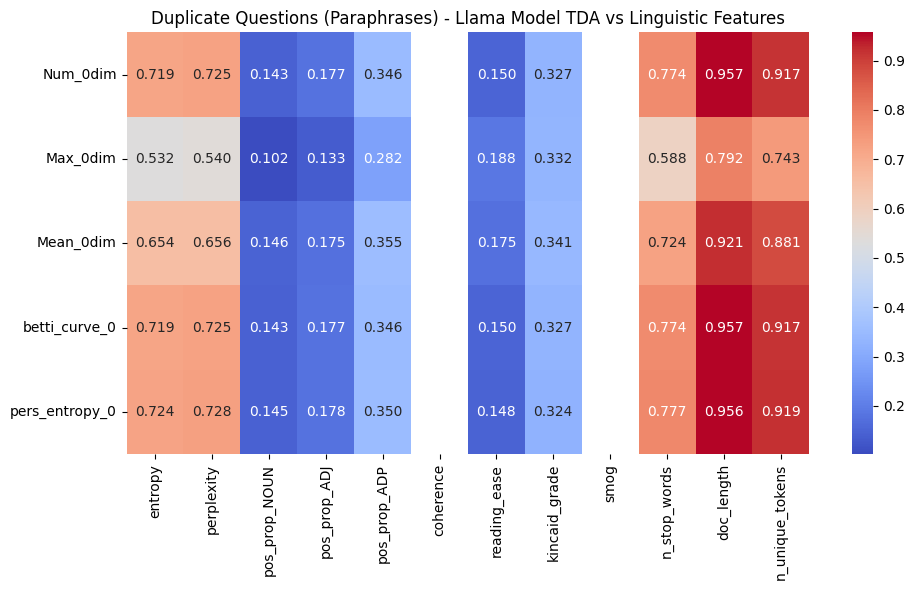

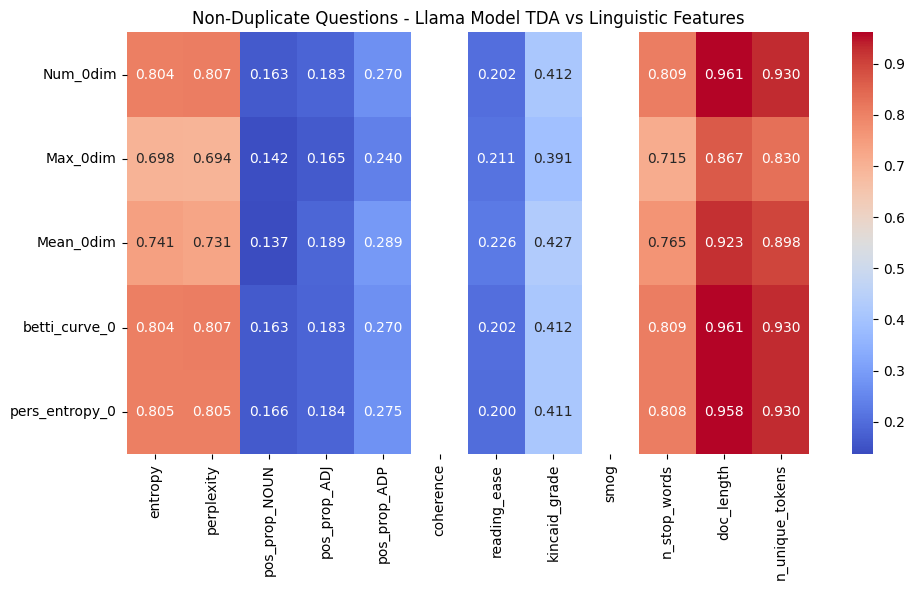

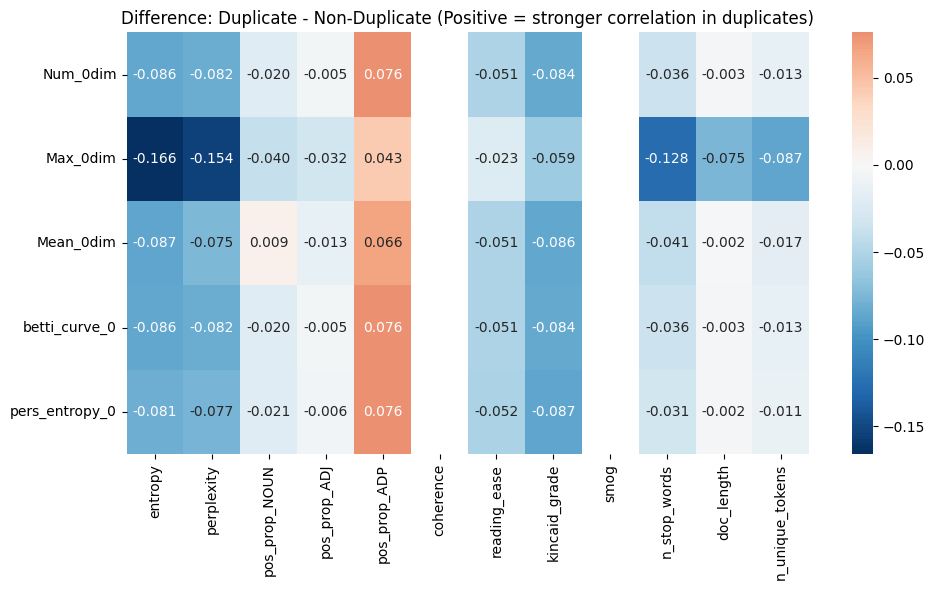

In [14]:
!pip install dcor seaborn

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dcor

focus_duplicate_feat = duplicate_feat[['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                                        'first_order_coherence', 'flesch_reading_ease', 'flesch_kincaid_grade', 'smog',
                                        'n_stop_words', 'doc_length', 'n_unique_tokens']]

focus_non_duplicate_feat = non_duplicate_feat[['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                                                'first_order_coherence', 'flesch_reading_ease', 'flesch_kincaid_grade', 'smog',
                                                'n_stop_words', 'doc_length', 'n_unique_tokens']]

focus_tda_duplicate = duplicate_tda[["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "persistence_entropy_0"]]
focus_tda_non_duplicate = non_duplicate_tda[["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "persistence_entropy_0"]]

tda_features = focus_tda_duplicate.to_numpy()
linguistic_features = focus_duplicate_feat.to_numpy()

corr_matrix_duplicate = np.zeros((tda_features.shape[1], linguistic_features.shape[1]))

for i in range(tda_features.shape[1]):
    for j in range(linguistic_features.shape[1]):
        corr_matrix_duplicate[i, j] = dcor.distance_correlation(tda_features[:, i], linguistic_features[:, j])

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_duplicate, annot=True, cmap="coolwarm", fmt='.3f',
            xticklabels=['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                        'coherence', 'reading_ease', 'kincaid_grade', 'smog',
                        'n_stop_words', 'doc_length', 'n_unique_tokens'],
            yticklabels=["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "pers_entropy_0"])
plt.title("Duplicate Questions (Paraphrases) - Llama Model TDA vs Linguistic Features")
plt.tight_layout()
plt.show()

tda_features = focus_tda_non_duplicate.to_numpy()
linguistic_features = focus_non_duplicate_feat.to_numpy()

corr_matrix_non_duplicate = np.zeros((tda_features.shape[1], linguistic_features.shape[1]))

for i in range(tda_features.shape[1]):
    for j in range(linguistic_features.shape[1]):
        corr_matrix_non_duplicate[i, j] = dcor.distance_correlation(tda_features[:, i], linguistic_features[:, j])

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_non_duplicate, annot=True, cmap="coolwarm", fmt='.3f',
            xticklabels=['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                        'coherence', 'reading_ease', 'kincaid_grade', 'smog',
                        'n_stop_words', 'doc_length', 'n_unique_tokens'],
            yticklabels=["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "pers_entropy_0"])
plt.title("Non-Duplicate Questions - Llama Model TDA vs Linguistic Features")
plt.tight_layout()
plt.show()

corr_matrix_diff = corr_matrix_duplicate - corr_matrix_non_duplicate

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_diff, annot=True, cmap="RdBu_r", fmt='.3f', center=0,
            xticklabels=['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                        'coherence', 'reading_ease', 'kincaid_grade', 'smog',
                        'n_stop_words', 'doc_length', 'n_unique_tokens'],
            yticklabels=["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "pers_entropy_0"])
plt.title("Difference: Duplicate - Non-Duplicate (Positive = stronger correlation in duplicates)")
plt.tight_layout()
plt.show()